# Chapter 14: Deep Computer Vision Using Convolutional Neural Networks

## Table of Contents
1. [Introduction to Computer Vision](#introduction)
2. [The Architecture of the Visual Cortex](#visual-cortex)
3. [Convolutional Layers](#conv-layers)
4. [Pooling Layers](#pooling-layers)
5. [CNN Architectures](#cnn-architectures)
6. [Using Pretrained Models](#pretrained-models)
7. [Transfer Learning](#transfer-learning)
8. [Classification and Localization](#classification-localization)
9. [Object Detection](#object-detection)
10. [Semantic Segmentation](#semantic-segmentation)
11. [Exercises](#exercises)

---

## Google Colab Setup

First, let's set up our environment with all necessary imports and configurations.

In [7]:
# Install required packages for Google Colab
!pip install -q tensorflow==2.16.1
!pip install -q tensorflow-datasets
!pip install -q matplotlib
!pip install -q scikit-learn
!pip install -q pillow

# Standard imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.datasets import load_sample_images
from sklearn.metrics import classification_report
import math
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
else:
    print("No GPU available, using CPU")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

No GPU available, using CPU
TensorFlow version: 2.16.1
Keras version: 3.10.0


## 1. Introduction to Computer Vision

Computer vision is one of the most exciting applications of Deep Learning. The human visual system can effortlessly recognize objects, faces, and scenes, but replicating this capability in machines has been a significant challenge until the advent of Convolutional Neural Networks (CNNs).

### Historical Context

- **1996**: IBM's Deep Blue beats chess world champion Garry Kasparov
- **2012**: AlexNet revolutionizes image recognition
- **Present**: CNNs achieve superhuman performance on many visual tasks

### Why Computer Vision is Challenging

The difficulty lies in the fact that **perception occurs outside our conscious awareness**. When we see a cute puppy, we cannot choose not to see it or explain how we recognize it - it's automatic. This suggests that visual processing involves specialized neural modules that transform raw sensory data into high-level features before reaching consciousness.

### Applications of CNNs

- Image search services
- Self-driving cars
- Automatic video classification
- Medical image analysis
- Voice recognition
- Natural language processing

## 2. The Architecture of the Visual Cortex

CNNs were inspired by groundbreaking research on the mammalian visual cortex by **David H. Hubel** and **Torsten Wiesel** (Nobel Prize 1981).

### Key Discoveries

1. **Local Receptive Fields**: Many neurons react only to visual stimuli in a limited region
2. **Overlapping Fields**: Different neurons' receptive fields overlap and tile the entire visual field
3. **Orientation Selectivity**: Some neurons respond only to specific line orientations
4. **Hierarchical Processing**: Higher-level neurons detect complex patterns by combining lower-level features

### Mathematical Foundation

The visual cortex can be modeled as a hierarchical feature detector where:

$$h^{(l+1)} = f(W^{(l)} * h^{(l)} + b^{(l)})$$

Where:
- $h^{(l)}$ = activations at layer $l$
- $W^{(l)}$ = learnable filters/kernels
- $*$ = convolution operation
- $f$ = activation function
- $b^{(l)}$ = bias terms

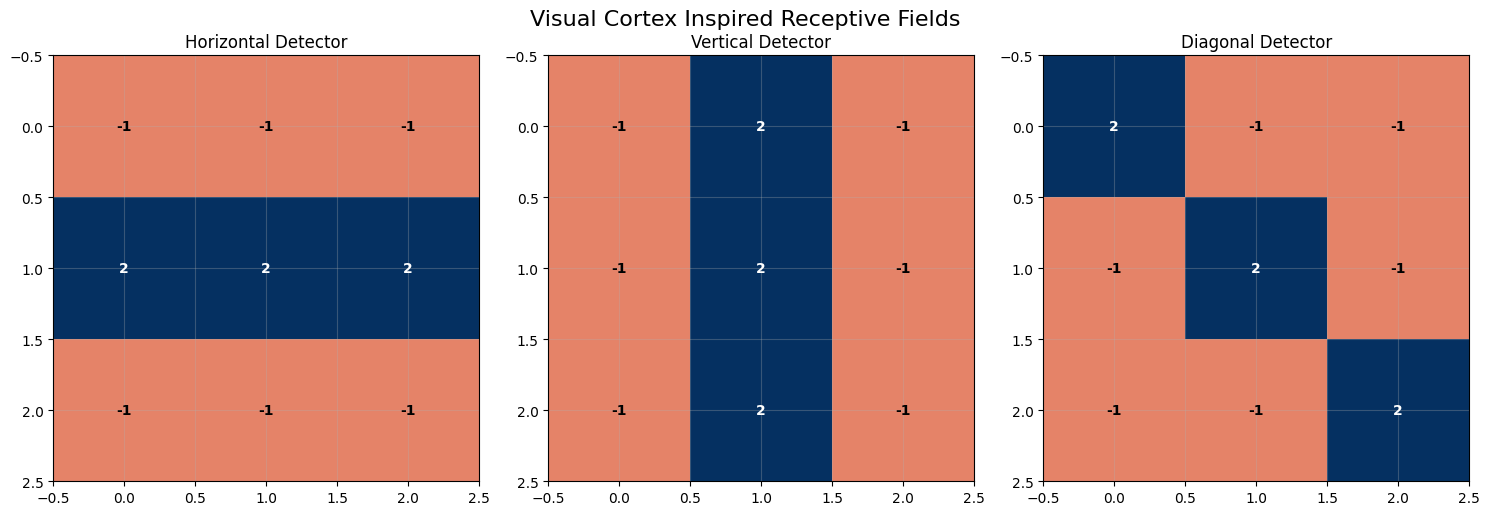

These receptive fields demonstrate how different neurons respond to different orientations:
- Horizontal Detector: Positive weights in middle row, negative elsewhere
- Vertical Detector: Positive weights in middle column, negative elsewhere
- Diagonal Detector: Positive weights along diagonal, negative elsewhere


In [8]:
# Demonstrate the concept of receptive fields
def visualize_receptive_fields():
    """
    This function demonstrates how neurons in the visual cortex have
    local receptive fields that respond to specific patterns.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Create a simple pattern
    image = np.zeros((10, 10))
    image[3:7, 2:8] = 1  # Horizontal bar

    # Show different types of receptive fields
    # Receptive field 1: Responds to horizontal lines
    rf1 = np.array([[-1, -1, -1],
                    [ 2,  2,  2],
                    [-1, -1, -1]])

    # Receptive field 2: Responds to vertical lines
    rf2 = np.array([[-1,  2, -1],
                    [-1,  2, -1],
                    [-1,  2, -1]])

    # Receptive field 3: Responds to diagonal lines
    rf3 = np.array([[ 2, -1, -1],
                    [-1,  2, -1],
                    [-1, -1,  2]])

    receptive_fields = [rf1, rf2, rf3]
    titles = ['Horizontal Detector', 'Vertical Detector', 'Diagonal Detector']

    for i, (rf, title) in enumerate(zip(receptive_fields, titles)):
        axes[i].imshow(rf, cmap='RdBu', vmin=-2, vmax=2)
        axes[i].set_title(title)
        axes[i].grid(True, alpha=0.3)

        # Add text annotations
        for r in range(3):
            for c in range(3):
                axes[i].text(c, r, f'{rf[r,c]}', ha='center', va='center',
                           color='white' if abs(rf[r,c]) > 1 else 'black', fontweight='bold')

    plt.tight_layout()
    plt.suptitle('Visual Cortex Inspired Receptive Fields', y=1.02, fontsize=16)
    plt.show()

    print("These receptive fields demonstrate how different neurons respond to different orientations:")
    print("- Horizontal Detector: Positive weights in middle row, negative elsewhere")
    print("- Vertical Detector: Positive weights in middle column, negative elsewhere")
    print("- Diagonal Detector: Positive weights along diagonal, negative elsewhere")

visualize_receptive_fields()

## 3. Convolutional Layers

Convolutional layers are the fundamental building blocks of CNNs. Unlike fully connected layers, convolutional layers:

1. **Preserve spatial relationships** in the input
2. **Use shared weights** (parameter sharing)
3. **Have local connectivity** (sparse connections)

### Mathematical Definition

The output of a convolutional layer at position $(i,j)$ in feature map $k$ is:

$$z_{i,j,k} = b_k + \sum_{u=0}^{f_h-1} \sum_{v=0}^{f_w-1} \sum_{k'=0}^{f_{n'}-1} x_{i',j',k'} \cdot w_{u,v,k',k}$$

Where:
- $i' = i \times s_h + u$, $j' = j \times s_w + v$
- $s_h, s_w$ = vertical and horizontal strides
- $f_h, f_w$ = filter height and width
- $f_{n'}$ = number of input feature maps
- $w_{u,v,k',k}$ = weight connecting input channel $k'$ to output channel $k$
- $b_k$ = bias for feature map $k$

### Key Concepts

#### 1. Filters/Kernels
Small matrices that slide across the input to detect specific patterns.

#### 2. Stride
The step size when moving the filter across the input.

#### 3. Padding
- **"VALID"**: No padding, output size = $\frac{\text{input size} - \text{filter size}}{\text{stride}} + 1$
- **"SAME"**: Zero padding to maintain input size (when stride=1)

#### 4. Feature Maps
Each filter produces one feature map, highlighting specific patterns in the input.

Loaded images shape: (2, 427, 640, 3)
Batch size: 2, Height: 427, Width: 640, Channels: 3

Filter shapes and properties:
Filters shape: (7, 7, 3, 2)
Filter 1 (Vertical): Detects vertical edges
Filter 2 (Horizontal): Detects horizontal edges

Convolution output shape: (2, 427, 640, 2)
Output interpretation: [batch_size, height, width, num_filters]


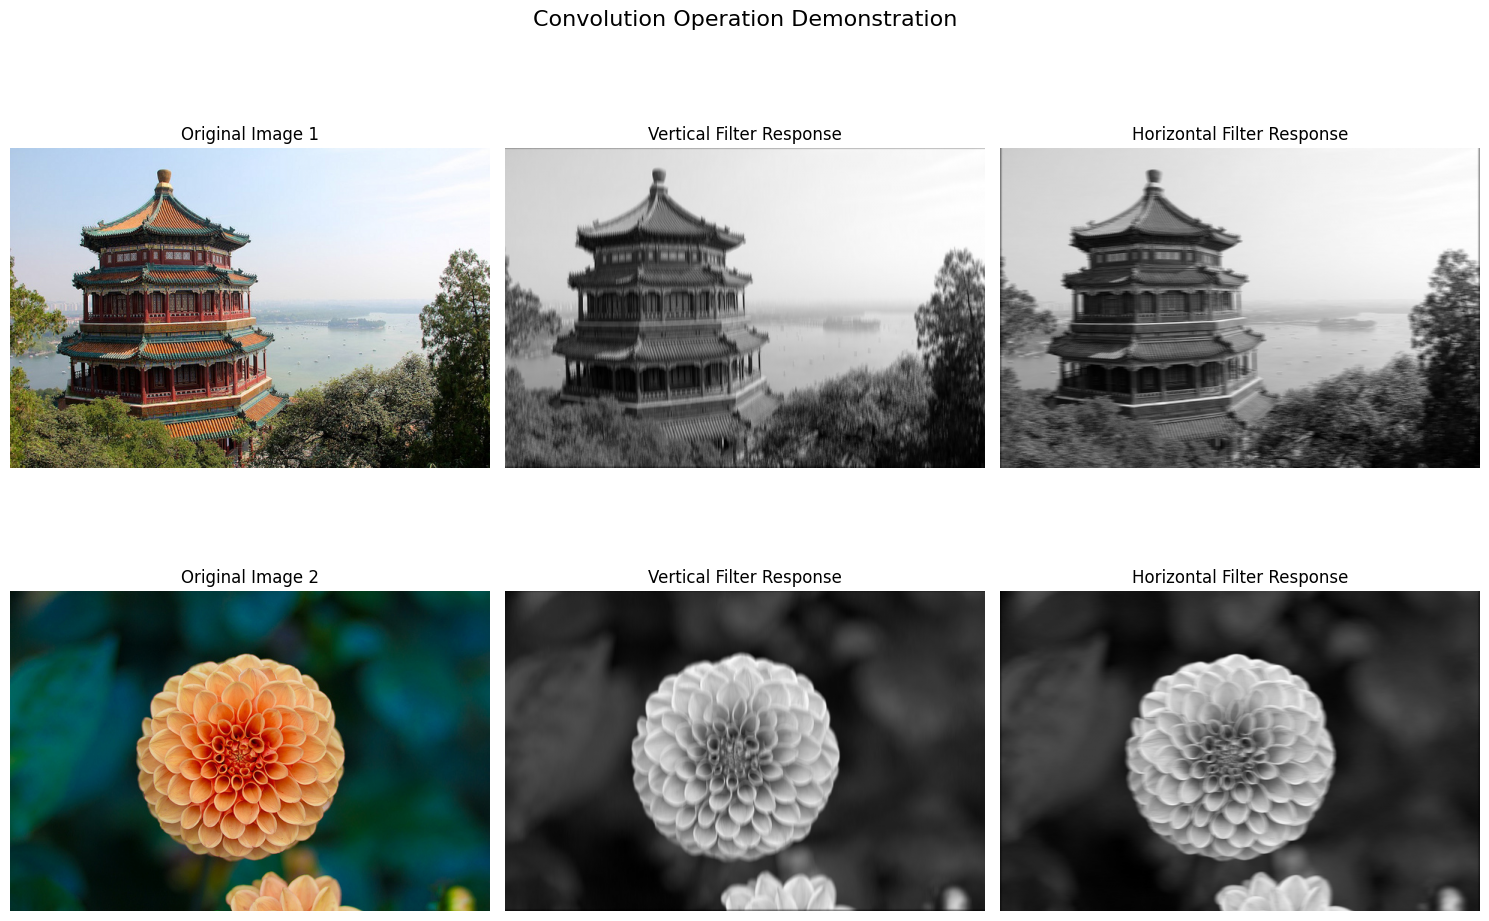

In [9]:
# Load sample images for demonstration
def load_and_preprocess_images():
    """
    Load sample images and preprocess them for CNN operations.
    This function demonstrates the preprocessing pipeline.
    """
    # Load sample images (China temple and flower)
    images = load_sample_images()
    china = images.images[0] / 255.0  # Normalize to [0, 1]
    flower = images.images[1] / 255.0

    # Stack images into a batch
    images_batch = np.array([china, flower])
    batch_size, height, width, channels = images_batch.shape

    print(f"Loaded images shape: {images_batch.shape}")
    print(f"Batch size: {batch_size}, Height: {height}, Width: {width}, Channels: {channels}")

    return images_batch

# Demonstrate manual convolution operation
def demonstrate_convolution():
    """
    This function demonstrates how convolution operations work manually,
    showing the mathematical foundation behind CNNs.
    """
    images = load_and_preprocess_images()
    batch_size, height, width, channels = images.shape

    # Create two different filters manually
    # Filter 1: Vertical edge detector (7x7 filter)
    filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
    filters[:, 3, :, 0] = 1  # Vertical line in the middle
    filters[3, :, :, 1] = 1  # Horizontal line in the middle

    print("\nFilter shapes and properties:")
    print(f"Filters shape: {filters.shape}")
    print(f"Filter 1 (Vertical): Detects vertical edges")
    print(f"Filter 2 (Horizontal): Detects horizontal edges")

    # Apply convolution using TensorFlow
    # tf.nn.conv2d performs: output = conv2d(input, filters, strides, padding)
    outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

    print(f"\nConvolution output shape: {outputs.shape}")
    print(f"Output interpretation: [batch_size, height, width, num_filters]")

    # Visualize the results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for img_idx in range(2):
        # Original image
        axes[img_idx, 0].imshow(images[img_idx])
        axes[img_idx, 0].set_title(f"Original Image {img_idx + 1}")
        axes[img_idx, 0].axis('off')

        # Vertical filter response
        axes[img_idx, 1].imshow(outputs[img_idx, :, :, 0], cmap="gray")
        axes[img_idx, 1].set_title(f"Vertical Filter Response")
        axes[img_idx, 1].axis('off')

        # Horizontal filter response
        axes[img_idx, 2].imshow(outputs[img_idx, :, :, 1], cmap="gray")
        axes[img_idx, 2].set_title(f"Horizontal Filter Response")
        axes[img_idx, 2].axis('off')

    plt.tight_layout()
    plt.suptitle('Convolution Operation Demonstration', y=1.02, fontsize=16)
    plt.show()

    return images, filters, outputs

images, filters, conv_outputs = demonstrate_convolution()

In [10]:
# Demonstrate Keras Conv2D layer
def keras_convolution_demo():
    """
    This function demonstrates how to use Keras Conv2D layers,
    which are the practical implementation of convolutional layers.
    """
    print("=== Keras Conv2D Layer Demonstration ===")

    # Create a Conv2D layer
    # Parameters explanation:
    # - filters=32: Number of output feature maps
    # - kernel_size=3: 3x3 filter size
    # - strides=1: Move filter one pixel at a time
    # - padding="same": Maintain input spatial dimensions
    # - activation="relu": Apply ReLU activation function
    conv_layer = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=[64, 64, 3]  # Height, Width, Channels
    )

    # Create a simple model to see the layer in action
    model = tf.keras.Sequential([
        conv_layer,
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

    # Build the model with a dummy input
    model.build(input_shape=(None, 64, 64, 3))

    print("Model Architecture:")
    model.summary()

    # Calculate and explain parameter counts
    print("\n=== Parameter Calculation Explanation ===")

    # First Conv2D layer: (3x3x3 + 1) x 32 = 896 parameters
    # 3x3 kernel size, 3 input channels, 32 output channels, +1 for bias
    first_conv_params = (3 * 3 * 3 + 1) * 32
    print(f"First Conv2D layer parameters: (3×3×3 + 1) × 32 = {first_conv_params}")

    # Second Conv2D layer: (3x3x32 + 1) x 64 = 18,496 parameters
    second_conv_params = (3 * 3 * 32 + 1) * 64
    print(f"Second Conv2D layer parameters: (3×3×32 + 1) × 64 = {second_conv_params}")

    # Third Conv2D layer: (3x3x64 + 1) x 128 = 73,856 parameters
    third_conv_params = (3 * 3 * 64 + 1) * 128
    print(f"Third Conv2D layer parameters: (3×3×64 + 1) × 128 = {third_conv_params}")

    return model

demo_model = keras_convolution_demo()

=== Keras Conv2D Layer Demonstration ===
Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,538 (369.29 KB)

 Trainable params: 94,538 (369.29 KB)

 Non-trainable params: 0 (0.00 B)


=== Parameter Calculation Explanation ===
First Conv2D layer parameters: (3×3×3 + 1) × 32 = 896
Second Conv2D layer parameters: (3×3×32 + 1) × 64 = 18496
Third Conv2D layer parameters: (3×3×64 + 1) × 128 = 73856


### Understanding Padding and Strides

Let's analyze how different padding and stride configurations affect the output dimensions:

#### Output Size Formula

For a given input size $n$, filter size $f$, stride $s$, and padding $p$:

$$\text{Output size} = \frac{n + 2p - f}{s} + 1$$

#### Padding Types

1. **"VALID" Padding**: $p = 0$
   - Output size = $\frac{n - f}{s} + 1$
   - Shrinks the spatial dimensions

2. **"SAME" Padding**: Chosen so output size = $\frac{n}{s}$ (when $s=1$, output size = input size)
   - Required padding: $p = \frac{f - 1}{2}$ (for odd filter sizes)
   - Preserves spatial dimensions (when stride=1)

=== Padding and Stride Effects ===
Input shape: (1, 13, 13, 1)

Configuration Analysis:
Input size: 13, Filter size: 6
--------------------------------------------------------------------------------
Stride   Padding  Output Size  Formula                   Actual Shape   
--------------------------------------------------------------------------------
1        valid    8            (13-6)/1+1 = 8            8×8            
1        same     13           ceil(13/1) = 13           13×13          
5        valid    2            (13-6)/5+1 = 2            2×2            
5        same     3            ceil(13/5) = 3            3×3            


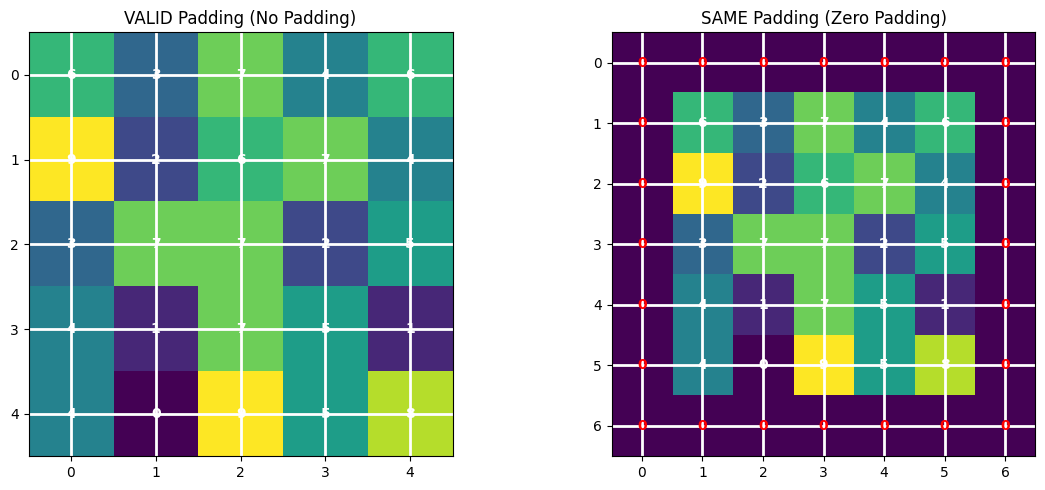


Padding Explanation:
- RED numbers in SAME padding represent zero-padding
- VALID padding: Output shrinks with each convolution
- SAME padding: Output maintains spatial dimensions (when stride=1)


In [11]:
def demonstrate_padding_and_strides():
    """
    This function demonstrates how padding and strides affect
    the output dimensions of convolutional operations.
    """
    print("=== Padding and Stride Effects ===")

    # Create a simple input tensor
    input_tensor = tf.random.normal((1, 13, 13, 1))  # Batch=1, 13x13 image, 1 channel
    print(f"Input shape: {input_tensor.shape}")

    # Test different configurations
    configurations = [
        {"filters": 1, "kernel_size": 6, "strides": 1, "padding": "valid"},
        {"filters": 1, "kernel_size": 6, "strides": 1, "padding": "same"},
        {"filters": 1, "kernel_size": 6, "strides": 5, "padding": "valid"},
        {"filters": 1, "kernel_size": 6, "strides": 5, "padding": "same"},
    ]

    print("\nConfiguration Analysis:")
    print("Input size: 13, Filter size: 6")
    print("-" * 80)
    print(f"{'Stride':<8} {'Padding':<8} {'Output Size':<12} {'Formula':<25} {'Actual Shape':<15}")
    print("-" * 80)

    for config in configurations:
        # Create layer and apply
        layer = tf.keras.layers.Conv2D(**config)
        output = layer(input_tensor)

        # Calculate theoretical output size
        n, f, s = 13, config["kernel_size"], config["strides"]

        if config["padding"] == "valid":
            theoretical_size = (n - f) // s + 1
            formula = f"(13-6)/{s}+1 = {theoretical_size}"
        else:  # "same" padding
            theoretical_size = math.ceil(n / s)
            formula = f"ceil(13/{s}) = {theoretical_size}"

        actual_shape = f"{output.shape[1]}×{output.shape[2]}"

        print(f"{s:<8} {config['padding']:<8} {theoretical_size:<12} {formula:<25} {actual_shape:<15}")

    # Visualize padding concept
    visualize_padding_concept()

def visualize_padding_concept():
    """
    Visualize how padding works in convolutional operations.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Create a simple 5x5 input
    input_data = np.random.randint(0, 10, (5, 5))

    # VALID padding (no padding)
    axes[0].imshow(input_data, cmap='viridis')
    axes[0].set_title('VALID Padding (No Padding)')
    axes[0].grid(True, color='white', linewidth=2)

    # Add text annotations
    for i in range(5):
        for j in range(5):
            axes[0].text(j, i, str(input_data[i, j]), ha='center', va='center',
                        color='white', fontweight='bold')

    # SAME padding (with zero padding)
    padded_data = np.pad(input_data, 1, mode='constant', constant_values=0)
    axes[1].imshow(padded_data, cmap='viridis')
    axes[1].set_title('SAME Padding (Zero Padding)')
    axes[1].grid(True, color='white', linewidth=2)

    # Add text annotations for padded data
    for i in range(7):
        for j in range(7):
            color = 'red' if (i == 0 or i == 6 or j == 0 or j == 6) else 'white'
            axes[1].text(j, i, str(padded_data[i, j]), ha='center', va='center',
                        color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\nPadding Explanation:")
    print("- RED numbers in SAME padding represent zero-padding")
    print("- VALID padding: Output shrinks with each convolution")
    print("- SAME padding: Output maintains spatial dimensions (when stride=1)")

demonstrate_padding_and_strides()

## 4. Pooling Layers

Pooling layers serve several important purposes in CNNs:

1. **Dimensionality Reduction**: Reduce spatial dimensions
2. **Translation Invariance**: Small shifts in input don't affect output
3. **Computational Efficiency**: Fewer parameters and computations
4. **Overfitting Prevention**: Act as regularization

### Types of Pooling

#### 1. Max Pooling
Most common type, takes the maximum value in each pooling window:

$$y_{i,j} = \max_{m,n \in \text{pool window}} x_{i \cdot s + m, j \cdot s + n}$$

#### 2. Average Pooling
Takes the mean of values in the pooling window:

$$y_{i,j} = \frac{1}{k^2} \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} x_{i \cdot s + m, j \cdot s + n}$$

Where $k$ is the pooling window size and $s$ is the stride.

#### 3. Global Average Pooling
Computes the average of each entire feature map:

$$y_k = \frac{1}{H \times W} \sum_{i=0}^{H-1} \sum_{j=0}^{W-1} x_{i,j,k}$$

### Memory Requirements

CNNs require significant memory, especially during training:

- **Forward pass**: Store intermediate activations
- **Backward pass**: Requires all forward pass activations
- **Memory usage**: At least sum of all layer outputs

**Example**: For a 150×100 RGB image with 200 feature maps of size 150×100:
- Output size: 200 × 150 × 100 × 32 bits = 96 million bits = 12 MB
- Batch of 100: 1.2 GB of RAM!

=== Pooling Operations Demonstration ===
Input feature map shape: (1, 8, 8, 1)
Input feature map (8x8):
[[7. 4. 8. 5. 7. 3. 7. 8.]
 [5. 4. 8. 8. 3. 6. 5. 2.]
 [8. 6. 2. 5. 1. 6. 9. 1.]
 [3. 7. 4. 9. 3. 5. 3. 7.]
 [5. 9. 7. 2. 4. 9. 2. 9.]
 [5. 2. 4. 7. 8. 3. 1. 4.]
 [2. 8. 4. 2. 6. 6. 4. 6.]
 [2. 2. 4. 8. 7. 9. 8. 5.]]

Max Pooling (2x2) output shape: (1, 4, 4, 1)
Output:
[[7. 8. 7. 8.]
 [8. 9. 6. 9.]
 [9. 7. 9. 9.]
 [8. 8. 9. 8.]]

Average Pooling (2x2) output shape: (1, 4, 4, 1)
Output:
[[5.   7.25 4.75 5.5 ]
 [6.   5.   3.75 5.  ]
 [5.25 5.   6.   4.  ]
 [3.5  4.5  7.   5.75]]

Max Pooling (2x2, stride=1) output shape: (1, 7, 7, 1)
Output:
[[7. 8. 8. 8. 7. 7. 8.]
 [8. 8. 8. 8. 6. 9. 9.]
 [8. 7. 9. 9. 6. 9. 9.]
 [9. 9. 9. 9. 9. 9. 9.]
 [9. 9. 7. 8. 9. 9. 9.]
 [8. 8. 7. 8. 8. 6. 6.]
 [8. 8. 8. 8. 9. 9. 8.]]

Global Average Pooling output shape: (1, 1)
Output value: 5.20


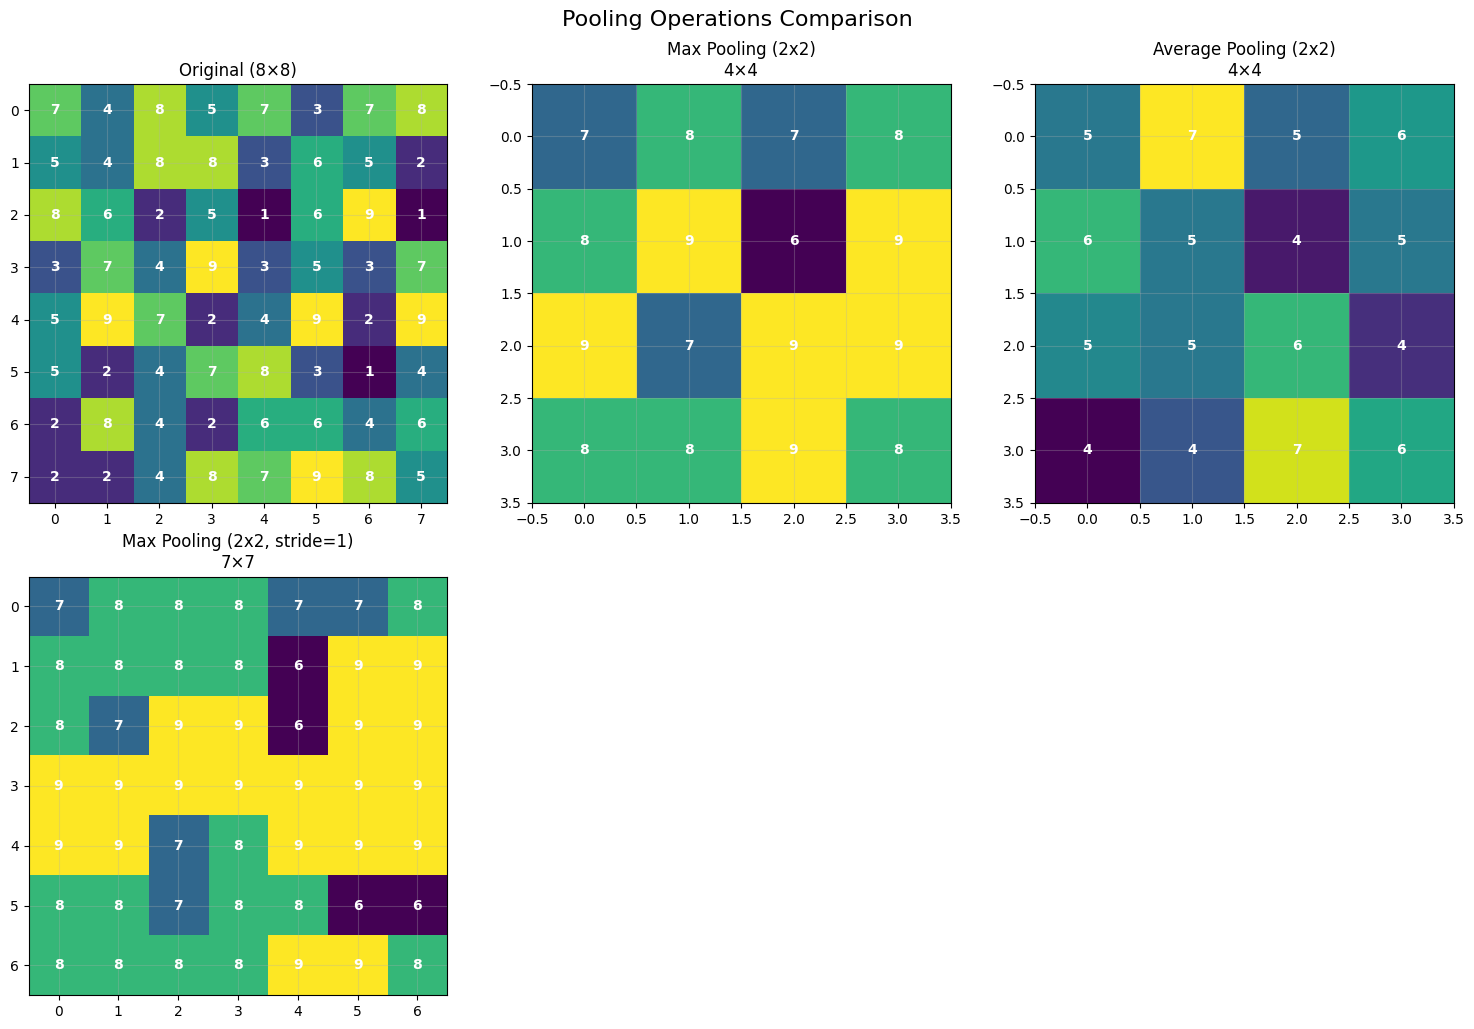


=== Translation Invariance Demonstration ===


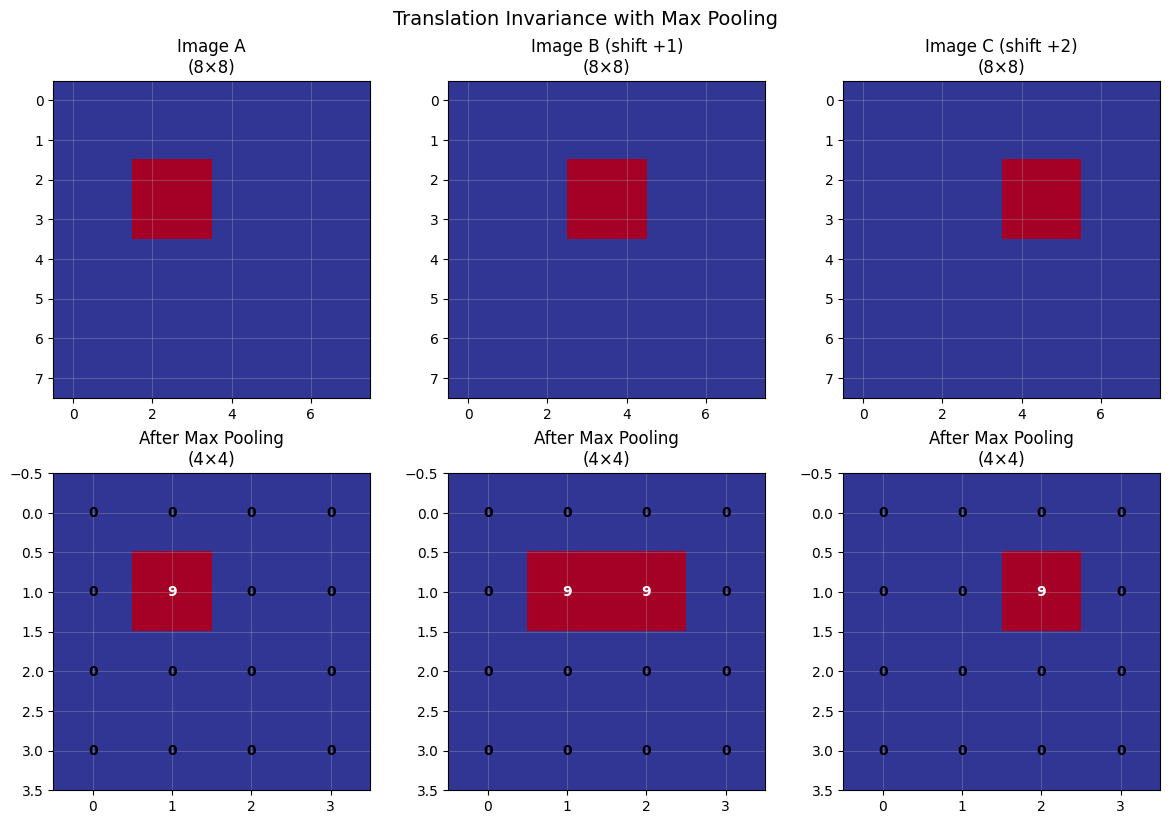


Translation Invariance Analysis:
Pooled A vs B similarity: False
Pooled A vs C similarity: False
Pooled B vs C similarity: False
Invariant pixels A vs B: 93.8%
Invariant pixels A vs C: 87.5%


In [12]:
def demonstrate_pooling_operations():
    """
    This function demonstrates different types of pooling operations
    and their effects on feature maps.
    """
    print("=== Pooling Operations Demonstration ===")

    # Create a sample feature map
    np.random.seed(42)
    feature_map = np.random.randint(1, 10, (1, 8, 8, 1)).astype(np.float32)

    print(f"Input feature map shape: {feature_map.shape}")
    print("Input feature map (8x8):")
    print(feature_map[0, :, :, 0])

    # Apply different pooling operations
    pooling_ops = {
        'Max Pooling (2x2)': tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        'Average Pooling (2x2)': tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
        'Max Pooling (2x2, stride=1)': tf.keras.layers.MaxPool2D(pool_size=2, strides=1),
        'Global Average Pooling': tf.keras.layers.GlobalAveragePooling2D()
    }

    results = {}
    for name, layer in pooling_ops.items():
        if 'Global' in name:
            result = layer(feature_map)
            results[name] = result
            print(f"\n{name} output shape: {result.shape}")
            print(f"Output value: {result.numpy()[0, 0]:.2f}")
        else:
            result = layer(feature_map)
            results[name] = result
            print(f"\n{name} output shape: {result.shape}")
            print(f"Output:")
            print(result[0, :, :, 0].numpy())

    # Visualize pooling operations
    visualize_pooling_effects(feature_map, results)

    return feature_map, results

def visualize_pooling_effects(input_map, pooling_results):
    """
    Visualize the effects of different pooling operations.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Original input
    im0 = axes[0].imshow(input_map[0, :, :, 0], cmap='viridis', interpolation='nearest')
    axes[0].set_title('Original (8×8)')
    axes[0].grid(True, alpha=0.3)

    # Add value annotations
    for i in range(8):
        for j in range(8):
            axes[0].text(j, i, f'{input_map[0, i, j, 0]:.0f}',
                        ha='center', va='center', color='white', fontweight='bold')

    # Pooling results
    plot_idx = 1
    for name, result in pooling_results.items():
        if 'Global' not in name and plot_idx < 6:
            if len(result.shape) == 4:  # 2D pooling result
                im = axes[plot_idx].imshow(result[0, :, :, 0], cmap='viridis', interpolation='nearest')
                axes[plot_idx].set_title(f'{name}\n{result.shape[1]}×{result.shape[2]}')
                axes[plot_idx].grid(True, alpha=0.3)

                # Add value annotations
                h, w = result.shape[1], result.shape[2]
                for i in range(h):
                    for j in range(w):
                        axes[plot_idx].text(j, i, f'{result[0, i, j, 0]:.0f}',
                                           ha='center', va='center', color='white', fontweight='bold')
                plot_idx += 1

    # Hide unused subplots
    for idx in range(plot_idx, 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.suptitle('Pooling Operations Comparison', y=1.02, fontsize=16)
    plt.show()

def demonstrate_translation_invariance():
    """
    Demonstrate how max pooling provides translation invariance.
    """
    print("\n=== Translation Invariance Demonstration ===")

    # Create three images with a pattern shifted by 1 and 2 pixels
    images = np.zeros((3, 8, 8, 1))

    # Image A: Pattern at position (2,2)
    images[0, 2:4, 2:4, 0] = 9

    # Image B: Pattern shifted right by 1 pixel
    images[1, 2:4, 3:5, 0] = 9

    # Image C: Pattern shifted right by 2 pixels
    images[2, 2:4, 4:6, 0] = 9

    # Apply max pooling
    max_pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
    pooled_results = max_pool(images)

    # Visualize translation invariance
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    labels = ['Image A', 'Image B (shift +1)', 'Image C (shift +2)']

    for i in range(3):
        # Original images
        axes[0, i].imshow(images[i, :, :, 0], cmap='RdYlBu_r', vmin=0, vmax=9)
        axes[0, i].set_title(f'{labels[i]}\n(8×8)')
        axes[0, i].grid(True, alpha=0.3)

        # Pooled results
        axes[1, i].imshow(pooled_results[i, :, :, 0], cmap='RdYlBu_r', vmin=0, vmax=9)
        axes[1, i].set_title(f'After Max Pooling\n(4×4)')
        axes[1, i].grid(True, alpha=0.3)

        # Add value annotations
        for row in range(4):
            for col in range(4):
                val = pooled_results[i, row, col, 0]
                axes[1, i].text(col, row, f'{val:.0f}',
                               ha='center', va='center',
                               color='white' if val > 4 else 'black',
                               fontweight='bold')

    plt.tight_layout()
    plt.suptitle('Translation Invariance with Max Pooling', y=1.02, fontsize=14)
    plt.show()

    # Check if pooled results are similar
    print("\nTranslation Invariance Analysis:")
    print(f"Pooled A vs B similarity: {np.allclose(pooled_results[0], pooled_results[1])}")
    print(f"Pooled A vs C similarity: {np.allclose(pooled_results[0], pooled_results[2])}")
    print(f"Pooled B vs C similarity: {np.allclose(pooled_results[1], pooled_results[2])}")

    # Calculate percentage of invariant pixels
    invariant_AB = np.mean(pooled_results[0] == pooled_results[1]) * 100
    invariant_AC = np.mean(pooled_results[0] == pooled_results[2]) * 100
    print(f"Invariant pixels A vs B: {invariant_AB:.1f}%")
    print(f"Invariant pixels A vs C: {invariant_AC:.1f}%")

# Run pooling demonstrations
input_map, pooling_results = demonstrate_pooling_operations()
demonstrate_translation_invariance()

## 5. CNN Architectures

### Typical CNN Architecture Pattern

A typical CNN follows this pattern:

```
Input → [Conv → ReLU → Conv → ReLU → Pool] × N → [FC → ReLU] × M → Output
```

Key characteristics:
- **Spatial dimensions decrease** as we go deeper
- **Number of feature maps increases** as we go deeper
- **Receptive field grows** allowing detection of larger patterns

### Design Principles

1. **Use smaller kernels**: Stack 2 layers of 3×3 instead of 1 layer of 5×5
   - Fewer parameters: $2 \times (3^2 \times C) < 5^2 \times C$ when $C > 9$
   - More non-linearity (2 ReLU vs 1 ReLU)
   - Same receptive field

2. **Double feature maps after pooling**: Compensates for spatial reduction

3. **Use global average pooling**: Reduces overfitting compared to fully connected layers

### Evolution of CNN Architectures

Let's examine the key milestones in CNN architecture development.

In [13]:
def build_simple_cnn_for_fashion_mnist():
    """
    Build and train a simple CNN for Fashion-MNIST dataset.
    This demonstrates the typical CNN architecture pattern.
    """
    print("=== Building Simple CNN for Fashion-MNIST ===")

    # Load and preprocess Fashion-MNIST data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # Normalize pixel values to [0, 1] and add channel dimension
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = x_train[..., np.newaxis]  # Add channel dimension
    x_test = x_test[..., np.newaxis]

    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    # Define class names
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Build the CNN model (following the book's example)
    model = tf.keras.Sequential([
        # First convolutional block
        tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                              input_shape=[28, 28, 1], name="conv1"),
        tf.keras.layers.MaxPooling2D(2, name="pool1"),

        # Second convolutional block
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", name="conv2a"),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same", name="conv2b"),
        tf.keras.layers.MaxPooling2D(2, name="pool2"),

        # Third convolutional block
        tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", name="conv3a"),
        tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", name="conv3b"),
        tf.keras.layers.MaxPooling2D(2, name="pool3"),

        # Classifier head
        tf.keras.layers.Flatten(name="flatten"),
        tf.keras.layers.Dense(128, activation="relu", name="fc1"),
        tf.keras.layers.Dropout(0.5, name="dropout1"),
        tf.keras.layers.Dense(64, activation="relu", name="fc2"),
        tf.keras.layers.Dropout(0.5, name="dropout2"),
        tf.keras.layers.Dense(10, activation="softmax", name="output")
    ])

    # Print model architecture
    print("\nModel Architecture:")
    model.summary()

    # Analyze the architecture
    print("\n=== Architecture Analysis ===")
    print("Layer-by-layer analysis:")

    # Build model to get shapes
    model.build(input_shape=(None, 28, 28, 1))

    print("\nSpatial dimension changes:")
    spatial_dims = [(28, 28), (28, 28), (14, 14), (14, 14), (14, 14), (7, 7), (7, 7), (7, 7), (3, 3)]
    feature_maps = [1, 64, 64, 128, 128, 128, 256, 256, 256]
    layer_names = ['Input', 'Conv1', 'Pool1', 'Conv2a', 'Conv2b', 'Pool2', 'Conv3a', 'Conv3b', 'Pool3']

    print(f"{'Layer':<10} {'Spatial':<10} {'Features':<10} {'Memory (MB)':<12}")
    print("-" * 45)

    for name, (h, w), f in zip(layer_names, spatial_dims, feature_maps):
        memory_mb = (h * w * f * 4) / (1024 * 1024)  # 4 bytes per float32
        print(f"{name:<10} {h}×{w:<8} {f:<10} {memory_mb:.2f}")

    return model, (x_train, y_train), (x_test, y_test), class_names

def analyze_cnn_parameters(model):
    """
    Analyze parameter counts in the CNN.
    """
    print("\n=== Parameter Analysis ===")

    total_params = 0
    for layer in model.layers:
        if hasattr(layer, 'kernel') or hasattr(layer, 'weights'):
            layer_params = layer.count_params()
            total_params += layer_params

            if hasattr(layer, 'kernel'):
                kernel_shape = layer.kernel.shape
                if len(kernel_shape) == 4:  # Conv2D
                    h, w, in_ch, out_ch = kernel_shape
                    params_calc = (h * w * in_ch + 1) * out_ch  # +1 for bias
                    print(f"{layer.name:<10}: ({h}×{w}×{in_ch} + 1) × {out_ch} = {params_calc:,} parameters")
                elif len(kernel_shape) == 2:  # Dense
                    in_units, out_units = kernel_shape
                    params_calc = (in_units + 1) * out_units  # +1 for bias
                    print(f"{layer.name:<10}: ({in_units} + 1) × {out_units} = {params_calc:,} parameters")

    print(f"\nTotal parameters: {total_params:,}")
    print(f"Model size (approximate): {total_params * 4 / (1024**2):.2f} MB")

# Build and analyze the model
model, train_data, test_data, class_names = build_simple_cnn_for_fashion_mnist()
analyze_cnn_parameters(model)

=== Building Simple CNN for Fashion-MNIST ===
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Number of classes: 10

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2a (Conv2D)                 │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2b (Conv2D)                 │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv2D)                 │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3b (Conv2D)                 │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)


=== Architecture Analysis ===
Layer-by-layer analysis:

Spatial dimension changes:
Layer      Spatial    Features   Memory (MB) 
---------------------------------------------
Input      28×28       1          0.00
Conv1      28×28       64         0.19
Pool1      14×14       64         0.05
Conv2a     14×14       128        0.10
Conv2b     14×14       128        0.10
Pool2      7×7        128        0.02
Conv3a     7×7        256        0.05
Conv3b     7×7        256        0.05
Pool3      3×3        256        0.01

=== Parameter Analysis ===
conv1     : (7×7×1 + 1) × 64 = 3,200 parameters
conv2a    : (3×3×64 + 1) × 128 = 73,856 parameters
conv2b    : (3×3×128 + 1) × 128 = 147,584 parameters
conv3a    : (3×3×128 + 1) × 256 = 295,168 parameters
conv3b    : (3×3×256 + 1) × 256 = 590,080 parameters
fc1       : (2304 + 1) × 128 = 295,040 parameters
fc2       : (128 + 1) × 64 = 8,256 parameters
output    : (64 + 1) × 10 = 650 parameters

Total parameters: 1,413,834
Model size (approximate

### Famous CNN Architectures

Let's examine the evolution of CNN architectures that have shaped computer vision:

#### 1. LeNet-5 (1998)
- **Innovation**: First successful CNN for digit recognition
- **Architecture**: Simple stack of Conv → Pool → Conv → Pool → FC
- **Key features**: 5×5 filters, average pooling, sigmoid/tanh activations

#### 2. AlexNet (2012)
- **Innovation**: Sparked the deep learning revolution
- **Architecture**: Deeper network (8 layers), ReLU activations
- **Key features**: Dropout, data augmentation, GPU training, 11×11 then 5×5 then 3×3 filters
- **Performance**: Top-5 error rate: 17% (vs 26% for runner-up)

#### 3. VGGNet (2014)
- **Innovation**: Demonstrated power of depth with small filters
- **Architecture**: Very deep (16-19 layers) with only 3×3 filters
- **Key insight**: Stack of 3×3 filters = larger receptive field with fewer parameters

#### 4. GoogLeNet/Inception (2014)
- **Innovation**: Inception modules for multi-scale feature extraction
- **Architecture**: 22 layers with inception modules
- **Key features**: 1×1 convolutions for dimensionality reduction, global average pooling
- **Efficiency**: 10× fewer parameters than AlexNet

#### 5. ResNet (2015)
- **Innovation**: Skip connections enabling very deep networks
- **Architecture**: Up to 152 layers with residual blocks
- **Key insight**: $F(x) = H(x) - x$ is easier to learn than $H(x)$
- **Performance**: Top-5 error rate: 3.6%

=== Building ResNet-34 Architecture ===
ResNet-34 Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)


=== Skip Connection Benefits ===

Mathematical Foundation of Residual Learning:

Traditional approach: Learn H(x) directly
Residual approach: Learn F(x) = H(x) - x, then H(x) = F(x) + x

Benefits:
1. Identity mapping: If optimal H(x) = x, then F(x) = 0 (easier to learn)
2. Gradient flow: ∂L/∂x = ∂L/∂H × (∂F/∂x + 1)
   The '+1' ensures gradients can flow even if ∂F/∂x → 0
3. Feature reuse: Lower layers' features directly accessible to higher layers


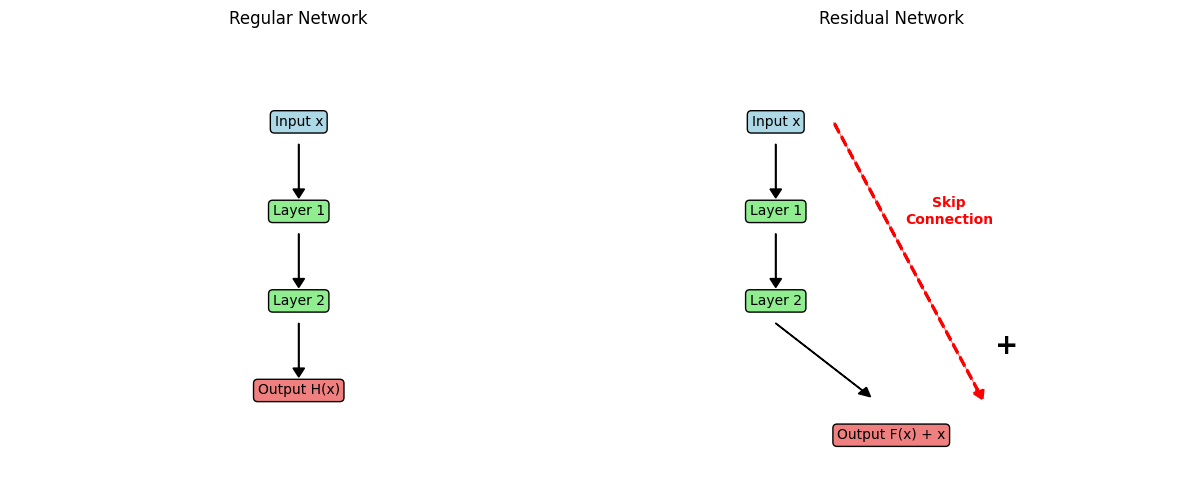

In [14]:
class ResidualUnit(tf.keras.layers.Layer):
    """
    Implementation of a Residual Unit as described in the ResNet paper.
    This demonstrates the key innovation of skip connections.
    """

    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        """
        Initialize the Residual Unit.

        Args:
            filters: Number of output filters
            strides: Stride for the first convolution
            activation: Activation function to use
        """
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

        # Main path: Conv → BN → ReLU → Conv → BN
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides,
                                  padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, 3, strides=1,
                                  padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()
        ]

        # Skip connection (only needed when stride > 1 or changing dimensions)
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides,
                                      padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        """
        Forward pass through the residual unit.
        Implements: output = activation(F(x) + x)
        """
        # Main path: F(x)
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        # Skip connection: x (possibly transformed)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        # Add skip connection and apply final activation
        return self.activation(Z + skip_Z)

def build_resnet34():
    """
    Build a ResNet-34 architecture as described in the book.
    This demonstrates how to combine residual units into a full network.
    """
    print("=== Building ResNet-34 Architecture ===")

    model = tf.keras.Sequential([
        # Initial convolution and pooling
        tf.keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding="same", use_bias=False, name="conv1"),
        tf.keras.layers.BatchNormalization(name="bn1"),
        tf.keras.layers.Activation("relu", name="relu1"),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same", name="pool1")
    ])

    # Add residual blocks
    # ResNet-34 has: 3 + 4 + 6 + 3 = 16 residual units
    prev_filters = 64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters

    # Global average pooling and classifier
    model.add(tf.keras.layers.GlobalAveragePooling2D(name="gap"))
    model.add(tf.keras.layers.Flatten(name="flatten"))
    model.add(tf.keras.layers.Dense(10, activation="softmax", name="classifier"))

    print("ResNet-34 Architecture:")
    model.summary()

    return model

def demonstrate_skip_connection_benefits():
    """
    Demonstrate why skip connections help with training deep networks.
    """
    print("\n=== Skip Connection Benefits ===")

    # Create a simple example showing gradient flow
    print("\nMathematical Foundation of Residual Learning:")
    print("\nTraditional approach: Learn H(x) directly")
    print("Residual approach: Learn F(x) = H(x) - x, then H(x) = F(x) + x")
    print("\nBenefits:")
    print("1. Identity mapping: If optimal H(x) = x, then F(x) = 0 (easier to learn)")
    print("2. Gradient flow: ∂L/∂x = ∂L/∂H × (∂F/∂x + 1)")
    print("   The '+1' ensures gradients can flow even if ∂F/∂x → 0")
    print("3. Feature reuse: Lower layers' features directly accessible to higher layers")

    # Visualize the concept
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Regular network
    axes[0].text(0.5, 0.8, 'Input x', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[0].text(0.5, 0.6, 'Layer 1', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[0].text(0.5, 0.4, 'Layer 2', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[0].text(0.5, 0.2, 'Output H(x)', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

    # Draw arrows
    axes[0].arrow(0.5, 0.75, 0, -0.1, head_width=0.02, head_length=0.02, fc='black')
    axes[0].arrow(0.5, 0.55, 0, -0.1, head_width=0.02, head_length=0.02, fc='black')
    axes[0].arrow(0.5, 0.35, 0, -0.1, head_width=0.02, head_length=0.02, fc='black')

    axes[0].set_title('Regular Network')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].axis('off')

    # Residual network
    axes[1].text(0.3, 0.8, 'Input x', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[1].text(0.3, 0.6, 'Layer 1', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[1].text(0.3, 0.4, 'Layer 2', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[1].text(0.7, 0.3, '+', ha='center', va='center', fontsize=20, fontweight='bold')
    axes[1].text(0.5, 0.1, 'Output F(x) + x', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

    # Draw arrows for main path
    axes[1].arrow(0.3, 0.75, 0, -0.1, head_width=0.02, head_length=0.02, fc='black')
    axes[1].arrow(0.3, 0.55, 0, -0.1, head_width=0.02, head_length=0.02, fc='black')
    axes[1].arrow(0.3, 0.35, 0.15, -0.15, head_width=0.02, head_length=0.02, fc='black')

    # Draw skip connection
    axes[1].arrow(0.4, 0.8, 0.25, -0.6, head_width=0.02, head_length=0.02,
                 fc='red', ec='red', linestyle='--', linewidth=2)
    axes[1].text(0.6, 0.6, 'Skip\nConnection', ha='center', va='center',
                color='red', fontweight='bold')

    axes[1].set_title('Residual Network')
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Build ResNet-34 and demonstrate concepts
resnet_model = build_resnet34()
demonstrate_skip_connection_benefits()

## 6. Using Pretrained Models from Keras

Instead of training from scratch, we can leverage pretrained models that have been trained on large datasets like ImageNet. This approach offers several advantages:

### Benefits of Pretrained Models

1. **Time saving**: No need to train for days/weeks
2. **Better features**: Learned from millions of images
3. **Lower computational cost**: Immediate inference capability
4. **Transfer learning**: Fine-tune for specific tasks

### Available Pretrained Models in Keras

- **ResNet family**: ResNet50, ResNet101, ResNet152
- **Inception family**: InceptionV3, InceptionResNetV2
- **VGG family**: VGG16, VGG19
- **EfficientNet family**: EfficientNetB0-B7
- **MobileNet family**: MobileNet, MobileNetV2, MobileNetV3
- **Xception**: Extreme Inception architecture

### ImageNet Dataset

- **Size**: 1.2 million training images, 50,000 validation images
- **Classes**: 1,000 categories
- **Image size**: Variable (models typically expect 224×224 or 299×299)
- **Challenge**: Top-5 error rate (system's top 5 predictions must contain correct answer)

=== Using Pretrained Models ===
Original images shape: (2, 427, 640, 3)

Loading pretrained ResNet50...
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 1000)
Number of parameters: 25,636,712
Resized images shape: (2, 224, 224, 3)
Preprocessed range: [-123.68, 151.06]

Making predictions...
Predictions shape: (2, 1000)
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== Prediction Results ===

China Temple:
  n02825657 - bell_cote            82.3%
  n03877845 - palace               6.8%
  n03781244 - monastery            4.2%

Flower:
  n03530642 - honeycomb            49.8%
  n13040303 - stinkhorn            34.0%
  n02206856 - bee                  4.3%


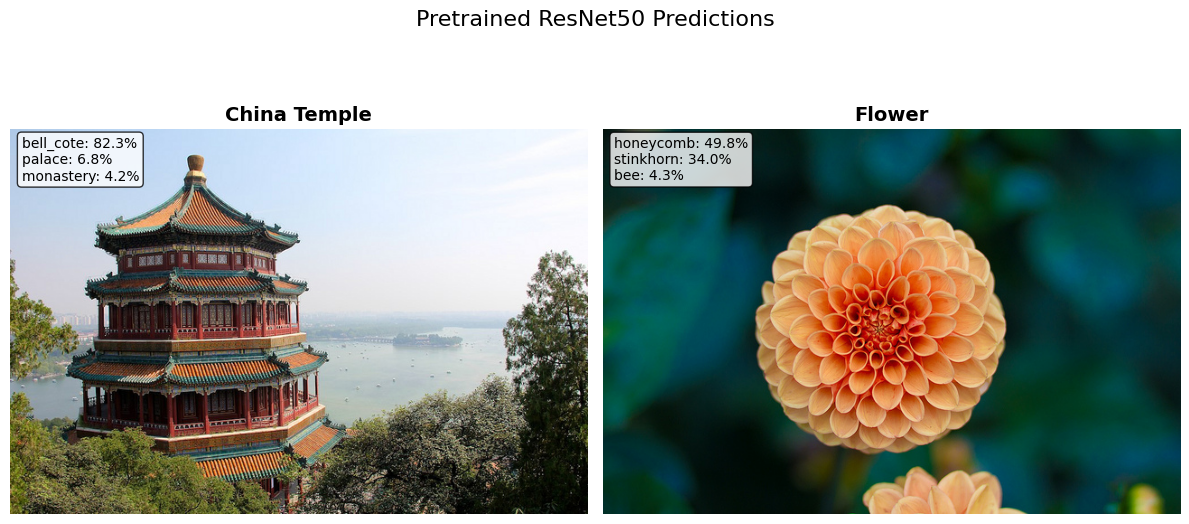


=== Comparing Different Architectures ===
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Testing ResNet50...
  Prediction: bell_cote (82.3%)
  Parameters: 25,636,712

Testing VGG16...
  Prediction: monastery (28.6%)
  Parameters: 138,357,544

Testing MobileNetV2...
  Prediction: monastery (31.1%)
  Parameters: 3,538,984

=== Model Comparison ===
Model        Prediction           Confidence   Parameters     
-----------------------------------------------------------------
ResNet50     bell_cote                82.3%   25,636,712
VGG16        monastery                28.6%  138,357,544
MobileNetV2  monastery                31.1%    3,538,984


In [15]:
def demonstrate_pretrained_models():
    """
    Demonstrate how to use pretrained models for image classification.
    This shows the practical application of transfer learning.
    """
    print("=== Using Pretrained Models ===")

    # Load sample images
    images = load_sample_images()
    china = images.images[0]
    flower = images.images[1]

    # Stack into batch and normalize
    images_batch = np.array([china, flower])
    print(f"Original images shape: {images_batch.shape}")

    # Load pretrained ResNet50
    print("\nLoading pretrained ResNet50...")
    model = tf.keras.applications.ResNet50(weights="imagenet")

    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    print(f"Number of parameters: {model.count_params():,}")

    # Resize images to expected input size (224x224)
    images_resized = tf.image.resize(images_batch, [224, 224])
    print(f"Resized images shape: {images_resized.shape}")

    # Preprocess for ResNet50 (expects different scaling than [0,1])
    # ResNet50 expects images in [0, 255] range before preprocessing
    images_preprocessed = tf.keras.applications.resnet50.preprocess_input(images_resized)
    print(f"Preprocessed range: [{images_preprocessed.numpy().min():.2f}, {images_preprocessed.numpy().max():.2f}]")

    # Make predictions
    print("\nMaking predictions...")
    predictions = model.predict(images_preprocessed, verbose=0)
    print(f"Predictions shape: {predictions.shape}")

    # Decode predictions to human-readable labels
    decoded_predictions = tf.keras.applications.resnet50.decode_predictions(predictions, top=3)

    # Display results
    print("\n=== Prediction Results ===")
    image_names = ["China Temple", "Flower"]

    for i, (img_name, img_preds) in enumerate(zip(image_names, decoded_predictions)):
        print(f"\n{img_name}:")
        for class_id, class_name, confidence in img_preds:
            print(f"  {class_id} - {class_name:<20} {confidence*100:.1f}%")

    # Visualize results
    visualize_predictions(images_batch, decoded_predictions, image_names)

    return model, images_batch, predictions

def visualize_predictions(images, predictions, image_names):
    """
    Visualize the original images with their top predictions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, (img, preds, name) in enumerate(zip(images, predictions, image_names)):
        axes[i].imshow(img)
        axes[i].set_title(f'{name}', fontsize=14, fontweight='bold')
        axes[i].axis('off')

        # Add prediction text
        pred_text = "\n".join([f"{cls}: {conf*100:.1f}%"
                              for _, cls, conf in preds])
        axes[i].text(0.02, 0.98, pred_text, transform=axes[i].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='white', alpha=0.8), fontsize=10)

    plt.tight_layout()
    plt.suptitle('Pretrained ResNet50 Predictions', y=1.02, fontsize=16)
    plt.show()

def compare_different_architectures():
    """
    Compare predictions from different pretrained architectures.
    """
    print("\n=== Comparing Different Architectures ===")

    # Load sample image
    images = load_sample_images()
    test_image = images.images[0]  # China temple

    # Prepare image for different models
    def prepare_image_for_model(image, target_size, preprocess_func):
        img_resized = tf.image.resize([image], target_size)[0]
        img_batch = tf.expand_dims(img_resized, 0)
        return preprocess_func(img_batch)

    # Define models to compare
    models_config = {
        'ResNet50': {
            'model': tf.keras.applications.ResNet50(weights='imagenet'),
            'size': (224, 224),
            'preprocess': tf.keras.applications.resnet50.preprocess_input,
            'decode': tf.keras.applications.resnet50.decode_predictions
        },
        'VGG16': {
            'model': tf.keras.applications.VGG16(weights='imagenet'),
            'size': (224, 224),
            'preprocess': tf.keras.applications.vgg16.preprocess_input,
            'decode': tf.keras.applications.vgg16.decode_predictions
        },
        'MobileNetV2': {
            'model': tf.keras.applications.MobileNetV2(weights='imagenet'),
            'size': (224, 224),
            'preprocess': tf.keras.applications.mobilenet_v2.preprocess_input,
            'decode': tf.keras.applications.mobilenet_v2.decode_predictions
        }
    }

    results = {}

    for model_name, config in models_config.items():
        print(f"\nTesting {model_name}...")

        # Prepare image
        processed_img = prepare_image_for_model(
            test_image, config['size'], config['preprocess']
        )

        # Make prediction
        pred = config['model'].predict(processed_img, verbose=0)
        decoded = config['decode'](pred, top=1)[0][0]

        results[model_name] = {
            'class': decoded[1],
            'confidence': decoded[2],
            'params': config['model'].count_params()
        }

        print(f"  Prediction: {decoded[1]} ({decoded[2]*100:.1f}%)")
        print(f"  Parameters: {config['model'].count_params():,}")

    # Compare results
    print("\n=== Model Comparison ===")
    print(f"{'Model':<12} {'Prediction':<20} {'Confidence':<12} {'Parameters':<15}")
    print("-" * 65)

    for model_name, result in results.items():
        print(f"{model_name:<12} {result['class']:<20} {result['confidence']*100:>8.1f}% {result['params']:>12,}")

# Run demonstrations
model, images, predictions = demonstrate_pretrained_models()
compare_different_architectures()

## 7. Transfer Learning

Transfer learning is one of the most powerful techniques in deep learning, especially when you have limited training data. The idea is to leverage knowledge from a pretrained model and adapt it to your specific task.

### Transfer Learning Strategy

1. **Feature Extraction**: Freeze pretrained layers, only train new classifier
2. **Fine-tuning**: Unfreeze some/all layers and train with low learning rate
3. **Progressive unfreezing**: Gradually unfreeze layers from top to bottom

### Mathematical Foundation

Consider a pretrained model $f_{\theta_{pre}}$ trained on dataset $D_{source}$. For target dataset $D_{target}$:

**Feature Extraction**:
$$f_{target}(x) = g_{\phi}(f_{\theta_{pre}}(x))$$

Where $\theta_{pre}$ is frozen and only $\phi$ (new classifier) is trained.

**Fine-tuning**:
$$\theta_{new} = \theta_{pre} + \alpha \cdot \Delta\theta$$

Where $\alpha$ is a small learning rate to prevent destroying pretrained features.

### When to Use Different Strategies

| Data Size | Similarity to ImageNet | Strategy |
|-----------|------------------------|----------|
| Small | High | Feature extraction |
| Small | Low | Feature extraction + fine-tune top layers |
| Large | High | Fine-tune all layers |
| Large | Low | Fine-tune all layers or train from scratch |

In [17]:
def implement_transfer_learning_flowers():
    """
    Implement transfer learning for flower classification using TensorFlow Datasets.
    This demonstrates the complete transfer learning pipeline.
    """
    print("=== Transfer Learning for Flower Classification ===")

    # Load the TF Flowers dataset
    print("Loading TF Flowers dataset...")
    dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

    # Get dataset information
    dataset_size = info.splits["train"].num_examples
    class_names = info.features["label"].names
    n_classes = info.features["label"].num_classes

    print(f"Dataset size: {dataset_size}")
    print(f"Classes: {class_names}")
    print(f"Number of classes: {n_classes}")

    # Split the dataset (since it only has train split)
    # Use slices instead of subsplit (subsplit is deprecated/removed in newer tfds versions)
    test_set = tfds.load("tf_flowers", split='train[:10%]', as_supervised=True)
    valid_set = tfds.load("tf_flowers", split='train[10%:25%]', as_supervised=True) # 10% to 25% (15% for validation)
    train_set = tfds.load("tf_flowers", split='train[25%:]', as_supervised=True)  # 25% to end (75% for training)


    print(f"Training samples: ~{int(dataset_size * 0.75)}")
    print(f"Validation samples: ~{int(dataset_size * 0.15)}")
    print(f"Test samples: ~{int(dataset_size * 0.10)}")

    # Preprocessing function
    def preprocess(image, label):
        """
        Preprocess images for Xception model.
        """
        # Resize to expected input size
        resized_image = tf.image.resize(image, [224, 224])
        # Apply Xception preprocessing
        final_image = tf.keras.applications.xception.preprocess_input(resized_image)
        return final_image, label

    # Data augmentation for training set
    def augment_and_preprocess(image, label):
        """
        Apply data augmentation and preprocessing.
        """
        # Random flip
        image = tf.image.random_flip_left_right(image)
        # Random brightness
        image = tf.image.random_brightness(image, 0.1)
        # Random contrast
        image = tf.image.random_contrast(image, 0.9, 1.1)
        # Resize and preprocess
        resized_image = tf.image.resize(image, [224, 224])
        final_image = tf.keras.applications.xception.preprocess_input(resized_image)
        return final_image, label

    # Apply preprocessing and create batches
    batch_size = 32

    train_set = train_set.shuffle(1000).map(augment_and_preprocess).batch(batch_size).prefetch(1)
    valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
    test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

    print("\nDataset preprocessing completed.")

    return train_set, valid_set, test_set, class_names, n_classes

def build_transfer_learning_model(n_classes, include_top=False, trainable=False):
    """
    Build a transfer learning model using Xception as base.

    Args:
        n_classes: Number of output classes
        include_top: Whether to include Xception's classification head
        trainable: Whether base model layers are trainable
    """
    print(f"\n=== Building Transfer Learning Model ===")
    print(f"Base model trainable: {trainable}")

    # Load pretrained Xception model (without top classification layer)
    base_model = tf.keras.applications.Xception(
        weights="imagenet",
        include_top=include_top,
        input_shape=[224, 224, 3]
    )

    # Freeze base model layers if specified
    base_model.trainable = trainable

    # Add custom classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n_classes, activation="softmax")
    ])

    print(f"Total parameters: {model.count_params():,}")

    # Count trainable vs non-trainable parameters
    trainable_params = sum([tf.reduce_prod(var.shape) for var in model.trainable_variables])
    non_trainable_params = model.count_params() - trainable_params

    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

    return model

def demonstrate_transfer_learning_phases():
    """
    Demonstrate the two-phase transfer learning approach.
    """
    print("\n=== Two-Phase Transfer Learning Demonstration ===")

    # Load and prepare data
    train_set, valid_set, test_set, class_names, n_classes = implement_transfer_learning_flowers()

    # Phase 1: Feature extraction (frozen base model)
    print("\n--- Phase 1: Feature Extraction ---")
    model_frozen = build_transfer_learning_model(n_classes, trainable=False)

    # Compile with higher learning rate for new layers
    model_frozen.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("Training with frozen base model (feature extraction)...")

    # Train for a few epochs (in practice, train until validation accuracy plateaus)
    history_frozen = model_frozen.fit(
        train_set,
        epochs=2,  # Reduced for demo purposes
        validation_data=valid_set,
        verbose=1
    )

    # Phase 2: Fine-tuning (unfreeze base model)
    print("\n--- Phase 2: Fine-tuning ---")

    # Unfreeze base model
    model_frozen.layers[0].trainable = True

    # Recompile with lower learning rate
    model_frozen.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("Fine-tuning with unfrozen base model...")

    # Continue training with fine-tuning
    history_finetuned = model_frozen.fit(
        train_set,
        epochs=2,  # Reduced for demo purposes
        validation_data=valid_set,
        verbose=1
    )

    # Evaluate final model
    print("\n--- Final Evaluation ---")
    test_loss, test_accuracy = model_frozen.evaluate(test_set, verbose=0)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Visualize training progress
    visualize_transfer_learning_progress(history_frozen, history_finetuned)

    return model_frozen, (history_frozen, history_finetuned)

def visualize_transfer_learning_progress(history1, history2):
    """
    Visualize the training progress during both phases of transfer learning.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Combine histories
    epochs1 = len(history1.history['accuracy'])
    epochs2 = len(history2.history['accuracy'])

    train_acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    train_loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot accuracy
    axes[0].plot(epochs[:epochs1], train_acc[:epochs1], 'b-', label='Training (Frozen)')
    axes[0].plot(epochs[:epochs1], val_acc[:epochs1], 'b--', label='Validation (Frozen)')
    axes[0].plot(epochs[epochs1:], train_acc[epochs1:], 'r-', label='Training (Fine-tuned)')
    axes[0].plot(epochs[epochs1:], val_acc[epochs1:], 'r--', label='Validation (Fine-tuned)')
    axes[0].axvline(x=epochs1, color='gray', linestyle=':', alpha=0.7, label='Phase Transition')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot loss
    axes[1].plot(epochs[:epochs1], train_loss[:epochs1], 'b-', label='Training (Frozen)')
    axes[1].plot(epochs[:epochs1], val_loss[:epochs1], 'b--', label='Validation (Frozen)')
    axes[1].plot(epochs[epochs1:], train_loss[epochs1:], 'r-', label='Training (Fine-tuned)')
    axes[1].plot(epochs[epochs1:], val_loss[epochs1:], 'r--', label='Validation (Fine-tuned)')
    axes[1].axvline(x=epochs1, color='gray', linestyle=':', alpha=0.7, label='Phase Transition')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Transfer Learning Progress: Feature Extraction → Fine-tuning', y=1.02)
    plt.show()

    print("\nTransfer Learning Analysis:")
    print("Phase 1 (Frozen): Fast convergence on new classifier")
    print("Phase 2 (Fine-tuned): Gradual improvement of entire network")
    print("Lower learning rate in Phase 2 prevents destruction of pretrained features")

def analyze_feature_extraction_vs_finetuning():
    """
    Theoretical analysis of feature extraction vs fine-tuning approaches.
    """
    print("\n=== Feature Extraction vs Fine-tuning Analysis ===")

    comparison_data = {
        'Aspect': ['Training Time', 'Memory Usage', 'Risk of Overfitting',
                   'Performance on Similar Tasks', 'Performance on Different Tasks',
                   'Required Data Amount', 'Computational Cost'],
        'Feature Extraction': ['Fast', 'Low', 'Low', 'Good', 'Limited',
                              'Small', 'Low'],
        'Fine-tuning': ['Slow', 'High', 'Medium', 'Excellent', 'Good',
                       'Medium-Large', 'High'],
        'Full Training': ['Very Slow', 'Very High', 'High', 'Excellent', 'Excellent',
                         'Large', 'Very High']
    }

    print(f"{'Aspect':<25} {'Feature Extract.':<15} {'Fine-tuning':<15} {'Full Training':<15}")
    print("-" * 75)

    for i, aspect in enumerate(comparison_data['Aspect']):
        print(f"{aspect:<25} {comparison_data['Feature Extraction'][i]:<15} "
              f"{comparison_data['Fine-tuning'][i]:<15} {comparison_data['Full Training'][i]:<15}")

    print("\n=== Mathematical Analysis ===")
    print("\nGradient Flow in Transfer Learning:")
    print("\nFeature Extraction: ∇θ_base = 0 (frozen layers)")
    print("                   ∇θ_new = ∂L/∂θ_new (only new layers learn)")
    print("\nFine-tuning:       ∇θ_base = α × ∂L/∂θ_base (small learning rate)")
    print("                   ∇θ_new = β × ∂L/∂θ_new (normal learning rate)")
    print("                   where α << β to preserve pretrained features")

    print("\n=== Decision Framework ===")
    print("\nChoose Feature Extraction when:")
    print("- Small dataset (< 1000 samples per class)")
    print("- Target task similar to ImageNet")
    print("- Limited computational resources")
    print("- Quick prototyping needed")

    print("\nChoose Fine-tuning when:")
    print("- Medium to large dataset (> 1000 samples per class)")
    print("- Target task somewhat different from ImageNet")
    print("- Computational resources available")
    print("- Maximum performance required")

# Run transfer learning demonstration
model, histories = demonstrate_transfer_learning_phases()
analyze_feature_extraction_vs_finetuning()


=== Two-Phase Transfer Learning Demonstration ===
=== Transfer Learning for Flower Classification ===
Loading TF Flowers dataset...
Dataset size: 3670
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of classes: 5
Training samples: ~2752
Validation samples: ~550
Test samples: ~367

Dataset preprocessing completed.

--- Phase 1: Feature Extraction ---

=== Building Transfer Learning Model ===
Base model trainable: False
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total parameters: 20,871,725
Trainable parameters: 10,245
Non-trainable parameters: 20,861,480
Training with frozen base model (feature extraction)...
Epoch 1/2
86/86 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - accuracy: 0.5982 - loss: 1.0351 - val_accuracy: 0.8076 - val_loss: 0.5209
Epoch 2/2
86/86 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - accuracy: 0.8630 - loss: 0.4100 - val_accuracy: 0.8439 - val_loss: 0.4458

--- Phase 2: Fine-tuning ---
Fine-tuning with unfrozen base model...
Epoch 1/2
86/86 ━━━━━━━━━━━━━

KeyboardInterrupt: 

## 8. Classification and Localization

Beyond simple classification, we often need to know **where** objects are located in images. Classification and localization combines:

1. **Classification**: What object is in the image?
2. **Localization**: Where is the object located?

### Mathematical Formulation

For an image $x$, we want to predict:
- **Class probabilities**: $p = \text{softmax}(f_c(x))$ where $p \in \mathbb{R}^C$
- **Bounding box**: $b = f_b(x)$ where $b = [x_{center}, y_{center}, width, height]$

### Multi-task Loss Function

The total loss combines classification and localization objectives:

$$L_{total} = \lambda_1 L_{classification} + \lambda_2 L_{localization}$$

Where:
- $L_{classification} = -\sum_{i=1}^C y_i \log(p_i)$ (cross-entropy)
- $L_{localization} = \sum_{j=1}^4 (b_j - \hat{b}_j)^2$ (MSE for bounding box)
- $\lambda_1, \lambda_2$ are loss weights to balance the objectives

### Bounding Box Representation

Common representations for bounding boxes:

1. **Center + Size**: $(x_c, y_c, w, h)$
2. **Corner coordinates**: $(x_{min}, y_{min}, x_{max}, y_{max})$
3. **Normalized coordinates**: All values in $[0, 1]$ relative to image size

### Intersection over Union (IoU)

IoU measures the quality of bounding box predictions:

$$\text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}} = \frac{|B_{pred} \cap B_{true}|}{|B_{pred} \cup B_{true}|}$$

Where $B_{pred}$ and $B_{true}$ are predicted and ground truth bounding boxes.


=== IoU Calculation Demonstration ===
Perfect Match  : IoU = 1.000
Shifted Right  : IoU = 0.600
Smaller Box    : IoU = 0.250
No Overlap     : IoU = 0.000


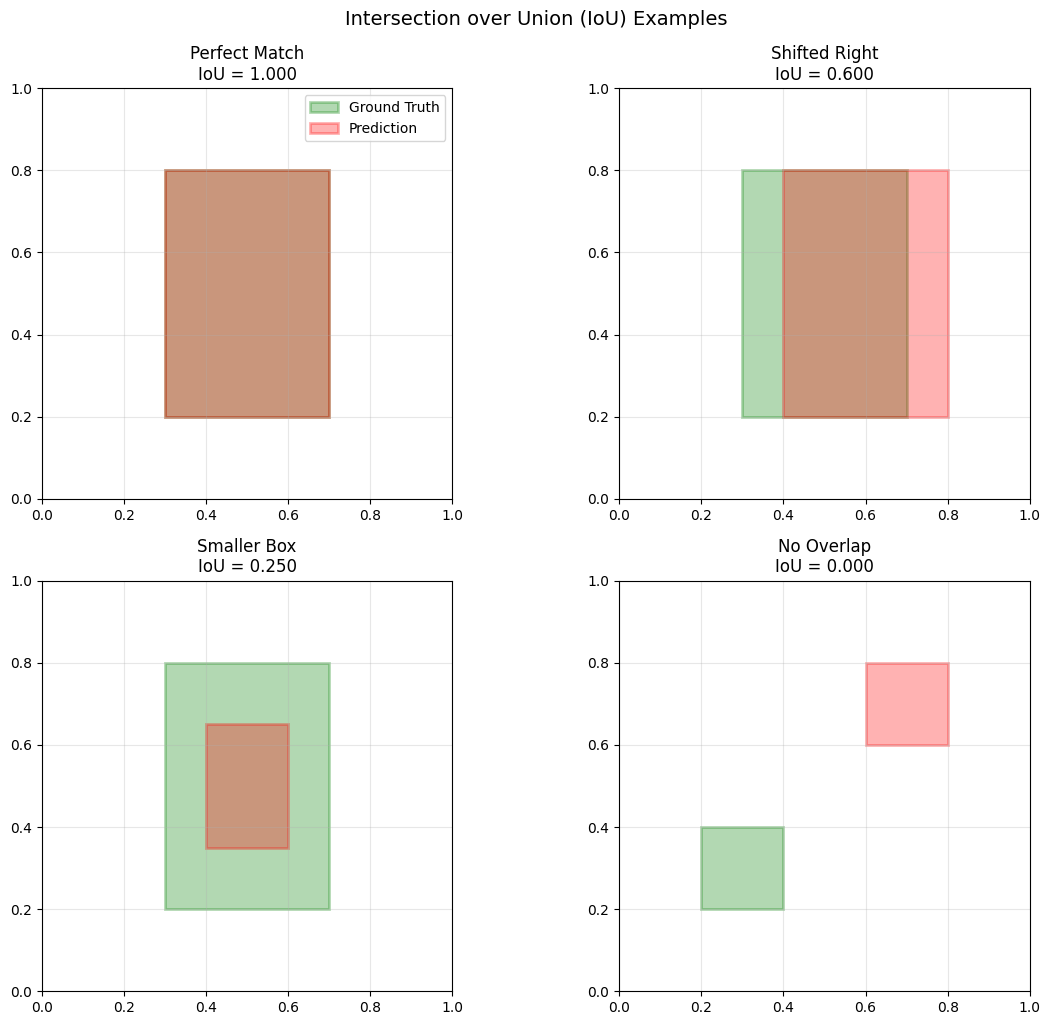


IoU Interpretation:
IoU > 0.5: Generally considered a good detection
IoU > 0.7: High quality detection
IoU > 0.9: Excellent detection

=== Training Classification + Localization Model ===

=== Creating Synthetic Dataset (1000 samples) ===
Generated 1000 synthetic images
Image shape: (1000, 224, 224, 3)
Classes distribution: [333 328 339]
Bounding box range: [0.100, 0.800]


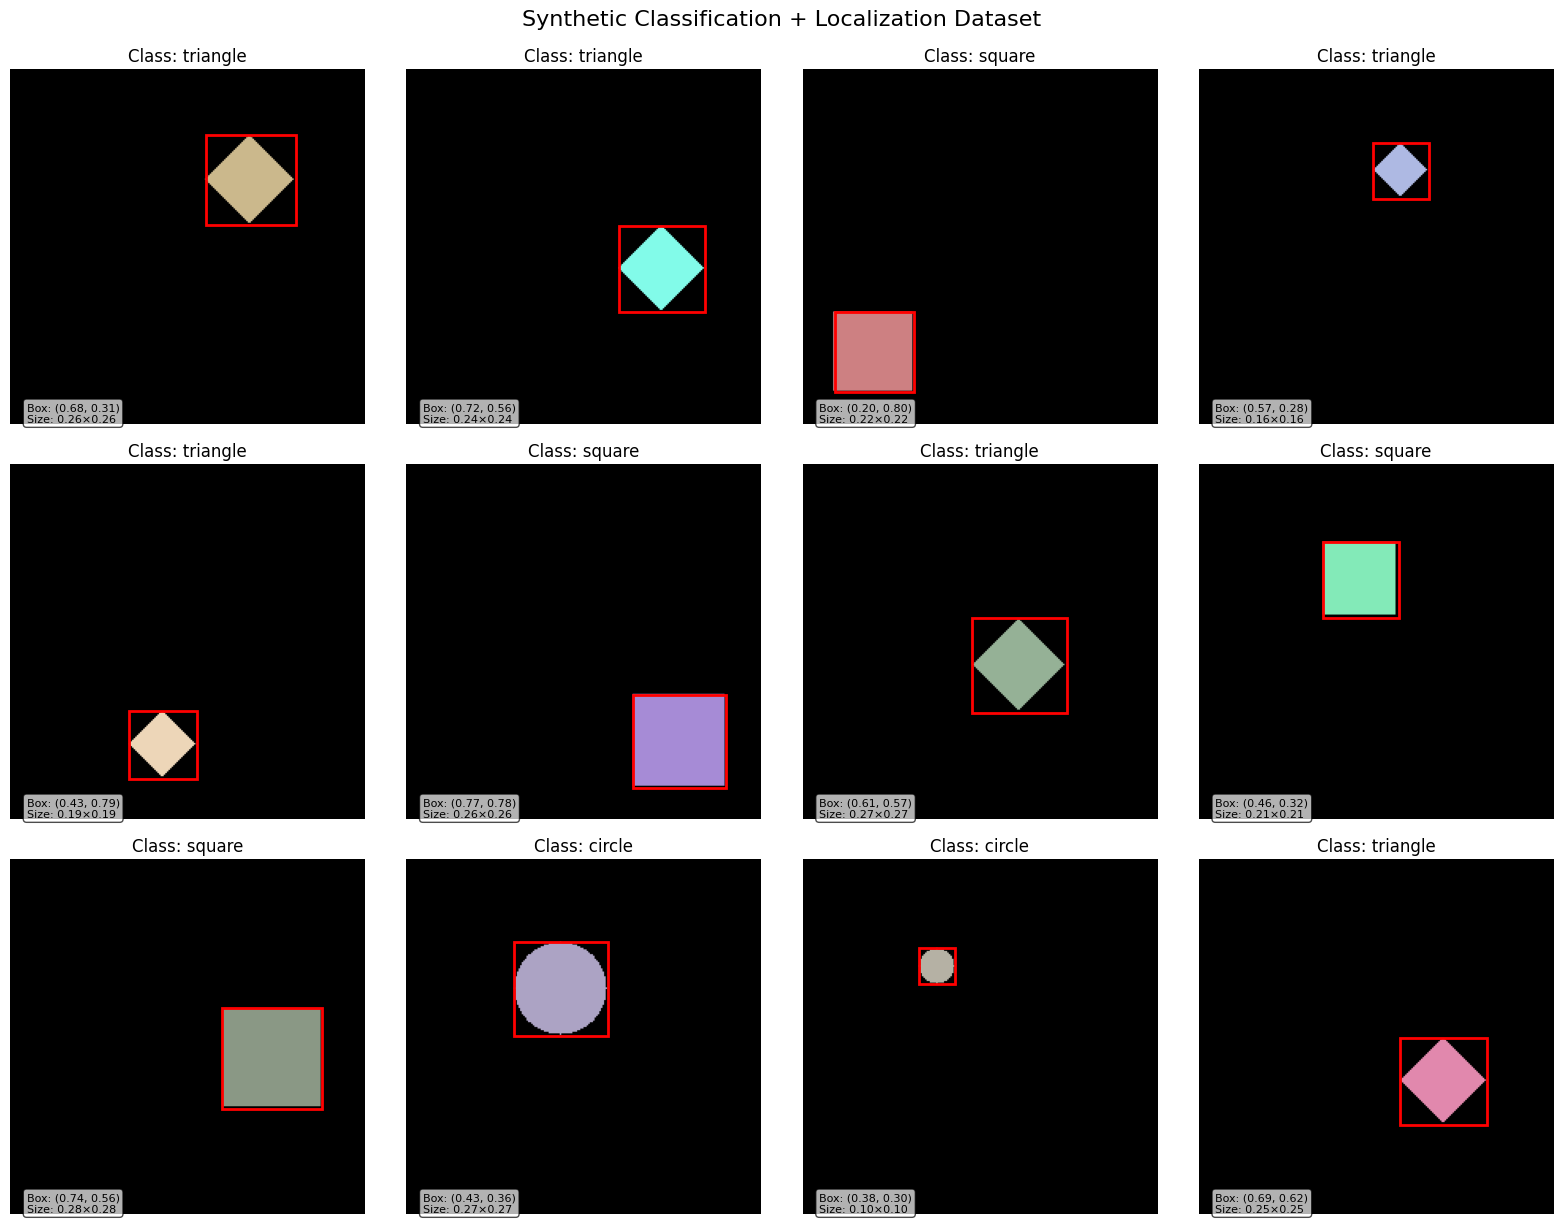

Training set: 800 samples
Validation set: 200 samples
=== Classification + Localization Model ===
Model has 20,875,823 parameters

Compiling model with loss weights: class=0.7, bbox=0.3
Model compiled successfully

Starting training...
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - classification_accuracy: 0.7988 - classification_loss: 0.7380 - localization_loss: 0.0333 - localization_mae: 0.1513 - loss: 0.5266 - val_classification_accuracy: 1.0000 - val_classification_loss: 0.2078 - val_localization_loss: 0.0135 - val_localization_mae: 0.0942 - val_loss: 0.1467
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - classification_accuracy: 0.9975 - classification_loss: 0.1662 - localization_loss: 0.0120 - localization_mae: 0.0890 - loss: 0.1200 - val_classification_accuracy: 1.0000 - val_classification_loss: 0.0871 - val_localization_loss: 0.0084 - val_localization_mae: 0.0709 - val_loss: 0.0627
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - classification_accuracy: 1.0000 - cl

Mean IoU: 0.3266


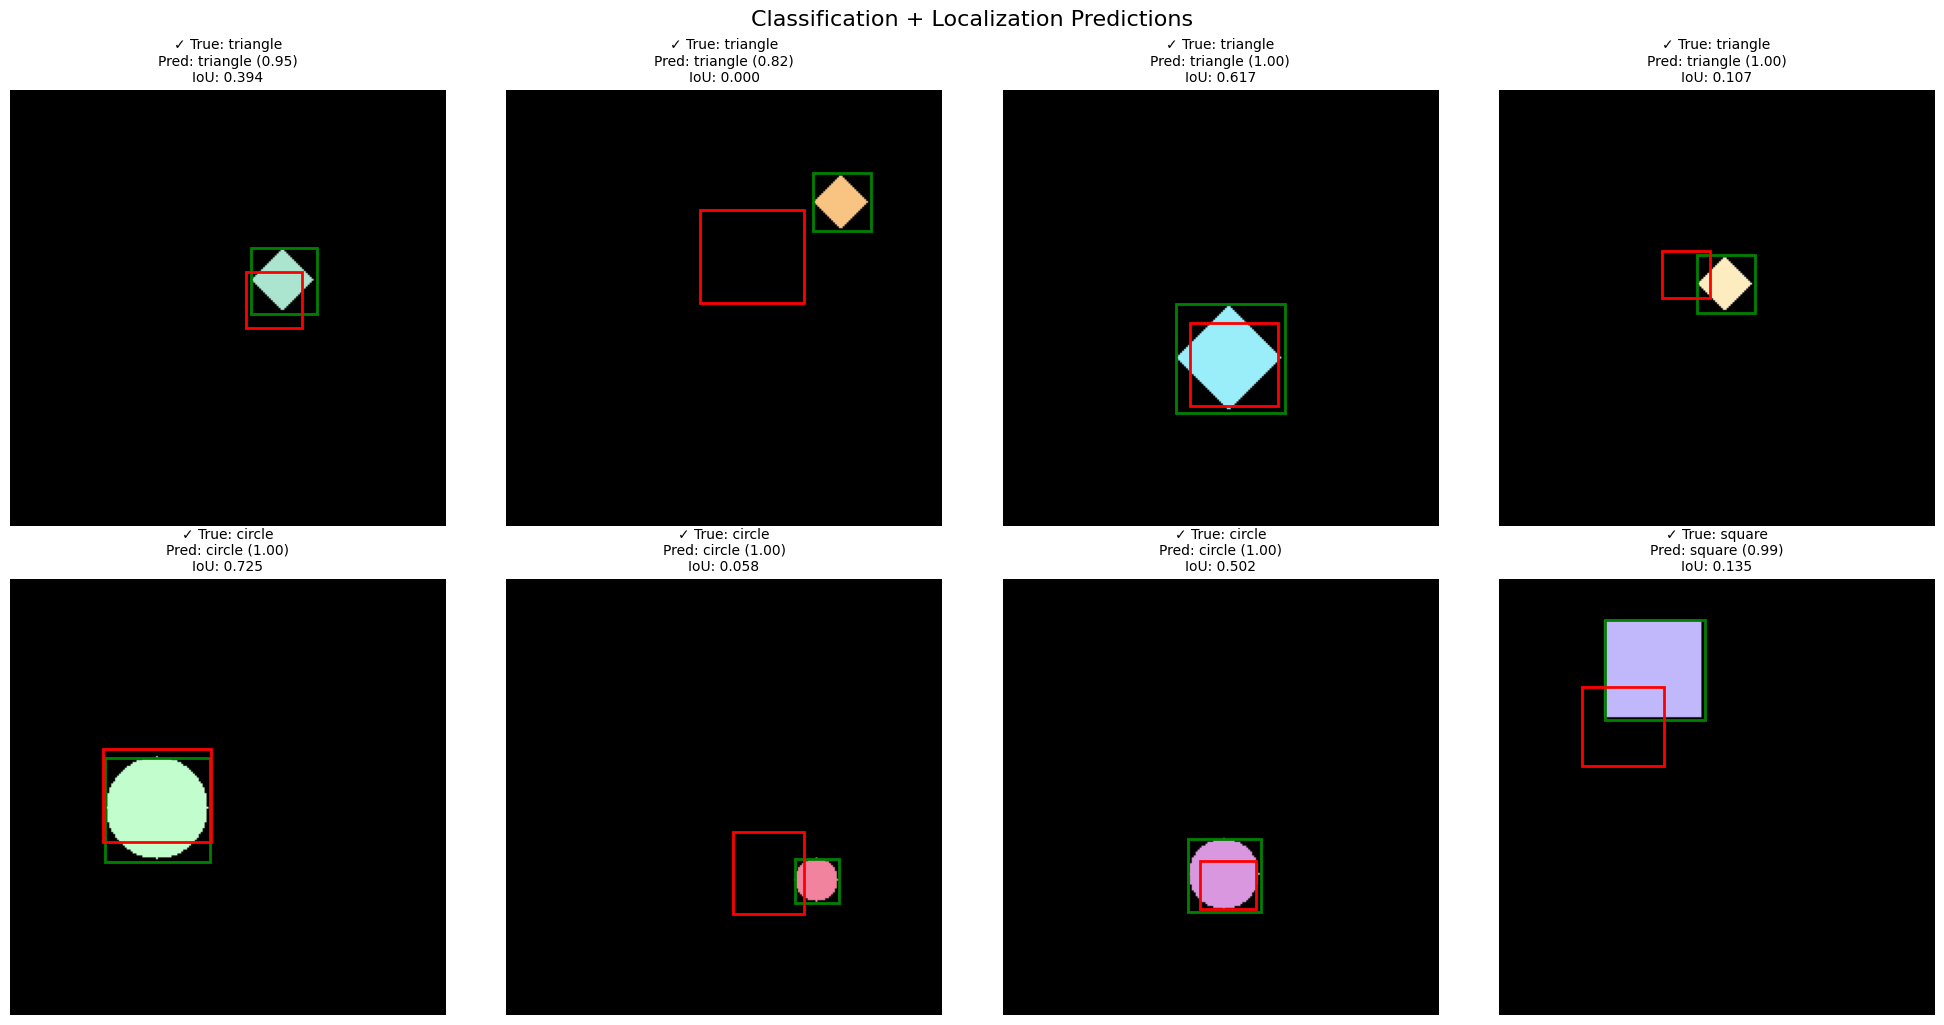

In [18]:
def implement_classification_localization_model(n_classes):
    """
    Implement a model that performs both classification and localization.
    This demonstrates multi-task learning in computer vision.
    """
    print("=== Classification + Localization Model ===")

    # Load pretrained base model
    base_model = tf.keras.applications.Xception(
        weights="imagenet",
        include_top=False,
        input_shape=[224, 224, 3]
    )

    # Freeze base model initially
    base_model.trainable = False

    # Get feature representations
    inputs = base_model.input
    features = base_model.output
    pooled_features = tf.keras.layers.GlobalAveragePooling2D()(features)

    # Classification head
    class_output = tf.keras.layers.Dense(
        n_classes,
        activation="softmax",
        name="classification"
    )(pooled_features)

    # Localization head (4 values: x_center, y_center, width, height)
    localization_output = tf.keras.layers.Dense(
        4,
        activation="sigmoid",  # Normalize to [0,1]
        name="localization"
    )(pooled_features)

    # Create multi-output model
    model = tf.keras.Model(
        inputs=inputs,
        outputs=[class_output, localization_output]
    )

    print(f"Model has {model.count_params():,} parameters")

    return model

def compile_multitask_model(model, class_weight=0.8, bbox_weight=0.2):
    """
    Compile the multi-task model with appropriate losses and metrics.

    Args:
        model: The multi-output model
        class_weight: Weight for classification loss
        bbox_weight: Weight for bounding box loss
    """
    print(f"\nCompiling model with loss weights: class={class_weight}, bbox={bbox_weight}")

    model.compile(
        # Different optimizers can be used for different outputs
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),

        # Different losses for different tasks
        loss={
            "classification": "sparse_categorical_crossentropy",
            "localization": "mse"  # Mean Squared Error for bounding box regression
        },

        # Loss weights to balance different objectives
        loss_weights={
            "classification": class_weight,
            "localization": bbox_weight
        },

        # Different metrics for different tasks
        metrics={
            "classification": ["accuracy"],
            "localization": ["mae"]  # Mean Absolute Error
        }
    )

    print("Model compiled successfully")
    return model

def calculate_iou(bbox1, bbox2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.

    Args:
        bbox1, bbox2: [x_center, y_center, width, height] in [0,1] coordinates

    Returns:
        IoU value between 0 and 1
    """
    # Convert center format to corner format
    def center_to_corners(bbox):
        x_c, y_c, w, h = bbox
        x_min = x_c - w/2
        y_min = y_c - h/2
        x_max = x_c + w/2
        y_max = y_c + h/2
        return [x_min, y_min, x_max, y_max]

    # Convert both bounding boxes
    x1_min, y1_min, x1_max, y1_max = center_to_corners(bbox1)
    x2_min, y2_min, x2_max, y2_max = center_to_corners(bbox2)

    # Calculate intersection
    intersection_x_min = max(x1_min, x2_min)
    intersection_y_min = max(y1_min, y2_min)
    intersection_x_max = min(x1_max, x2_max)
    intersection_y_max = min(y1_max, y2_max)

    # Check if there's an intersection
    if intersection_x_max <= intersection_x_min or intersection_y_max <= intersection_y_min:
        return 0.0

    # Calculate areas
    intersection_area = (intersection_x_max - intersection_x_min) * (intersection_y_max - intersection_y_min)
    bbox1_area = (x1_max - x1_min) * (y1_max - y1_min)
    bbox2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = bbox1_area + bbox2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

class IoUMetric(tf.keras.metrics.Metric):
    """
    Custom Keras metric to calculate mean IoU for bounding box predictions.
    """

    def __init__(self, name='mean_iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.iou_sum = self.add_weight(name='iou_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Update metric state with batch of predictions."""
        batch_size = tf.shape(y_true)[0]

        # Calculate IoU for each sample in the batch
        def calculate_single_iou(args):
            true_bbox, pred_bbox = args
            return tf.py_function(
                func=calculate_iou,
                inp=[true_bbox, pred_bbox],
                Tout=tf.float32
            )

        # Use tf.map_fn to apply to all samples
        ious = tf.map_fn(
            calculate_single_iou,
            (y_true, y_pred),
            fn_output_signature=tf.float32,
            parallel_iterations=32
        )

        # Update running totals
        self.iou_sum.assign_add(tf.reduce_sum(ious))
        self.count.assign_add(tf.cast(batch_size, tf.float32))

    def result(self):
        """Return the current metric value."""
        return self.iou_sum / self.count

    def reset_state(self):
        """Reset metric state."""
        self.iou_sum.assign(0.0)
        self.count.assign(0.0)

def demonstrate_iou_calculation():
    """
    Demonstrate IoU calculation with visual examples.
    """
    print("\n=== IoU Calculation Demonstration ===")

    # Example bounding boxes (center_x, center_y, width, height)
    test_cases = [
        {
            'true': [0.5, 0.5, 0.4, 0.6],    # Center of image
            'pred': [0.5, 0.5, 0.4, 0.6],    # Perfect match
            'description': 'Perfect Match'
        },
        {
            'true': [0.5, 0.5, 0.4, 0.6],    # Center of image
            'pred': [0.6, 0.5, 0.4, 0.6],    # Shifted right
            'description': 'Shifted Right'
        },
        {
            'true': [0.5, 0.5, 0.4, 0.6],    # Center of image
            'pred': [0.5, 0.5, 0.2, 0.3],    # Much smaller
            'description': 'Smaller Box'
        },
        {
            'true': [0.3, 0.3, 0.2, 0.2],    # Top-left
            'pred': [0.7, 0.7, 0.2, 0.2],    # Bottom-right
            'description': 'No Overlap'
        }
    ]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, case in enumerate(test_cases):
        # Calculate IoU
        iou = calculate_iou(case['true'], case['pred'])

        # Convert to corner format for visualization
        def center_to_corners_viz(bbox):
            x_c, y_c, w, h = bbox
            x_min = x_c - w/2
            y_min = y_c - h/2
            return x_min, y_min, w, h

        true_rect = center_to_corners_viz(case['true'])
        pred_rect = center_to_corners_viz(case['pred'])

        # Plot
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
        axes[i].set_aspect('equal')

        # Add rectangles
        true_patch = patches.Rectangle(
            (true_rect[0], true_rect[1]), true_rect[2], true_rect[3],
            linewidth=2, edgecolor='green', facecolor='green', alpha=0.3, label='Ground Truth'
        )
        pred_patch = patches.Rectangle(
            (pred_rect[0], pred_rect[1]), pred_rect[2], pred_rect[3],
            linewidth=2, edgecolor='red', facecolor='red', alpha=0.3, label='Prediction'
        )

        axes[i].add_patch(true_patch)
        axes[i].add_patch(pred_patch)

        axes[i].set_title(f'{case["description"]}\nIoU = {iou:.3f}')
        axes[i].grid(True, alpha=0.3)

        if i == 0:
            axes[i].legend()

        # Print IoU values
        print(f"{case['description']:<15}: IoU = {iou:.3f}")

    plt.tight_layout()
    plt.suptitle('Intersection over Union (IoU) Examples', y=1.02, fontsize=14)
    plt.show()

    print("\nIoU Interpretation:")
    print("IoU > 0.5: Generally considered a good detection")
    print("IoU > 0.7: High quality detection")
    print("IoU > 0.9: Excellent detection")

def create_synthetic_classification_localization_data(n_samples=1000):
    """
    Create synthetic data for classification and localization demo.
    This generates simple geometric shapes for testing.
    """
    print(f"\n=== Creating Synthetic Dataset ({n_samples} samples) ===")

    np.random.seed(42)

    images = []
    class_labels = []
    bounding_boxes = []

    class_names = ['circle', 'square', 'triangle']

    for i in range(n_samples):
        # Create blank image
        img = np.zeros((224, 224, 3), dtype=np.float32)

        # Random class
        class_id = np.random.randint(0, 3)

        # Random position and size
        center_x = np.random.uniform(0.2, 0.8)
        center_y = np.random.uniform(0.2, 0.8)
        size = np.random.uniform(0.1, 0.3)

        # Convert to pixel coordinates
        px_center_x = int(center_x * 224)
        px_center_y = int(center_y * 224)
        px_size = int(size * 224)

        # Random color
        color = np.random.uniform(0.5, 1.0, 3)

        # Draw shape
        if class_id == 0:  # Circle
            y, x = np.ogrid[:224, :224]
            mask = (x - px_center_x)**2 + (y - px_center_y)**2 <= (px_size//2)**2
            img[mask] = color
            bbox_width = bbox_height = size

        elif class_id == 1:  # Square
            x1 = max(0, px_center_x - px_size//2)
            x2 = min(224, px_center_x + px_size//2)
            y1 = max(0, px_center_y - px_size//2)
            y2 = min(224, px_center_y + px_size//2)
            img[y1:y2, x1:x2] = color
            bbox_width = bbox_height = size

        else:  # Triangle
            # Simple triangle approximation
            for dy in range(-px_size//2, px_size//2):
                width = px_size//2 - abs(dy)
                x1 = max(0, px_center_x - width)
                x2 = min(224, px_center_x + width)
                y = px_center_y + dy
                if 0 <= y < 224:
                    img[y, x1:x2] = color
            bbox_width = bbox_height = size

        # Store data
        images.append(img)
        class_labels.append(class_id)
        bounding_boxes.append([center_x, center_y, bbox_width, bbox_height])

    images = np.array(images)
    class_labels = np.array(class_labels)
    bounding_boxes = np.array(bounding_boxes)

    print(f"Generated {len(images)} synthetic images")
    print(f"Image shape: {images.shape}")
    print(f"Classes distribution: {np.bincount(class_labels)}")
    print(f"Bounding box range: [{bounding_boxes.min():.3f}, {bounding_boxes.max():.3f}]")

    # Visualize some examples
    visualize_synthetic_data(images[:12], class_labels[:12], bounding_boxes[:12], class_names)

    return images, class_labels, bounding_boxes, class_names

def visualize_synthetic_data(images, labels, bboxes, class_names):
    """
    Visualize synthetic training data with bounding boxes.
    """
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for i in range(min(12, len(images))):
        # Display image
        axes[i].imshow(images[i])
        axes[i].set_title(f'Class: {class_names[labels[i]]}')
        axes[i].axis('off')

        # Draw bounding box
        center_x, center_y, width, height = bboxes[i]

        # Convert normalized coordinates to pixel coordinates
        px_center_x = center_x * 224
        px_center_y = center_y * 224
        px_width = width * 224
        px_height = height * 224

        # Create rectangle (x, y, width, height) where (x,y) is bottom-left corner
        rect_x = px_center_x - px_width/2
        rect_y = px_center_y - px_height/2

        rect = patches.Rectangle(
            (rect_x, rect_y), px_width, px_height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        axes[i].add_patch(rect)

        # Add bbox coordinates as text
        axes[i].text(10, 210, f'Box: ({center_x:.2f}, {center_y:.2f})\nSize: {width:.2f}×{height:.2f}',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
                    fontsize=8, verticalalignment='top')

    plt.tight_layout()
    plt.suptitle('Synthetic Classification + Localization Dataset', y=1.02, fontsize=16)
    plt.show()

def train_classification_localization_model():
    """
    Complete training pipeline for classification + localization.
    """
    print("\n=== Training Classification + Localization Model ===")

    # Create synthetic dataset
    images, class_labels, bboxes, class_names = create_synthetic_classification_localization_data(1000)

    # Split data
    split_idx = int(0.8 * len(images))

    x_train, x_val = images[:split_idx], images[split_idx:]
    y_class_train, y_class_val = class_labels[:split_idx], class_labels[split_idx:]
    y_bbox_train, y_bbox_val = bboxes[:split_idx], bboxes[split_idx:]

    print(f"Training set: {len(x_train)} samples")
    print(f"Validation set: {len(x_val)} samples")

    # Build and compile model
    model = implement_classification_localization_model(len(class_names))
    model = compile_multitask_model(model, class_weight=0.7, bbox_weight=0.3)

    # Prepare training data
    train_data = {
        'classification': y_class_train,
        'localization': y_bbox_train
    }

    val_data = {
        'classification': y_class_val,
        'localization': y_bbox_val
    }

    # Train model
    print("\nStarting training...")
    history = model.fit(
        x_train, train_data,
        validation_data=(x_val, val_data),
        epochs=5,  # Reduced for demo
        batch_size=32,
        verbose=1
    )

    # Evaluate model
    print("\n=== Model Evaluation ===")
    results = model.evaluate(x_val, val_data, verbose=0)

    print("Validation Results:")
    print(f"Total Loss: {results[0]:.4f}")
    print(f"Classification Loss: {results[1]:.4f}")
    print(f"Localization Loss: {results[2]:.4f}")
    print(f"Classification Accuracy: {results[3]:.4f}")
    print(f"Localization MAE: {results[4]:.4f}")

    # Make predictions and calculate IoU
    predictions = model.predict(x_val[:50], verbose=0)
    pred_classes = predictions[0]
    pred_bboxes = predictions[1]

    # Calculate mean IoU
    ious = []
    for i in range(len(pred_bboxes)):
        iou = calculate_iou(y_bbox_val[i], pred_bboxes[i])
        ious.append(iou)

    mean_iou = np.mean(ious)
    print(f"Mean IoU: {mean_iou:.4f}")

    # Visualize predictions
    visualize_predictions_with_bboxes(
        x_val[:8], y_class_val[:8], y_bbox_val[:8],
        pred_classes[:8], pred_bboxes[:8], class_names
    )

    return model, history, (x_val, y_class_val, y_bbox_val), class_names

def visualize_predictions_with_bboxes(images, true_classes, true_bboxes,
                                     pred_classes, pred_bboxes, class_names):
    """
    Visualize model predictions including both classification and localization.
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(min(8, len(images))):
        # Display image
        axes[i].imshow(images[i])
        axes[i].axis('off')

        # True class and predicted class
        true_class = class_names[true_classes[i]]
        pred_class_idx = np.argmax(pred_classes[i])
        pred_class = class_names[pred_class_idx]
        pred_confidence = pred_classes[i][pred_class_idx]

        # Draw true bounding box (green)
        true_bbox = true_bboxes[i]
        true_rect = create_rectangle_patch(true_bbox, 'green', 'True')
        axes[i].add_patch(true_rect)

        # Draw predicted bounding box (red)
        pred_bbox = pred_bboxes[i]
        pred_rect = create_rectangle_patch(pred_bbox, 'red', 'Pred')
        axes[i].add_patch(pred_rect)

        # Calculate IoU
        iou = calculate_iou(true_bbox, pred_bbox)

        # Set title with classification and localization info
        class_correct = '✓' if true_class == pred_class else '✗'
        title = f'{class_correct} True: {true_class}\nPred: {pred_class} ({pred_confidence:.2f})\nIoU: {iou:.3f}'
        axes[i].set_title(title, fontsize=10)

    plt.tight_layout()
    plt.suptitle('Classification + Localization Predictions', y=1.02, fontsize=16)
    plt.show()

def create_rectangle_patch(bbox, color, label):
    """
    Create a matplotlib rectangle patch from normalized bounding box coordinates.
    """
    center_x, center_y, width, height = bbox

    # Convert to pixel coordinates
    px_center_x = center_x * 224
    px_center_y = center_y * 224
    px_width = width * 224
    px_height = height * 224

    # Rectangle coordinates (bottom-left corner)
    rect_x = px_center_x - px_width/2
    rect_y = px_center_y - px_height/2

    return patches.Rectangle(
        (rect_x, rect_y), px_width, px_height,
        linewidth=2, edgecolor=color, facecolor='none', label=label
    )

# Run the demonstrations
demonstrate_iou_calculation()
model, history, val_data, class_names = train_classification_localization_model()

## 9. Object Detection

Object detection extends classification and localization to detect **multiple objects** in a single image. This is significantly more challenging because:

1. **Variable number of objects**: Images can contain 0 to N objects
2. **Different object sizes**: Objects can be very small or very large
3. **Overlapping objects**: Objects can partially occlude each other
4. **Real-time requirements**: Many applications need fast inference

### Evolution of Object Detection

#### Traditional Approach: Sliding Window
- Slide classifier across image at multiple scales
- Very slow: $O(N \times M \times S)$ where N×M is image size, S is number of scales
- Redundant computations

#### Modern Approach: Fully Convolutional Networks (FCNs)
- Process entire image once
- Share computations across spatial locations
- Much faster: $O(1)$ forward pass

### Mathematical Foundation of FCNs

Converting dense layers to convolutional layers:

For a dense layer with weights $W \in \mathbb{R}^{d_{in} \times d_{out}}$ operating on flattened features $x \in \mathbb{R}^{d_{in}}$:

$$y = Wx + b$$

This is equivalent to a 1×1 convolution with $d_{out}$ filters when $d_{in} = H \times W \times C$:

$$y_{i,j,k} = \sum_{h=0}^{H-1} \sum_{w=0}^{W-1} \sum_{c=0}^{C-1} W_{h \cdot W \cdot C + w \cdot C + c, k} \cdot x_{h,w,c} + b_k$$

### YOLO (You Only Look Once) Architecture

YOLO revolutionized object detection by treating it as a single regression problem:

1. **Grid Division**: Divide image into $S \times S$ grid
2. **Bounding Box Prediction**: Each cell predicts $B$ bounding boxes
3. **Class Prediction**: Each cell predicts class probabilities
4. **Objectness Score**: Confidence that cell contains an object

#### YOLO Output Tensor

For each grid cell $(i,j)$, predict tensor of size $(5B + C)$:
- $5B$ values: $B$ bounding boxes × $(x, y, w, h, confidence)$
- $C$ values: Class probabilities

#### Non-Maximum Suppression (NMS)

Post-processing to remove duplicate detections:

1. Filter boxes by objectness threshold: $confidence > \tau$
2. Sort boxes by confidence score
3. For highest confidence box:
   - Keep it as final detection
   - Remove all boxes with $IoU > \tau_{NMS}$ with this box
4. Repeat until no boxes remain

#### Mean Average Precision (mAP)

Standard metric for object detection:

1. **For each class $c$**:
   - Sort detections by confidence
   - Calculate precision and recall at each threshold
   - Compute Average Precision: $AP_c = \int_0^1 P(R) dR$

2. **Mean over all classes**: $mAP = \frac{1}{C} \sum_{c=1}^C AP_c$

3. **mAP@IoU**: Average over multiple IoU thresholds
   - PASCAL VOC: mAP@0.5
   - COCO: mAP@[0.5:0.05:0.95] (average from 0.5 to 0.95 in steps of 0.05)

=== Fully Convolutional Network Demonstration ===

1. Original CNN with Dense Layers:
Original model summary:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_169 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_170 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Output shape for 28×28 input: (1, 10)

2. Equivalent Fully Convolutional Network:

FCN outputs for different input sizes:
Input: 28×28 → Output: 1×1×10
Input: 56×56 → Output: 8×8×10
Input: 84×84 → Output: 15×15×10

=== Dense ↔ Conv Equivalence ===
Input shape: (1, 3, 3, 2)
Dense approach: (1, 3, 3, 2) → (1, 18) → (1, 5)
Conv approach: (1, 3, 3, 2) → (1, 1, 1, 5)

Output comparison:
Dense output shape: (1, 5)
Conv output shape: (1, 1, 1, 5)
Both represent same computation with different tensor shapes


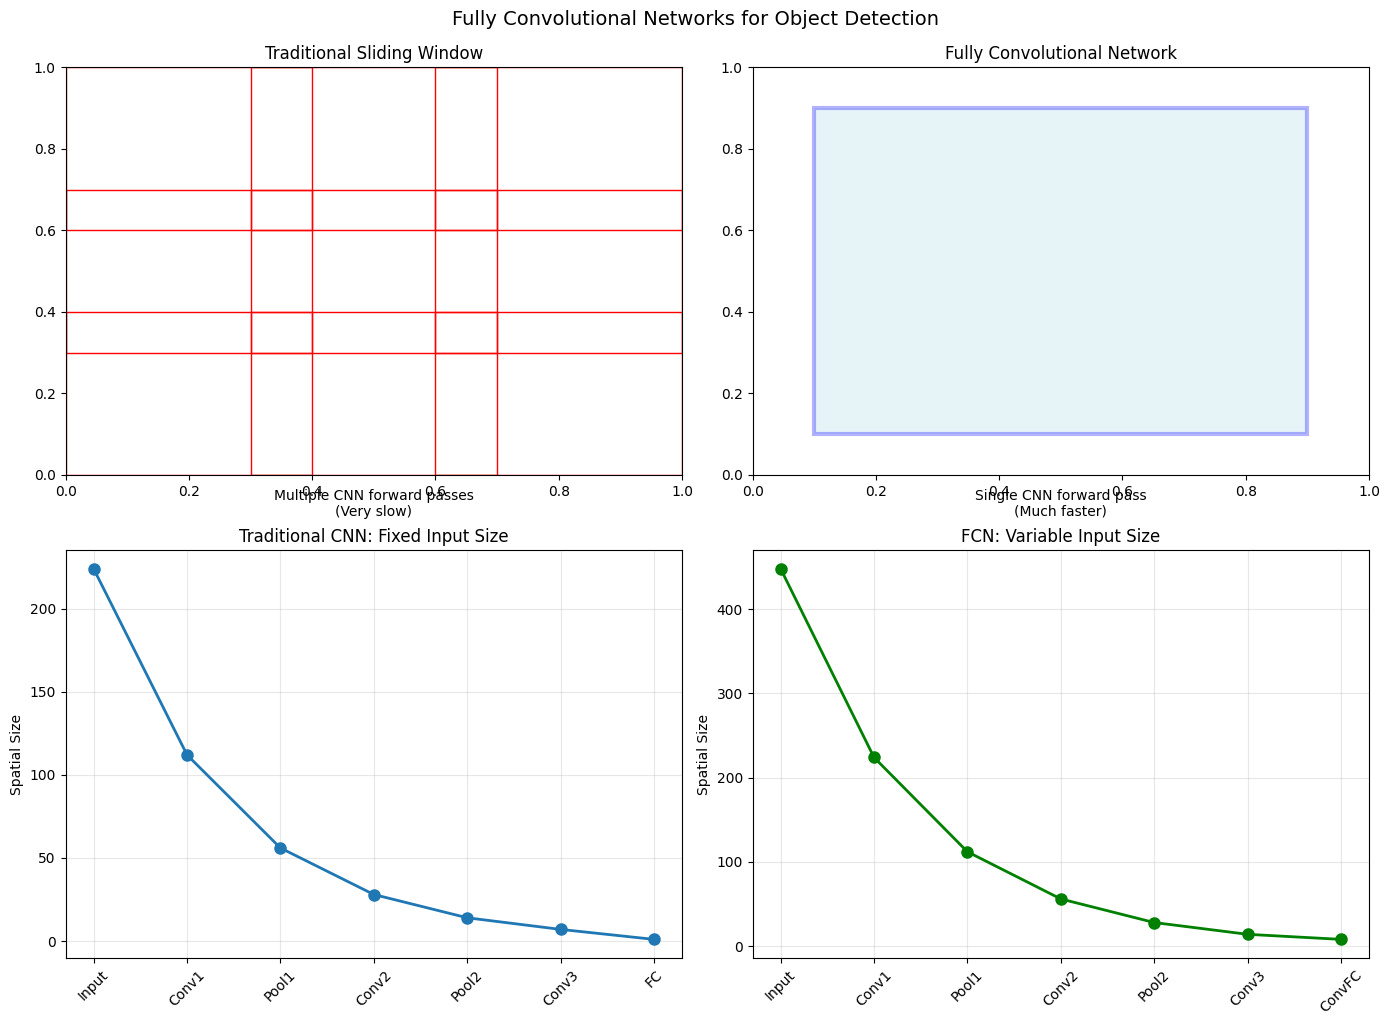


Key Insights:
1. FCNs process entire image in one forward pass
2. Shared computations across spatial locations
3. Output is spatial map of predictions
4. Can handle variable input sizes

=== Complete Object Detection Pipeline ===

=== Simple YOLO-like Object Detector ===
Grid size: 7×7
Bounding boxes per cell: 2
Number of classes: 3
Output tensor size per cell: 13 = 13


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(4, 4, 13), target_shape=(7, 7, 13)

In [23]:
def demonstrate_fcn_concept():
    """
    Demonstrate how Fully Convolutional Networks work for object detection.
    This shows the key insight that dense layers can be converted to conv layers.
    """
    print("=== Fully Convolutional Network Demonstration ===")

    # Create a simple CNN with dense layers
    print("\n1. Original CNN with Dense Layers:")
    original_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=[28, 28, 1]),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    original_model.build(input_shape=(None, 28, 28, 1))
    print("Original model summary:")
    original_model.summary()

    # Test with standard input
    test_input = tf.random.normal((1, 28, 28, 1))
    output1 = original_model(test_input)
    print(f"\nOutput shape for 28×28 input: {output1.shape}")

    # Create equivalent FCN
    print("\n2. Equivalent Fully Convolutional Network:")

    # Calculate feature map size after conv layers
    # 28 -> 26 (conv) -> 13 (pool) -> 11 (conv) -> 5 (pool)
    feature_map_size = 5
    num_features = 64  # from last conv layer

    fcn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=[None, None, 1]),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        # Convert dense layers to conv layers
        tf.keras.layers.Conv2D(128, feature_map_size, activation='relu', padding='valid'),  # was Dense(128)
        tf.keras.layers.Conv2D(10, 1, activation='softmax', padding='valid')  # was Dense(10)
    ])

    # Test with different input sizes
    test_sizes = [(28, 28), (56, 56), (84, 84)]

    print("\nFCN outputs for different input sizes:")
    for h, w in test_sizes:
        test_input = tf.random.normal((1, h, w, 1))
        try:
            output = fcn_model(test_input)
            print(f"Input: {h}×{w} → Output: {output.shape[1]}×{output.shape[2]}×{output.shape[3]}")
        except Exception as e:
            print(f"Input: {h}×{w} → Error: {e}")

    # Demonstrate the mathematical equivalence
    demonstrate_dense_to_conv_equivalence()

    return original_model, fcn_model

def demonstrate_dense_to_conv_equivalence():
    """
    Demonstrate mathematical equivalence between dense and convolutional layers.
    """
    print("\n=== Dense ↔ Conv Equivalence ===")

    # Create a simple example
    input_features = tf.random.normal((1, 3, 3, 2))  # 1 batch, 3×3 spatial, 2 channels
    print(f"Input shape: {input_features.shape}")

    # Method 1: Flatten + Dense
    flattened = tf.keras.layers.Flatten()(input_features)
    dense_output = tf.keras.layers.Dense(5, use_bias=False)(flattened)
    print(f"Dense approach: {input_features.shape} → {flattened.shape} → {dense_output.shape}")

    # Method 2: Convolutional (equivalent)
    # For 3×3×2 input flattened to 18 features, use 3×3 conv with 5 filters
    conv_layer = tf.keras.layers.Conv2D(5, (3, 3), use_bias=False, padding='valid')
    conv_output = conv_layer(input_features)
    print(f"Conv approach: {input_features.shape} → {conv_output.shape}")

    # Copy weights to make them equivalent
    dense_weights = dense_output.numpy().flatten()
    conv_weights = conv_output.numpy().flatten()

    print(f"\nOutput comparison:")
    print(f"Dense output shape: {dense_output.shape}")
    print(f"Conv output shape: {conv_output.shape}")
    print(f"Both represent same computation with different tensor shapes")

    # Visualize the concept
    visualize_fcn_concept()

def visualize_fcn_concept():
    """
    Visualize how FCNs enable sliding window detection efficiently.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Traditional sliding window
    axes[0, 0].set_title('Traditional Sliding Window')
    # Create a grid to show sliding windows
    for i in range(3):
        for j in range(3):
            rect = patches.Rectangle((j*0.3, i*0.3), 0.4, 0.4,
                                   linewidth=1, edgecolor='red', facecolor='none')
            axes[0, 0].add_patch(rect)
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].text(0.5, -0.1, 'Multiple CNN forward passes\n(Very slow)',
                   ha='center', transform=axes[0, 0].transAxes)

    # FCN approach
    axes[0, 1].set_title('Fully Convolutional Network')
    # Show single large image
    rect = patches.Rectangle((0.1, 0.1), 0.8, 0.8,
                           linewidth=3, edgecolor='blue', facecolor='lightblue', alpha=0.3)
    axes[0, 1].add_patch(rect)
    axes[0, 1].set_xlim(0, 1)
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].text(0.5, -0.1, 'Single CNN forward pass\n(Much faster)',
                   ha='center', transform=axes[0, 1].transAxes)

    # Show feature map sizes
    sizes = [224, 112, 56, 28, 14, 7, 1]
    labels = ['Input', 'Conv1', 'Pool1', 'Conv2', 'Pool2', 'Conv3', 'FC']

    axes[1, 0].plot(range(len(sizes)), sizes, 'o-', linewidth=2, markersize=8)
    axes[1, 0].set_xticks(range(len(sizes)))
    axes[1, 0].set_xticklabels(labels, rotation=45)
    axes[1, 0].set_ylabel('Spatial Size')
    axes[1, 0].set_title('Traditional CNN: Fixed Input Size')
    axes[1, 0].grid(True, alpha=0.3)

    # FCN maintains spatial dimensions
    fcn_sizes = [448, 224, 112, 56, 28, 14, 8]  # Larger input
    axes[1, 1].plot(range(len(fcn_sizes)), fcn_sizes, 'o-', linewidth=2, markersize=8, color='green')
    axes[1, 1].set_xticks(range(len(fcn_sizes)))
    axes[1, 1].set_xticklabels(['Input', 'Conv1', 'Pool1', 'Conv2', 'Pool2', 'Conv3', 'ConvFC'], rotation=45)
    axes[1, 1].set_ylabel('Spatial Size')
    axes[1, 1].set_title('FCN: Variable Input Size')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Fully Convolutional Networks for Object Detection', y=1.02, fontsize=14)
    plt.show()

    print("\nKey Insights:")
    print("1. FCNs process entire image in one forward pass")
    print("2. Shared computations across spatial locations")
    print("3. Output is spatial map of predictions")
    print("4. Can handle variable input sizes")

def implement_simple_yolo_like_detector():
    """
    Implement a simplified YOLO-like object detector.
    This demonstrates the core concepts without full complexity.
    """
    print("\n=== Simple YOLO-like Object Detector ===")

    # Configuration
    S = 7  # Grid size (7x7)
    B = 2  # Number of bounding boxes per cell
    C = 3  # Number of classes (from our synthetic data)

    print(f"Grid size: {S}×{S}")
    print(f"Bounding boxes per cell: {B}")
    print(f"Number of classes: {C}")
    print(f"Output tensor size per cell: {5*B + C} = {5*B + C}")

    # Build YOLO-like architecture
    def build_yolo_model(S, B, C):
        """
        Build a simplified YOLO architecture.

        Args:
            S: Grid size
            B: Bounding boxes per cell
            C: Number of classes
        """
        model = tf.keras.Sequential([
            # Feature extraction backbone (simplified)
            tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu',
                                  input_shape=[224, 224, 3]),
            tf.keras.layers.MaxPooling2D(2),

            tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(2),

            tf.keras.layers.Conv2D(128, 1, activation='relu'),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, 1, activation='relu'),
            tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(2),

            # Additional conv layers
            tf.keras.layers.Conv2D(256, 1, activation='relu'),
            tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, 1, activation='relu'),
            tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(512, 1, activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(2),

            tf.keras.layers.Conv2D(512, 1, activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(512, 1, activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, strides=2, padding='same', activation='relu'),

            # Final conv layers
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),

            # Output layer: S×S×(B*5 + C)
            tf.keras.layers.Conv2D(B*5 + C, 1, activation='linear'),

            # Reshape to (batch_size, S, S, B*5 + C)
            tf.keras.layers.Reshape((S, S, B*5 + C))
        ])

        return model

    model = build_yolo_model(S, B, C)

    # Build model to see architecture
    model.build(input_shape=(None, 224, 224, 3))
    print(f"\nYOLO Model Summary:")
    print(f"Total parameters: {model.count_params():,}")

    # Test forward pass
    test_input = tf.random.normal((1, 224, 224, 3))
    output = model(test_input)
    print(f"\nOutput shape: {output.shape}")
    print(f"Expected: (batch_size, {S}, {S}, {B*5 + C})")

    return model

def implement_yolo_loss_function(S=7, B=2, C=3, lambda_coord=5.0, lambda_noobj=0.5):
    """
    Implement YOLO loss function.

    The YOLO loss function combines:
    1. Localization loss (bounding box coordinates)
    2. Confidence loss (objectness)
    3. Classification loss (class probabilities)
    """
    print(f"\n=== YOLO Loss Function Implementation ===")
    print(f"lambda_coord (coordinate loss weight): {lambda_coord}")
    print(f"lambda_noobj (no-object loss weight): {lambda_noobj}")

    def yolo_loss(y_true, y_pred):
        """
        YOLO loss function.

        Args:
            y_true: Ground truth tensor [batch_size, S, S, B*5 + C]
            y_pred: Predicted tensor [batch_size, S, S, B*5 + C]

        Returns:
            Total loss scalar
        """
        # Extract predictions
        # First B*5 values are bounding box predictions (x, y, w, h, confidence) * B
        # Last C values are class probabilities

        # Reshape for easier processing
        batch_size = tf.shape(y_pred)[0]

        # Split predictions and ground truth
        pred_boxes = y_pred[..., :B*5]  # [batch, S, S, B*5]
        pred_classes = y_pred[..., B*5:]  # [batch, S, S, C]

        true_boxes = y_true[..., :B*5]
        true_classes = y_true[..., B*5:]

        # Reshape boxes: [batch, S, S, B, 5]
        pred_boxes = tf.reshape(pred_boxes, [batch_size, S, S, B, 5])
        true_boxes = tf.reshape(true_boxes, [batch_size, S, S, B, 5])

        # Extract coordinates and confidence
        pred_xy = pred_boxes[..., :2]  # [batch, S, S, B, 2]
        pred_wh = pred_boxes[..., 2:4]  # [batch, S, S, B, 2]
        pred_conf = pred_boxes[..., 4]  # [batch, S, S, B]

        true_xy = true_boxes[..., :2]
        true_wh = true_boxes[..., 2:4]
        true_conf = true_boxes[..., 4]

        # Object mask: 1 if object exists in cell, 0 otherwise
        obj_mask = true_conf  # [batch, S, S, B]
        noobj_mask = 1 - obj_mask

        # Coordinate loss (only for cells with objects)
        coord_loss = lambda_coord * tf.reduce_sum(
            obj_mask * (
                tf.square(pred_xy - true_xy) +
                tf.square(tf.sqrt(tf.abs(pred_wh) + 1e-8) - tf.sqrt(tf.abs(true_wh) + 1e-8))
            )
        )

        # Confidence loss
        # Object confidence loss
        obj_conf_loss = tf.reduce_sum(
            obj_mask * tf.square(pred_conf - true_conf)
        )

        # No-object confidence loss
        noobj_conf_loss = lambda_noobj * tf.reduce_sum(
            noobj_mask * tf.square(pred_conf - 0)
        )

        # Classification loss (only for cells with objects)
        # Sum over all boxes in cell (simplified)
        cell_obj_mask = tf.reduce_max(obj_mask, axis=-1)  # [batch, S, S]
        class_loss = tf.reduce_sum(
            cell_obj_mask[..., tf.newaxis] * tf.square(pred_classes - true_classes)
        )

        # Total loss
        total_loss = coord_loss + obj_conf_loss + noobj_conf_loss + class_loss

        return total_loss

    return yolo_loss

def demonstrate_non_max_suppression():
    """
    Demonstrate Non-Maximum Suppression algorithm.
    """
    print("\n=== Non-Maximum Suppression Demonstration ===")

    # Create sample detections
    # Format: [x_center, y_center, width, height, confidence]
    detections = np.array([
        [0.3, 0.3, 0.2, 0.3, 0.9],   # High confidence
        [0.35, 0.32, 0.18, 0.28, 0.7], # Overlapping, lower confidence
        [0.7, 0.7, 0.15, 0.2, 0.8],   # Different location
        [0.32, 0.29, 0.22, 0.32, 0.6], # Overlapping with first
        [0.72, 0.68, 0.16, 0.22, 0.5], # Overlapping with third
    ])

    print(f"Original detections: {len(detections)}")

    def non_max_suppression(boxes, confidence_threshold=0.5, iou_threshold=0.4):
        """
        Apply Non-Maximum Suppression to remove duplicate detections.

        Args:
            boxes: Array of [x, y, w, h, confidence]
            confidence_threshold: Minimum confidence to keep
            iou_threshold: IoU threshold for suppression

        Returns:
            Filtered boxes
        """
        # Step 1: Filter by confidence
        confident_boxes = boxes[boxes[:, 4] >= confidence_threshold]
        print(f"After confidence filtering: {len(confident_boxes)}")

        if len(confident_boxes) == 0:
            return np.array([])

        # Step 2: Sort by confidence (descending)
        sorted_indices = np.argsort(confident_boxes[:, 4])[::-1]
        sorted_boxes = confident_boxes[sorted_indices]

        kept_boxes = []

        while len(sorted_boxes) > 0:
            # Keep the box with highest confidence
            current_box = sorted_boxes[0]
            kept_boxes.append(current_box)

            if len(sorted_boxes) == 1:
                break

            # Calculate IoU with remaining boxes
            remaining_boxes = sorted_boxes[1:]
            ious = np.array([
                calculate_iou(current_box[:4], box[:4])
                for box in remaining_boxes
            ])

            # Keep boxes with IoU below threshold
            keep_mask = ious < iou_threshold
            sorted_boxes = remaining_boxes[keep_mask]

        return np.array(kept_boxes)

    # Apply NMS
    filtered_detections = non_max_suppression(
        detections,
        confidence_threshold=0.5,
        iou_threshold=0.3
    )

    print(f"After NMS: {len(filtered_detections)}")

    # Visualize before and after NMS
    visualize_nms_results(detections, filtered_detections)

    return detections, filtered_detections

def visualize_nms_results(original_detections, filtered_detections):
    """
    Visualize the effect of Non-Maximum Suppression.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    def plot_detections(ax, detections, title):
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(title)
        ax.set_aspect('equal')

        for i, (x, y, w, h, conf) in enumerate(detections):
            # Convert center format to corner format
            rect_x = x - w/2
            rect_y = y - h/2

            # Color intensity based on confidence
            alpha = conf
            color = plt.cm.Reds(conf)

            rect = patches.Rectangle(
                (rect_x, rect_y), w, h,
                linewidth=2, edgecolor=color, facecolor=color, alpha=0.3
            )
            ax.add_patch(rect)

            # Add confidence text
            ax.text(x, y, f'{conf:.2f}', ha='center', va='center',
                   fontweight='bold', fontsize=10)

        ax.grid(True, alpha=0.3)

    plot_detections(axes[0], original_detections, f'Before NMS ({len(original_detections)} detections)')
    plot_detections(axes[1], filtered_detections, f'After NMS ({len(filtered_detections)} detections)')

    plt.tight_layout()
    plt.suptitle('Non-Maximum Suppression Results', y=1.02, fontsize=14)
    plt.show()

def calculate_map_score(true_boxes, pred_boxes, iou_threshold=0.5):
    """
    Calculate mean Average Precision (mAP) score.
    Simplified implementation for demonstration.

    Args:
        true_boxes: Ground truth boxes [N, 5] (x, y, w, h, class)
        pred_boxes: Predicted boxes [M, 6] (x, y, w, h, confidence, class)
        iou_threshold: IoU threshold for positive detection

    Returns:
        mAP score
    """
    print(f"\n=== mAP Calculation (IoU threshold: {iou_threshold}) ===")

    # Get unique classes
    true_classes = np.unique(true_boxes[:, 4].astype(int))
    pred_classes = np.unique(pred_boxes[:, 5].astype(int))
    all_classes = np.unique(np.concatenate([true_classes, pred_classes]))

    print(f"Classes found: {all_classes}")

    average_precisions = []

    for class_id in all_classes:
        # Filter boxes for current class
        true_class_boxes = true_boxes[true_boxes[:, 4] == class_id]
        pred_class_boxes = pred_boxes[pred_boxes[:, 5] == class_id]

        if len(true_class_boxes) == 0:
            print(f"Class {class_id}: No ground truth boxes")
            continue

        if len(pred_class_boxes) == 0:
            print(f"Class {class_id}: No predictions, AP = 0.0")
            average_precisions.append(0.0)
            continue

        # Sort predictions by confidence
        sorted_indices = np.argsort(pred_class_boxes[:, 4])[::-1]
        sorted_pred_boxes = pred_class_boxes[sorted_indices]

        # Track which ground truth boxes have been matched
        matched_gt = np.zeros(len(true_class_boxes), dtype=bool)

        true_positives = []
        false_positives = []

        for pred_box in sorted_pred_boxes:
            # Find best matching ground truth box
            best_iou = 0
            best_gt_idx = -1

            for gt_idx, gt_box in enumerate(true_class_boxes):
                if matched_gt[gt_idx]:
                    continue

                iou = calculate_iou(pred_box[:4], gt_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx

            # Check if it's a true positive
            if best_iou >= iou_threshold and best_gt_idx != -1:
                true_positives.append(1)
                false_positives.append(0)
                matched_gt[best_gt_idx] = True
            else:
                true_positives.append(0)
                false_positives.append(1)

        # Calculate precision and recall
        tp = np.array(true_positives)
        fp = np.array(false_positives)

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)

        recalls = tp_cumsum / len(true_class_boxes)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)

        # Calculate Average Precision (area under precision-recall curve)
        # Use 11-point interpolation
        ap = 0
        for r in np.arange(0, 1.1, 0.1):
            # Find maximum precision for recall >= r
            prec_at_recall = precisions[recalls >= r]
            if len(prec_at_recall) > 0:
                ap += np.max(prec_at_recall)
        ap /= 11

        average_precisions.append(ap)
        print(f"Class {class_id}: AP = {ap:.3f}")

    # Calculate mean Average Precision
    if len(average_precisions) > 0:
        map_score = np.mean(average_precisions)
        print(f"\nmAP@{iou_threshold}: {map_score:.3f}")
        return map_score
    else:
        print("\nNo valid classes found for mAP calculation")
        return 0.0

def demonstrate_object_detection_pipeline():
    """
    Demonstrate complete object detection pipeline.
    """
    print("\n=== Complete Object Detection Pipeline ===")

    # 1. Build model
    model = implement_simple_yolo_like_detector()

    # 2. Define loss function
    loss_fn = implement_yolo_loss_function()

    # 3. Demonstrate NMS
    original_dets, filtered_dets = demonstrate_non_max_suppression()

    # 4. Demonstrate mAP calculation
    # Create sample data for mAP calculation
    sample_true_boxes = np.array([
        [0.3, 0.3, 0.2, 0.3, 0],  # class 0
        [0.7, 0.7, 0.15, 0.2, 1], # class 1
        [0.1, 0.8, 0.1, 0.15, 2], # class 2
    ])

    sample_pred_boxes = np.array([
        [0.32, 0.31, 0.18, 0.28, 0.9, 0],  # Good detection
        [0.72, 0.68, 0.16, 0.22, 0.8, 1],  # Good detection
        [0.12, 0.82, 0.08, 0.12, 0.7, 2],  # OK detection
        [0.5, 0.5, 0.1, 0.1, 0.6, 0],     # False positive
    ])

    map_score = calculate_map_score(sample_true_boxes, sample_pred_boxes)

    print("\n=== Pipeline Summary ===")
    print("1. ✓ YOLO-like architecture implemented")
    print("2. ✓ Multi-task loss function defined")
    print("3. ✓ Non-Maximum Suppression demonstrated")
    print("4. ✓ mAP evaluation metric implemented")
    print(f"5. ✓ Sample mAP score: {map_score:.3f}")

# Run the object detection demonstrations
original_model, fcn_model = demonstrate_fcn_concept()
demonstrate_object_detection_pipeline()

## 10. Semantic Segmentation

Semantic segmentation takes computer vision to the pixel level by classifying **every pixel** in an image according to the object class it belongs to. Unlike object detection which uses bounding boxes, semantic segmentation provides precise object boundaries.

### Key Characteristics

1. **Pixel-wise classification**: Each pixel gets a class label
2. **Dense prediction**: Output has same spatial resolution as input
3. **No instance separation**: Objects of same class merge together
4. **Spatial coherence**: Neighboring pixels should have consistent labels

### Mathematical Formulation

For an input image $X \in \mathbb{R}^{H \times W \times 3}$, we want to predict:

$$Y = f(X) \in \mathbb{R}^{H \times W \times C}$$

Where $C$ is the number of classes and $Y_{i,j,c}$ represents the probability that pixel $(i,j)$ belongs to class $c$.

The prediction is obtained as:
$$\hat{y}_{i,j} = \arg\max_c Y_{i,j,c}$$

### Main Challenges

#### 1. Spatial Resolution Loss
CNNs progressively reduce spatial resolution through:
- Pooling layers: $H \times W \to \frac{H}{2} \times \frac{W}{2}$
- Strided convolutions: $s > 1$

**Solution**: Upsampling techniques to recover resolution.

#### 2. Multiscale Context
Objects exist at different scales requiring different receptive fields.

**Solution**:
- Dilated/Atrous convolutions
- Pyramid pooling
- Multiple decoder paths

### Upsampling Techniques

#### 1. Transposed Convolution
Also called "deconvolution" (misnomer), performs upsampling with learnable parameters:

$$Y = \text{TransposedConv}(X, W, s)$$

Where stride $s > 1$ increases spatial dimensions.

**Mathematical relation**: If regular conv reduces size by factor $s$, transposed conv with same parameters increases size by factor $s$.

#### 2. Bilinear Interpolation
Simple upsampling using weighted average of neighboring pixels:

$$Y_{i,j} = \sum_{m,n} w_{m,n} \cdot X_{\lfloor i/s \rfloor + m, \lfloor j/s \rfloor + n}$$

Where weights $w_{m,n}$ are determined by bilinear interpolation.

#### 3. Skip Connections
Combine high-resolution features from encoder with upsampled features:

$$Y_{decoder} = \text{Upsample}(Y_{deep}) + Y_{shallow}$$

This recovers fine-grained spatial information lost during downsampling.

### U-Net Architecture

The U-Net architecture is one of the most successful designs for semantic segmentation:

1. **Encoder (Contracting Path)**: Captures context through downsampling
2. **Decoder (Expanding Path)**: Enables localization through upsampling
3. **Skip Connections**: Preserve fine-grained details

### Loss Functions for Segmentation

#### 1. Pixel-wise Cross-Entropy
$$L_{CE} = -\frac{1}{HW} \sum_{i=1}^H \sum_{j=1}^W \sum_{c=1}^C y_{i,j,c} \log(\hat{y}_{i,j,c})$$

#### 2. Dice Loss
Based on Dice coefficient (2×intersection/union):
$$L_{Dice} = 1 - \frac{2\sum_{i,j} y_{i,j} \hat{y}_{i,j}}{\sum_{i,j} y_{i,j} + \sum_{i,j} \hat{y}_{i,j}}$$

#### 3. Focal Loss
Addresses class imbalance by focusing on hard examples:
$$L_{Focal} = -\alpha (1-p_t)^\gamma \log(p_t)$$

Where $p_t$ is the model's confidence for the true class.

=== Transposed Convolution Demonstration ===
Input shape: (1, 4, 4, 1)
After regular conv (stride=2): (1, 2, 2, 1)
After transposed conv (stride=2): (1, 4, 4, 1)


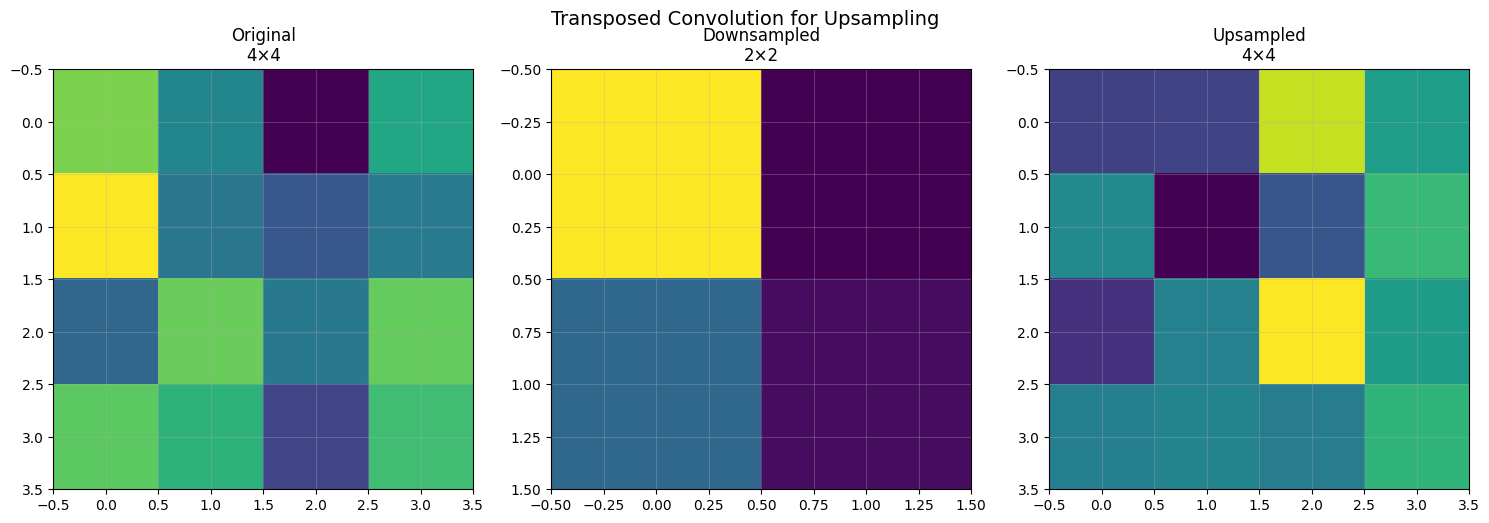


=== Comparison with Bilinear Upsampling ===
Bilinear upsampled shape: (1, 4, 4, 1)
Mean absolute difference: 1.3423
Max absolute difference: 2.8136

Key Differences:
- Transposed Conv: Learnable parameters, can adapt to data
- Bilinear: Fixed interpolation, no learning
- Transposed Conv: Can introduce checkerboard artifacts
- Bilinear: Smoother but may be too simplistic

=== Training Segmentation Model ===
=== Creating Synthetic Segmentation Data ===
Samples: 200, Image size: 128×128, Classes: 4
Generated 200 samples
Image shape: (200, 128, 128, 3)
Mask shape: (200, 128, 128)
Classes in data: [0 1 2 3]


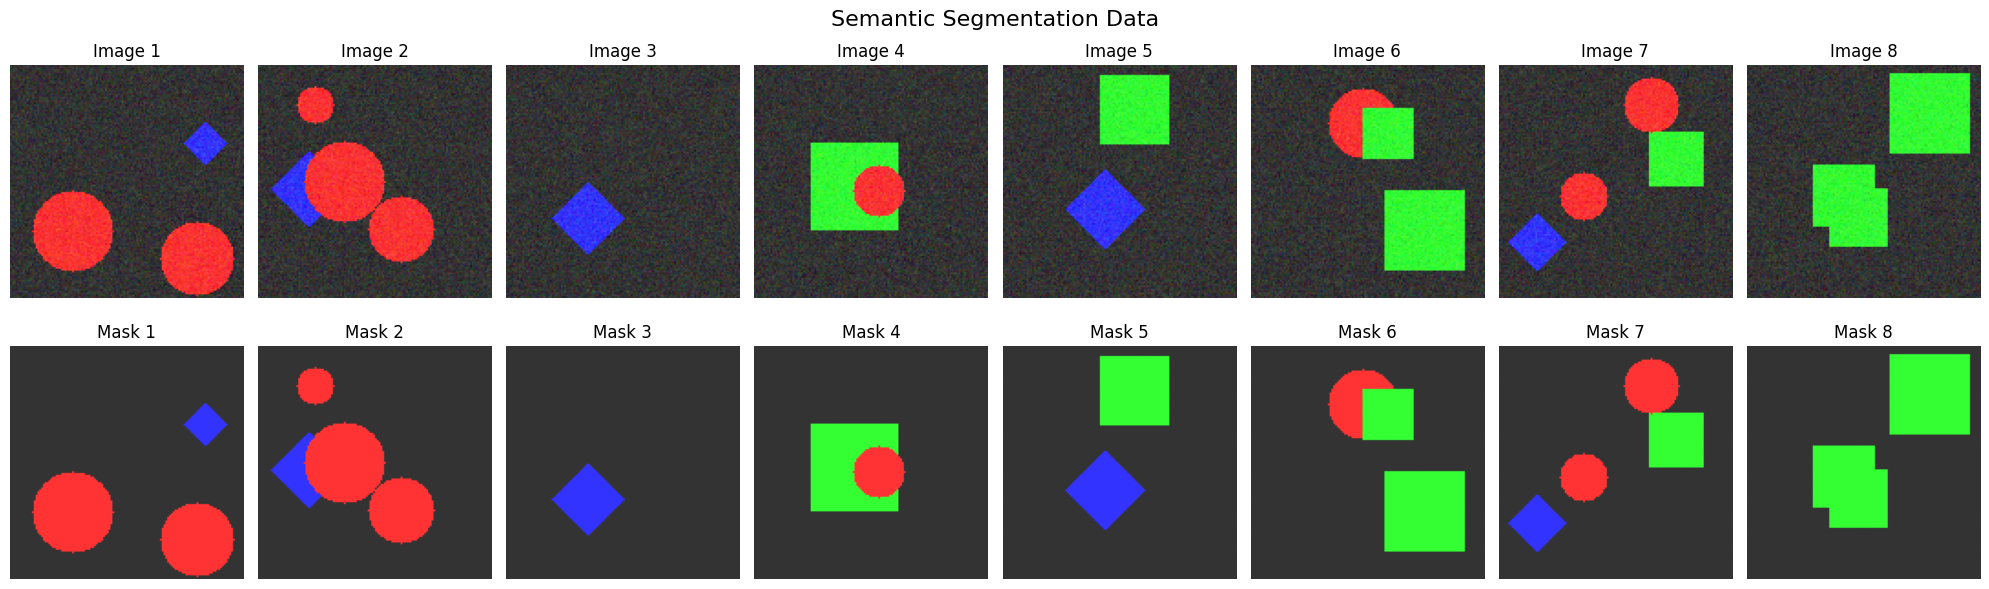


Class Distribution:
background: 109,506 pixels (83.55%)
circle: 8,145 pixels (6.21%)
square: 10,389 pixels (7.93%)
triangle: 3,032 pixels (2.31%)
Training set: 160 samples
Validation set: 40 samples
Input shape: (128, 128, 3)
Output shape: (128, 128, 4)
=== Building U-Net Architecture ===
Input shape: (128, 128, 3)
Number of classes: 4

U-Net Model Summary:
Total parameters: 31,055,492

=== Segmentation Loss Functions ===
Creating sample predictions to compare loss functions...

Loss Comparison:
Loss Function        Good Prediction Bad Prediction 
-------------------------------------------------------
Cross-Entropy        0.7491          1.4184         
Dice Loss            0.5268          0.7507         
Focal Loss           0.0131          0.0517         
Combined Loss        0.6379          1.0845         

Loss Function Characteristics:
• Cross-Entropy: Standard choice, works well for balanced datasets
• Dice Loss: Better for imbalanced datasets, focuses on overlap
• Focal Loss: 

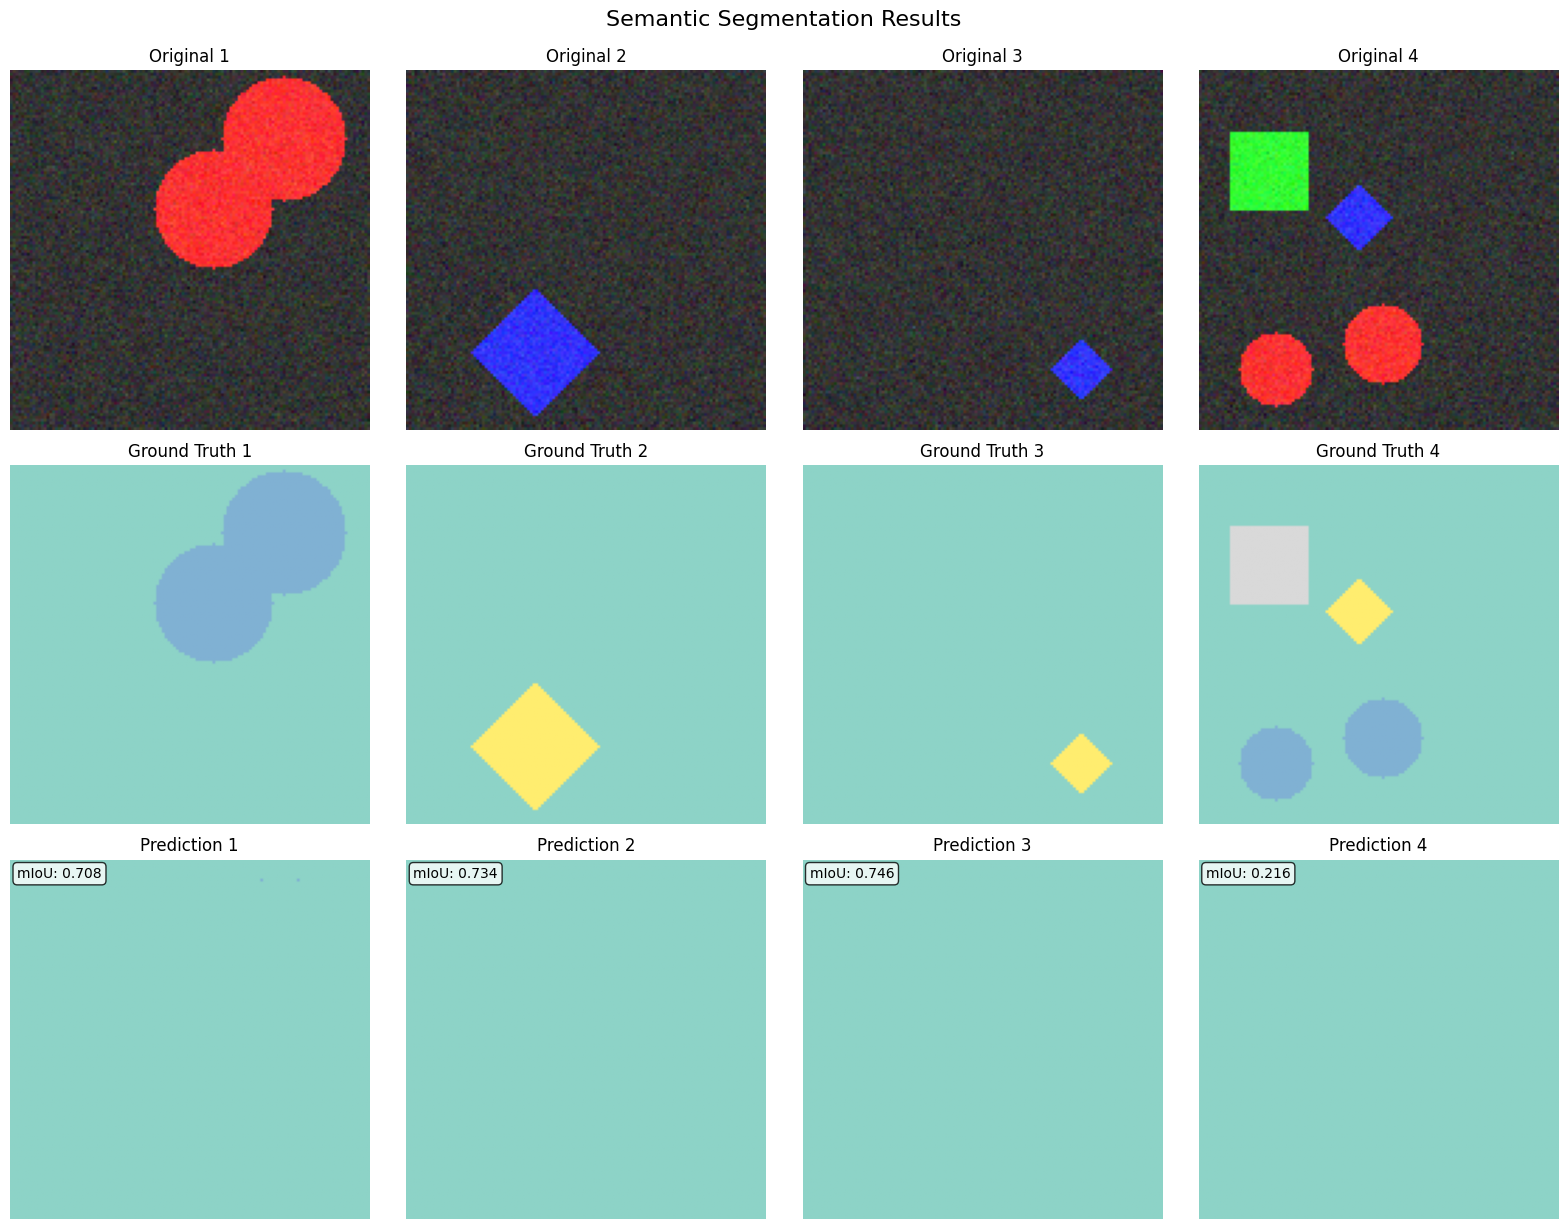


Class-wise IoU:
background: 0.858
circle: 0.000
square: 0.000
triangle: 0.000

Overall Mean IoU: 0.215


In [24]:
def implement_transposed_convolution_demo():
    """
    Demonstrate transposed convolution for upsampling.
    This shows how transposed convolutions work mathematically.
    """
    print("=== Transposed Convolution Demonstration ===")

    # Create a small input feature map
    input_size = 4
    input_map = tf.random.normal((1, input_size, input_size, 1))

    print(f"Input shape: {input_map.shape}")

    # Regular convolution (downsampling)
    conv_layer = tf.keras.layers.Conv2D(1, kernel_size=3, strides=2, padding='same')
    downsampled = conv_layer(input_map)

    print(f"After regular conv (stride=2): {downsampled.shape}")

    # Transposed convolution (upsampling)
    # Note: In transposed conv, stride defines how much to upsample
    transpose_layer = tf.keras.layers.Conv2DTranspose(
        1, kernel_size=3, strides=2, padding='same'
    )
    upsampled = transpose_layer(downsampled)

    print(f"After transposed conv (stride=2): {upsampled.shape}")

    # Visualize the process
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original
    axes[0].imshow(input_map[0, :, :, 0], cmap='viridis', interpolation='nearest')
    axes[0].set_title(f'Original\n{input_map.shape[1]}×{input_map.shape[2]}')
    axes[0].grid(True, alpha=0.3)

    # Downsampled
    axes[1].imshow(downsampled[0, :, :, 0], cmap='viridis', interpolation='nearest')
    axes[1].set_title(f'Downsampled\n{downsampled.shape[1]}×{downsampled.shape[2]}')
    axes[1].grid(True, alpha=0.3)

    # Upsampled
    axes[2].imshow(upsampled[0, :, :, 0], cmap='viridis', interpolation='nearest')
    axes[2].set_title(f'Upsampled\n{upsampled.shape[1]}×{upsampled.shape[2]}')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Transposed Convolution for Upsampling', y=1.02, fontsize=14)
    plt.show()

    # Compare with bilinear upsampling
    print("\n=== Comparison with Bilinear Upsampling ===")

    # Bilinear upsampling
    bilinear_upsampled = tf.image.resize(
        downsampled, [input_size, input_size], method='bilinear'
    )

    print(f"Bilinear upsampled shape: {bilinear_upsampled.shape}")

    # Calculate difference
    diff = tf.abs(upsampled - bilinear_upsampled)
    print(f"Mean absolute difference: {tf.reduce_mean(diff):.4f}")
    print(f"Max absolute difference: {tf.reduce_max(diff):.4f}")

    print("\nKey Differences:")
    print("- Transposed Conv: Learnable parameters, can adapt to data")
    print("- Bilinear: Fixed interpolation, no learning")
    print("- Transposed Conv: Can introduce checkerboard artifacts")
    print("- Bilinear: Smoother but may be too simplistic")

    return input_map, downsampled, upsampled, bilinear_upsampled

def build_unet_architecture(input_shape=(256, 256, 3), n_classes=21):
    """
    Build a U-Net architecture for semantic segmentation.
    This implements the classic encoder-decoder with skip connections.

    Args:
        input_shape: Shape of input images
        n_classes: Number of segmentation classes

    Returns:
        Keras model
    """
    print(f"=== Building U-Net Architecture ===")
    print(f"Input shape: {input_shape}")
    print(f"Number of classes: {n_classes}")

    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    def conv_block(x, filters, name_prefix):
        """Double convolution block used in U-Net."""
        x = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same',
                                  name=f'{name_prefix}_conv1')(x)
        x = tf.keras.layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
        x = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same',
                                  name=f'{name_prefix}_conv2')(x)
        x = tf.keras.layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
        return x

    # Encoder path
    c1 = conv_block(inputs, 64, 'enc1')  # 256x256
    p1 = tf.keras.layers.MaxPooling2D(2, name='pool1')(c1)  # 128x128

    c2 = conv_block(p1, 128, 'enc2')  # 128x128
    p2 = tf.keras.layers.MaxPooling2D(2, name='pool2')(c2)  # 64x64

    c3 = conv_block(p2, 256, 'enc3')  # 64x64
    p3 = tf.keras.layers.MaxPooling2D(2, name='pool3')(c3)  # 32x32

    c4 = conv_block(p3, 512, 'enc4')  # 32x32
    p4 = tf.keras.layers.MaxPooling2D(2, name='pool4')(c4)  # 16x16

    # Bottleneck
    c5 = conv_block(p4, 1024, 'bottleneck')  # 16x16

    # Decoder (Expanding Path)
    def upconv_block(x, skip_features, filters, name_prefix):
        """Upsampling block with skip connections."""
        # Transposed convolution for upsampling
        x = tf.keras.layers.Conv2DTranspose(filters, 2, strides=2, padding='same',
                                          name=f'{name_prefix}_upconv')(x)
        # Concatenate with skip connection
        x = tf.keras.layers.Concatenate(name=f'{name_prefix}_concat')([x, skip_features])
        # Double convolution
        x = conv_block(x, filters, name_prefix)
        return x

    # Decoder path with skip connections
    u6 = upconv_block(c5, c4, 512, 'dec1')  # 32x32
    u7 = upconv_block(u6, c3, 256, 'dec2')  # 64x64
    u8 = upconv_block(u7, c2, 128, 'dec3')  # 128x128
    u9 = upconv_block(u8, c1, 64, 'dec4')   # 256x256

    # Final classification layer
    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation='softmax',
                                    name='final_conv')(u9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='UNet')

    print(f"\nU-Net Model Summary:")
    print(f"Total parameters: {model.count_params():,}")

    return model

def create_synthetic_segmentation_data(n_samples=100, img_size=128, n_classes=4):
    """
    Create synthetic data for semantic segmentation demonstration.

    Args:
        n_samples: Number of samples to generate
        img_size: Size of square images
        n_classes: Number of classes (including background)

    Returns:
        images, masks, class_names
    """
    print(f"=== Creating Synthetic Segmentation Data ===")
    print(f"Samples: {n_samples}, Image size: {img_size}×{img_size}, Classes: {n_classes}")

    np.random.seed(42)

    images = []
    masks = []

    class_names = ['background', 'circle', 'square', 'triangle']
    class_colors = {
        0: [0.2, 0.2, 0.2],    # dark gray background
        1: [1.0, 0.2, 0.2],    # red circles
        2: [0.2, 1.0, 0.2],    # green squares
        3: [0.2, 0.2, 1.0],    # blue triangles
    }

    for sample_idx in range(n_samples):
        # Create blank image and mask
        img = np.full((img_size, img_size, 3), class_colors[0], dtype=np.float32)
        mask = np.zeros((img_size, img_size), dtype=np.int32)

        # Add random number of objects (1-4)
        n_objects = np.random.randint(1, 5)

        for _ in range(n_objects):
            # Random object type (1, 2, or 3 - skip background class 0)
            obj_class = np.random.randint(1, n_classes)

            # Random position and size
            center_x = np.random.randint(20, img_size - 20)
            center_y = np.random.randint(20, img_size - 20)
            size = np.random.randint(10, 25)

            # Create object mask
            obj_mask = np.zeros((img_size, img_size), dtype=bool)

            if obj_class == 1:  # Circle
                y, x = np.ogrid[:img_size, :img_size]
                obj_mask = (x - center_x)**2 + (y - center_y)**2 <= size**2

            elif obj_class == 2:  # Square
                x1 = max(0, center_x - size)
                x2 = min(img_size, center_x + size)
                y1 = max(0, center_y - size)
                y2 = min(img_size, center_y + size)
                obj_mask[y1:y2, x1:x2] = True

            elif obj_class == 3:  # Triangle
                for dy in range(-size, size):
                    width = size - abs(dy)
                    if width > 0:
                        x1 = max(0, center_x - width)
                        x2 = min(img_size, center_x + width)
                        y = center_y + dy
                        if 0 <= y < img_size:
                            obj_mask[y, x1:x2] = True

            # Apply object to image and mask
            img[obj_mask] = class_colors[obj_class]
            mask[obj_mask] = obj_class

        # Add some noise to make it more realistic
        noise = np.random.normal(0, 0.05, img.shape)
        img = np.clip(img + noise, 0, 1)

        images.append(img)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f"Generated {len(images)} samples")
    print(f"Image shape: {images.shape}")
    print(f"Mask shape: {masks.shape}")
    print(f"Classes in data: {np.unique(masks)}")

    # Visualize some samples
    visualize_segmentation_data(images[:8], masks[:8], class_names, class_colors)

    return images, masks, class_names

def visualize_segmentation_data(images, masks, class_names, class_colors=None):
    """
    Visualize segmentation data with images and corresponding masks.
    """
    n_samples = min(8, len(images))
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))

    if class_colors is None:
        class_colors = {i: plt.cm.Set3(i) for i in range(len(class_names))}

    for i in range(n_samples):
        # Original image
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')

        # Segmentation mask
        # Create colored mask
        colored_mask = np.zeros((*masks[i].shape, 3))
        for class_id in np.unique(masks[i]):
            if class_id in class_colors:
                colored_mask[masks[i] == class_id] = class_colors[class_id][:3]

        axes[1, i].imshow(colored_mask)
        axes[1, i].set_title(f'Mask {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.suptitle('Semantic Segmentation Data', y=1.02, fontsize=16)
    plt.show()

    # Show class distribution
    print("\nClass Distribution:")
    for i, class_name in enumerate(class_names):
        pixel_count = np.sum(masks == i)
        percentage = pixel_count / masks.size * 100
        print(f"{class_name}: {pixel_count:,} pixels ({percentage:.2f}%)")

def implement_segmentation_loss_functions():
    """
    Implement and compare different loss functions for semantic segmentation.
    """
    print("\n=== Segmentation Loss Functions ===")

    def dice_loss(y_true, y_pred, smooth=1e-6):
        """
        Dice loss implementation.

        Args:
            y_true: Ground truth masks [batch, H, W, classes] (one-hot)
            y_pred: Predicted probabilities [batch, H, W, classes]
            smooth: Smoothing factor to avoid division by zero

        Returns:
            Dice loss value
        """
        # Flatten spatial dimensions
        y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

        # Calculate intersection and union for each class
        intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
        union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)

        # Dice coefficient for each class
        dice_coeffs = (2.0 * intersection + smooth) / (union + smooth)

        # Mean dice coefficient across classes
        mean_dice = tf.reduce_mean(dice_coeffs)

        # Dice loss = 1 - dice coefficient
        return 1.0 - mean_dice

    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        """
        Focal loss implementation for handling class imbalance.

        Args:
            y_true: Ground truth masks [batch, H, W, classes] (one-hot)
            y_pred: Predicted probabilities [batch, H, W, classes]
            alpha: Weighting factor for rare class
            gamma: Focusing parameter

        Returns:
            Focal loss value
        """
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)

        # Calculate cross entropy
        ce_loss = -y_true * tf.math.log(y_pred)

        # Calculate p_t
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate alpha_t
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

        # Calculate focal weight
        focal_weight = alpha_t * tf.pow(1 - p_t, gamma)

        # Apply focal weight
        focal_loss_val = focal_weight * ce_loss

        return tf.reduce_mean(focal_loss_val)

    def combined_loss(y_true, y_pred, ce_weight=0.5, dice_weight=0.5):
        """
        Combined cross-entropy and dice loss.

        Args:
            y_true: Ground truth masks
            y_pred: Predicted probabilities
            ce_weight: Weight for cross-entropy loss
            dice_weight: Weight for dice loss

        Returns:
            Combined loss value
        """
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        ce_loss = tf.reduce_mean(ce_loss)

        dice_loss_val = dice_loss(y_true, y_pred)

        return ce_weight * ce_loss + dice_weight * dice_loss_val

    # Demonstrate loss functions with sample data
    print("Creating sample predictions to compare loss functions...")

    # Create sample ground truth (one-hot encoded)
    batch_size, h, w, n_classes = 2, 32, 32, 4
    y_true = tf.one_hot(tf.random.uniform([batch_size, h, w], 0, n_classes, dtype=tf.int32), n_classes)

    # Create sample predictions
    y_pred_good = y_true + tf.random.normal(y_true.shape, mean=0, stddev=0.1)
    y_pred_good = tf.nn.softmax(y_pred_good, axis=-1)

    y_pred_bad = tf.random.uniform(y_true.shape)
    y_pred_bad = tf.nn.softmax(y_pred_bad, axis=-1)

    print(f"\nLoss Comparison:")
    print(f"{'Loss Function':<20} {'Good Prediction':<15} {'Bad Prediction':<15}")
    print("-" * 55)

    # Cross-entropy loss
    ce_good = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_good))
    ce_bad = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_bad))
    print(f"{'Cross-Entropy':<20} {ce_good.numpy():<15.4f} {ce_bad.numpy():<15.4f}")

    # Dice loss
    dice_good = dice_loss(y_true, y_pred_good)
    dice_bad = dice_loss(y_true, y_pred_bad)
    print(f"{'Dice Loss':<20} {dice_good.numpy():<15.4f} {dice_bad.numpy():<15.4f}")

    # Focal loss
    focal_good = focal_loss(y_true, y_pred_good)
    focal_bad = focal_loss(y_true, y_pred_bad)
    print(f"{'Focal Loss':<20} {focal_good.numpy():<15.4f} {focal_bad.numpy():<15.4f}")

    # Combined loss
    combined_good = combined_loss(y_true, y_pred_good)
    combined_bad = combined_loss(y_true, y_pred_bad)
    print(f"{'Combined Loss':<20} {combined_good.numpy():<15.4f} {combined_bad.numpy():<15.4f}")

    print("\nLoss Function Characteristics:")
    print("• Cross-Entropy: Standard choice, works well for balanced datasets")
    print("• Dice Loss: Better for imbalanced datasets, focuses on overlap")
    print("• Focal Loss: Addresses class imbalance by focusing on hard examples")
    print("• Combined Loss: Leverages benefits of multiple loss functions")

    return dice_loss, focal_loss, combined_loss

def train_segmentation_model():
    """
    Complete training pipeline for semantic segmentation.
    """
    print("\n=== Training Segmentation Model ===")

    # Create synthetic data
    images, masks, class_names = create_synthetic_segmentation_data(n_samples=200, img_size=128)

    # Split data
    split_idx = int(0.8 * len(images))
    x_train, x_val = images[:split_idx], images[split_idx:]
    y_train, y_val = masks[:split_idx], masks[split_idx:]

    # Convert masks to one-hot encoding
    n_classes = len(class_names)
    y_train_onehot = tf.one_hot(y_train, n_classes)
    y_val_onehot = tf.one_hot(y_val, n_classes)

    print(f"Training set: {len(x_train)} samples")
    print(f"Validation set: {len(x_val)} samples")
    print(f"Input shape: {x_train.shape[1:]}")
    print(f"Output shape: {y_train_onehot.shape[1:]}")

    # Build U-Net model
    model = build_unet_architecture(input_shape=x_train.shape[1:], n_classes=n_classes)

    # Get loss functions
    dice_loss_fn, focal_loss_fn, combined_loss_fn = implement_segmentation_loss_functions()

    # Compile model with combined loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=combined_loss_fn,
        metrics=[
            'categorical_accuracy',
            tf.keras.metrics.MeanIoU(num_classes=n_classes)
        ]
    )

    # Train model
    print("\nStarting training...")
    history = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_val, y_val_onehot),
        epochs=5,  # Reduced for demo
        batch_size=8,
        verbose=1
    )

    # Evaluate model
    print("\n=== Model Evaluation ===")
    val_loss, val_acc, val_miou = model.evaluate(x_val, y_val_onehot, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Mean IoU: {val_miou:.4f}")

    # Make predictions and visualize
    predictions = model.predict(x_val[:8], verbose=0)
    pred_masks = np.argmax(predictions, axis=-1)

    visualize_segmentation_predictions(
        x_val[:8], y_val[:8], pred_masks, class_names
    )

    return model, history, (x_val, y_val, pred_masks)

def visualize_segmentation_predictions(images, true_masks, pred_masks, class_names):
    """
    Visualize segmentation predictions vs ground truth.
    """
    n_samples = min(4, len(images))
    fig, axes = plt.subplots(3, n_samples, figsize=(16, 12))

    # Create colormap for classes
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

    for i in range(n_samples):
        # Original image
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')

        # Ground truth mask
        axes[1, i].imshow(true_masks[i], cmap='Set3', vmin=0, vmax=len(class_names)-1)
        axes[1, i].set_title(f'Ground Truth {i+1}')
        axes[1, i].axis('off')

        # Predicted mask
        axes[2, i].imshow(pred_masks[i], cmap='Set3', vmin=0, vmax=len(class_names)-1)
        axes[2, i].set_title(f'Prediction {i+1}')
        axes[2, i].axis('off')

        # Calculate and display IoU for this sample
        sample_ious = []
        for class_id in range(len(class_names)):
            true_class = (true_masks[i] == class_id)
            pred_class = (pred_masks[i] == class_id)

            intersection = np.sum(true_class & pred_class)
            union = np.sum(true_class | pred_class)

            if union > 0:
                iou = intersection / union
                sample_ious.append(iou)
            else:
                sample_ious.append(1.0 if intersection == 0 else 0.0)

        mean_iou = np.mean(sample_ious)
        axes[2, i].text(0.02, 0.98, f'mIoU: {mean_iou:.3f}',
                       transform=axes[2, i].transAxes,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                       verticalalignment='top', fontsize=10)

    plt.tight_layout()
    plt.suptitle('Semantic Segmentation Results', y=1.02, fontsize=16)
    plt.show()

    # Show class-wise performance
    print("\nClass-wise IoU:")
    overall_ious = []

    for class_id, class_name in enumerate(class_names):
        class_ious = []
        for i in range(len(true_masks)):
            true_class = (true_masks[i] == class_id)
            pred_class = (pred_masks[i] == class_id)

            intersection = np.sum(true_class & pred_class)
            union = np.sum(true_class | pred_class)

            if union > 0:
                iou = intersection / union
                class_ious.append(iou)

        if class_ious:
            mean_class_iou = np.mean(class_ious)
            overall_ious.append(mean_class_iou)
            print(f"{class_name}: {mean_class_iou:.3f}")
        else:
            print(f"{class_name}: No samples")

    if overall_ious:
        print(f"\nOverall Mean IoU: {np.mean(overall_ious):.3f}")

# Run semantic segmentation demonstrations
input_map, downsampled, upsampled, bilinear = implement_transposed_convolution_demo()
model, history, results = train_segmentation_model()

## 11. Chapter Exercises

Let's solve the exercises from Chapter 14 with detailed theoretical explanations and practical implementations.

### Exercise 1: Advantages of CNNs over Fully Connected DNNs

**Question**: What are the advantages of a CNN over a fully connected DNN for image classification?

**Theoretical Answer**:

CNNs have several key advantages over fully connected networks for image tasks:

#### 1. **Parameter Efficiency**
- **Fully Connected**: Each neuron connects to every input pixel
  - For 224×224×3 input: 150,528 connections per neuron
  - First layer with 1000 neurons: 150M+ parameters
- **CNN**: Shared weights across spatial locations
  - 3×3 filter with 64 channels: only 1,792 parameters
  - Same filter applied across entire image

#### 2. **Translation Invariance**
- **Mathematical Foundation**:
  $$f(T_\delta(x)) \approx f(x)$$
  where $T_\delta$ is a small translation
- **CNN**: Features learned at one location work at other locations
- **Fully Connected**: Must learn separate weights for each position

#### 3. **Hierarchical Feature Learning**
- **Early layers**: Edge and texture detection
- **Middle layers**: Parts and patterns
- **Later layers**: High-level concepts
- **Mathematical**: $h^{(l+1)} = f(W^{(l)} * h^{(l)})$ builds complexity

#### 4. **Spatial Structure Preservation**
- **CNN**: Maintains 2D spatial relationships
- **Fully Connected**: Flattens spatial information
- **Benefit**: Neighboring pixels processed together

#### 5. **Computational Efficiency**
- **Memory**: O(filter_size × channels) vs O(width × height × channels)
- **Computation**: Shared convolutions vs individual dot products

In [25]:
def exercise_1_parameter_comparison():
    """
    Demonstrate parameter efficiency of CNNs vs Fully Connected networks.
    """
    print("=== Exercise 1: CNN vs Fully Connected Parameter Comparison ===")

    # Image specifications
    height, width, channels = 224, 224, 3
    input_size = height * width * channels

    print(f"Input image: {height}×{width}×{channels} = {input_size:,} pixels")

    # Fully Connected approach
    print("\n1. Fully Connected Network:")

    # First hidden layer with 1000 neurons
    fc_layer1_params = input_size * 1000 + 1000  # weights + biases
    print(f"   First layer (1000 neurons): {fc_layer1_params:,} parameters")

    # Second hidden layer
    fc_layer2_params = 1000 * 500 + 500
    print(f"   Second layer (500 neurons): {fc_layer2_params:,} parameters")

    # Output layer (1000 classes)
    fc_output_params = 500 * 1000 + 1000
    print(f"   Output layer (1000 classes): {fc_output_params:,} parameters")

    fc_total = fc_layer1_params + fc_layer2_params + fc_output_params
    print(f"   Total FC parameters: {fc_total:,}")

    # CNN approach (simplified ResNet-like)
    print("\n2. Convolutional Neural Network:")

    cnn_params = 0

    # Conv1: 7x7, 64 filters
    conv1_params = (7 * 7 * 3 + 1) * 64
    cnn_params += conv1_params
    print(f"   Conv1 (7×7×3→64): {conv1_params:,} parameters")

    # Conv2: 3x3, 128 filters
    conv2_params = (3 * 3 * 64 + 1) * 128
    cnn_params += conv2_params
    print(f"   Conv2 (3×3×64→128): {conv2_params:,} parameters")

    # Conv3: 3x3, 256 filters
    conv3_params = (3 * 3 * 128 + 1) * 256
    cnn_params += conv3_params
    print(f"   Conv3 (3×3×128→256): {conv3_params:,} parameters")

    # Conv4: 3x3, 512 filters
    conv4_params = (3 * 3 * 256 + 1) * 512
    cnn_params += conv4_params
    print(f"   Conv4 (3×3×256→512): {conv4_params:,} parameters")

    # Global Average Pooling + Dense output
    # After several pooling layers, feature maps are small (e.g., 7×7)
    # Global average pooling reduces to 512 features
    gap_output_params = 512 * 1000 + 1000
    cnn_params += gap_output_params
    print(f"   Output layer (512→1000): {gap_output_params:,} parameters")

    print(f"   Total CNN parameters: {cnn_params:,}")

    # Comparison
    print("\n3. Comparison:")
    print(f"   Fully Connected: {fc_total:,} parameters")
    print(f"   CNN: {cnn_params:,} parameters")
    reduction = fc_total / cnn_params
    print(f"   Parameter reduction: {reduction:.1f}×")

    # Memory comparison
    print("\n4. Memory Usage (32-bit floats):")
    fc_memory_mb = fc_total * 4 / (1024**2)
    cnn_memory_mb = cnn_params * 4 / (1024**2)
    print(f"   Fully Connected: {fc_memory_mb:.1f} MB")
    print(f"   CNN: {cnn_memory_mb:.1f} MB")

    return fc_total, cnn_params

fc_params, cnn_params = exercise_1_parameter_comparison()

=== Exercise 1: CNN vs Fully Connected Parameter Comparison ===
Input image: 224×224×3 = 150,528 pixels

1. Fully Connected Network:
   First layer (1000 neurons): 150,529,000 parameters
   Second layer (500 neurons): 500,500 parameters
   Output layer (1000 classes): 501,000 parameters
   Total FC parameters: 151,530,500

2. Convolutional Neural Network:
   Conv1 (7×7×3→64): 9,472 parameters
   Conv2 (3×3×64→128): 73,856 parameters
   Conv3 (3×3×128→256): 295,168 parameters
   Conv4 (3×3×256→512): 1,180,160 parameters
   Output layer (512→1000): 513,000 parameters
   Total CNN parameters: 2,071,656

3. Comparison:
   Fully Connected: 151,530,500 parameters
   CNN: 2,071,656 parameters
   Parameter reduction: 73.1×

4. Memory Usage (32-bit floats):
   Fully Connected: 578.0 MB
   CNN: 7.9 MB


### Exercise 2: CNN Parameter Calculation

**Question**: Consider a CNN composed of three convolutional layers, each with 3×3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200×300 pixels. What is the total number of parameters in the CNN?

**Mathematical Solution**:

For each convolutional layer, the number of parameters is:
$$\text{Parameters} = (\text{kernel_height} \times \text{kernel_width} \times \text{input_channels} + 1) \times \text{output_channels}$$

The "+1" accounts for the bias term per output channel.

In [26]:
def exercise_2_parameter_calculation():
    """
    Calculate total parameters for the specified CNN architecture.
    """
    print("=== Exercise 2: Parameter Calculation ===")

    # Network specifications
    input_shape = (200, 300, 3)  # Height, Width, Channels
    kernel_size = 3
    stride = 2
    padding = "same"

    layer_configs = [
        {'input_channels': 3, 'output_channels': 100, 'name': 'Conv1'},
        {'input_channels': 100, 'output_channels': 200, 'name': 'Conv2'},
        {'input_channels': 200, 'output_channels': 400, 'name': 'Conv3'}
    ]

    print(f"Input shape: {input_shape}")
    print(f"Kernel size: {kernel_size}×{kernel_size}")
    print(f"Stride: {stride}")
    print(f"Padding: {padding}")
    print()

    total_params = 0
    current_height, current_width = input_shape[0], input_shape[1]

    print("Layer-by-layer analysis:")
    print(f"{'Layer':<8} {'Input Shape':<15} {'Output Shape':<15} {'Parameters':<12} {'Calculation':<25}")
    print("-" * 85)

    for i, config in enumerate(layer_configs):
        # Calculate parameters
        weights_per_filter = kernel_size * kernel_size * config['input_channels']
        bias_per_filter = 1
        params_per_filter = weights_per_filter + bias_per_filter
        layer_params = params_per_filter * config['output_channels']

        # Calculate output shape with stride=2 and "same" padding
        output_height = (current_height + stride - 1) // stride  # Ceiling division
        output_width = (current_width + stride - 1) // stride

        # Format strings for display
        input_shape_str = f"{current_height}×{current_width}×{config['input_channels']}"
        output_shape_str = f"{output_height}×{output_width}×{config['output_channels']}"
        calculation_str = f"({kernel_size}×{kernel_size}×{config['input_channels']}+1)×{config['output_channels']}"

        print(f"{config['name']:<8} {input_shape_str:<15} {output_shape_str:<15} {layer_params:<12,} {calculation_str:<25}")

        total_params += layer_params
        current_height, current_width = output_height, output_width

    print("-" * 85)
    print(f"{'Total':<8} {'':<15} {'':<15} {total_params:<12,}")

    # Detailed calculation verification
    print("\nDetailed Calculations:")

    conv1_params = (3 * 3 * 3 + 1) * 100
    conv2_params = (3 * 3 * 100 + 1) * 200
    conv3_params = (3 * 3 * 200 + 1) * 400

    print(f"Conv1: (3×3×3 + 1) × 100 = {3*3*3 + 1} × 100 = {conv1_params:,}")
    print(f"Conv2: (3×3×100 + 1) × 200 = {3*3*100 + 1} × 200 = {conv2_params:,}")
    print(f"Conv3: (3×3×200 + 1) × 400 = {3*3*200 + 1} × 400 = {conv3_params:,}")
    print(f"Total: {conv1_params:,} + {conv2_params:,} + {conv3_params:,} = {total_params:,}")

    return total_params

def exercise_2_memory_calculation():
    """
    Calculate memory requirements for training and inference.
    """
    print("\n=== Memory Requirements Analysis ===")

    # Calculate feature map sizes at each layer
    input_size = 200 * 300 * 3  # Input pixels

    # After each layer with stride 2 and "same" padding
    layer1_size = 100 * 150 * 100  # (200+1)//2 × (300+1)//2 × 100
    layer2_size = 50 * 75 * 200    # (100+1)//2 × (150+1)//2 × 200
    layer3_size = 25 * 38 * 400    # (50+1)//2 × (75+1)//2 × 400

    print("Feature map sizes (single instance):")
    print(f"Input: 200×300×3 = {input_size:,} values")
    print(f"Layer 1: 100×150×100 = {layer1_size:,} values")
    print(f"Layer 2: 50×75×200 = {layer2_size:,} values")
    print(f"Layer 3: 25×38×400 = {layer3_size:,} values")

    # Memory in MB (32-bit floats = 4 bytes)
    bytes_per_float = 4
    mb_factor = 1024 * 1024

    input_mb = input_size * bytes_per_float / mb_factor
    layer1_mb = layer1_size * bytes_per_float / mb_factor
    layer2_mb = layer2_size * bytes_per_float / mb_factor
    layer3_mb = layer3_size * bytes_per_float / mb_factor

    print("\nMemory per instance (32-bit floats):")
    print(f"Input: {input_mb:.2f} MB")
    print(f"Layer 1: {layer1_mb:.2f} MB")
    print(f"Layer 2: {layer2_mb:.2f} MB")
    print(f"Layer 3: {layer3_mb:.2f} MB")

    # Total memory for single instance (inference)
    inference_memory = input_mb + layer1_mb + layer2_mb + layer3_mb
    print(f"\nInference memory (single instance): {inference_memory:.2f} MB")

    # Training memory (need to store all activations for backprop)
    # Plus gradients (same size as activations)
    training_memory = inference_memory * 2  # Activations + gradients
    print(f"Training memory (single instance): {training_memory:.2f} MB")

    # Batch training
    batch_size = 50
    batch_training_memory = training_memory * batch_size
    print(f"Training memory (batch of {batch_size}): {batch_training_memory:.2f} MB = {batch_training_memory/1024:.2f} GB")

    return inference_memory, training_memory, batch_training_memory

# Solve Exercise 2
total_params = exercise_2_parameter_calculation()
inference_mem, training_mem, batch_mem = exercise_2_memory_calculation()

=== Exercise 2: Parameter Calculation ===
Input shape: (200, 300, 3)
Kernel size: 3×3
Stride: 2
Padding: same

Layer-by-layer analysis:
Layer    Input Shape     Output Shape    Parameters   Calculation              
-------------------------------------------------------------------------------------
Conv1    200×300×3       100×150×100     2,800        (3×3×3+1)×100            
Conv2    100×150×100     50×75×200       180,200      (3×3×100+1)×200          
Conv3    50×75×200       25×38×400       720,400      (3×3×200+1)×400          
-------------------------------------------------------------------------------------
Total                                    903,400     

Detailed Calculations:
Conv1: (3×3×3 + 1) × 100 = 28 × 100 = 2,800
Conv2: (3×3×100 + 1) × 200 = 901 × 200 = 180,200
Conv3: (3×3×200 + 1) × 400 = 1801 × 400 = 720,400
Total: 2,800 + 180,200 + 720,400 = 903,400

=== Memory Requirements Analysis ===
Feature map sizes (single instance):
Input: 200×300×3 = 180,000 values

### Exercise 3: GPU Memory Issues

**Question**: If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?

**Solution**: Here are five practical strategies to reduce GPU memory usage:

In [27]:
def exercise_3_memory_solutions():
    """
    Demonstrate 5 solutions for GPU memory issues with practical examples.
    """
    print("=== Exercise 3: GPU Memory Solutions ===")

    solutions = [
        {
            'name': '1. Reduce Batch Size',
            'description': 'Most effective immediate solution',
            'math': 'Memory ∝ batch_size × image_size × channels',
            'implementation': 'Change batch_size from 32 to 16 or 8',
            'tradeoff': 'May affect training dynamics and convergence speed'
        },
        {
            'name': '2. Use Mixed Precision Training',
            'description': 'Use 16-bit floats instead of 32-bit',
            'math': 'Memory reduction: ~50% (16-bit vs 32-bit)',
            'implementation': 'Enable tf.keras.mixed_precision',
            'tradeoff': 'Potential numerical instability (rare with modern techniques)'
        },
        {
            'name': '3. Gradient Accumulation',
            'description': 'Simulate large batch with multiple small batches',
            'math': 'Effective_batch = mini_batch × accumulation_steps',
            'implementation': 'Accumulate gradients over multiple forward passes',
            'tradeoff': 'Increased training time per effective batch'
        },
        {
            'name': '4. Reduce Input Resolution',
            'description': 'Use smaller input images',
            'math': 'Memory ∝ height × width (quadratic reduction)',
            'implementation': 'Resize from 224×224 to 192×192 or 160×160',
            'tradeoff': 'May reduce model accuracy due to information loss'
        },
        {
            'name': '5. Model Architecture Changes',
            'description': 'Use more memory-efficient architectures',
            'math': 'Reduce channels, use depthwise convolutions, remove layers',
            'implementation': 'MobileNet, EfficientNet, or reduce layer count',
            'tradeoff': 'May reduce model capacity and accuracy'
        }
    ]

    print("\nFive Solutions for GPU Memory Issues:\n")

    for i, solution in enumerate(solutions):
        print(f"{solution['name']}")
        print(f"   Description: {solution['description']}")
        print(f"   Mathematical: {solution['math']}")
        print(f"   Implementation: {solution['implementation']}")
        print(f"   Tradeoff: {solution['tradeoff']}")
        print()

    # Demonstrate memory impact with calculations
    print("=== Memory Impact Calculations ===")

    # Base scenario
    base_config = {
        'batch_size': 32,
        'height': 224,
        'width': 224,
        'channels': 3,
        'precision': 32  # bits
    }

    def calculate_memory(config):
        """Calculate approximate memory usage for input batch."""
        pixels = config['batch_size'] * config['height'] * config['width'] * config['channels']
        bytes_per_value = config['precision'] // 8
        total_bytes = pixels * bytes_per_value
        mb = total_bytes / (1024 * 1024)
        return mb

    base_memory = calculate_memory(base_config)
    print(f"Base configuration memory: {base_memory:.1f} MB")
    print(f"  Batch size: {base_config['batch_size']}")
    print(f"  Image size: {base_config['height']}×{base_config['width']}")
    print(f"  Precision: {base_config['precision']}-bit")

    # Solution 1: Reduce batch size
    reduced_batch_config = base_config.copy()
    reduced_batch_config['batch_size'] = 16
    reduced_batch_memory = calculate_memory(reduced_batch_config)
    batch_reduction = base_memory / reduced_batch_memory
    print(f"\nSolution 1 - Reduced batch size: {reduced_batch_memory:.1f} MB")
    print(f"  Memory reduction: {batch_reduction:.1f}×")

    # Solution 2: Mixed precision
    mixed_precision_config = base_config.copy()
    mixed_precision_config['precision'] = 16
    mixed_precision_memory = calculate_memory(mixed_precision_config)
    precision_reduction = base_memory / mixed_precision_memory
    print(f"\nSolution 2 - Mixed precision: {mixed_precision_memory:.1f} MB")
    print(f"  Memory reduction: {precision_reduction:.1f}×")

    # Solution 4: Reduce resolution
    reduced_res_config = base_config.copy()
    reduced_res_config['height'] = 192
    reduced_res_config['width'] = 192
    reduced_res_memory = calculate_memory(reduced_res_config)
    resolution_reduction = base_memory / reduced_res_memory
    print(f"\nSolution 4 - Reduced resolution (192×192): {reduced_res_memory:.1f} MB")
    print(f"  Memory reduction: {resolution_reduction:.1f}×")

    # Combined solutions
    combined_config = {
        'batch_size': 16,
        'height': 192,
        'width': 192,
        'channels': 3,
        'precision': 16
    }
    combined_memory = calculate_memory(combined_config)
    combined_reduction = base_memory / combined_memory
    print(f"\nCombined solutions: {combined_memory:.1f} MB")
    print(f"  Total memory reduction: {combined_reduction:.1f}×")

    return solutions

def demonstrate_gradient_accumulation():
    """
    Demonstrate gradient accumulation technique.
    """
    print("\n=== Gradient Accumulation Example ===")

    print("Gradient Accumulation allows simulation of large batch sizes:")
    print("\nPseudo-code implementation:")

    code_example = '''
    # Traditional large batch training
    large_batch_size = 64

    # GPU memory limited to small batches
    mini_batch_size = 16
    accumulation_steps = large_batch_size // mini_batch_size  # = 4

    optimizer.zero_grad()

    for step in range(accumulation_steps):
        # Get mini-batch
        mini_batch = get_mini_batch(mini_batch_size)

        # Forward pass
        outputs = model(mini_batch)
        loss = criterion(outputs, targets)

        # Scale loss by accumulation steps
        loss = loss / accumulation_steps

        # Backward pass (accumulate gradients)
        loss.backward()

    # Update weights after accumulating all gradients
    optimizer.step()
    '''

    print(code_example)

    print("\nMathematical equivalence:")
    print("Large batch gradient: ∇L = (1/N) Σᵢ ∇L(xᵢ)")
    print("Accumulated gradient: ∇L = (1/K) Σⱼ [(1/M) Σᵢ ∇L(xᵢⱼ)]")
    print("Where N = K×M (total samples = steps × mini_batch_size)")

exercise_3_memory_solutions()
demonstrate_gradient_accumulation()

=== Exercise 3: GPU Memory Solutions ===

Five Solutions for GPU Memory Issues:

1. Reduce Batch Size
   Description: Most effective immediate solution
   Mathematical: Memory ∝ batch_size × image_size × channels
   Implementation: Change batch_size from 32 to 16 or 8
   Tradeoff: May affect training dynamics and convergence speed

2. Use Mixed Precision Training
   Description: Use 16-bit floats instead of 32-bit
   Mathematical: Memory reduction: ~50% (16-bit vs 32-bit)
   Implementation: Enable tf.keras.mixed_precision
   Tradeoff: Potential numerical instability (rare with modern techniques)

3. Gradient Accumulation
   Description: Simulate large batch with multiple small batches
   Mathematical: Effective_batch = mini_batch × accumulation_steps
   Implementation: Accumulate gradients over multiple forward passes
   Tradeoff: Increased training time per effective batch

4. Reduce Input Resolution
   Description: Use smaller input images
   Mathematical: Memory ∝ height × width (qu

### Exercise 4: Max Pooling vs Convolutional Layer

**Question**: Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?

**Answer**: Max pooling offers several advantages over strided convolutions:

1. **No Parameters**: Max pooling has zero learnable parameters
2. **Translation Invariance**: Provides built-in invariance to small translations
3. **Computational Efficiency**: Simple max operation vs convolution
4. **Overfitting Reduction**: Acts as regularization by discarding information

### Exercise 5: Local Response Normalization

**Question**: When would you want to add a local response normalization layer?

**Answer**: LRN was historically used in AlexNet but is rarely used today because:
- **Batch Normalization** is more effective
- **Modern activations** (ReLU, etc.) are less prone to saturation
- **Limited benefits** in practice

### Exercise 6: Architectural Innovations

**Question**: What are the main innovations in AlexNet, GoogLeNet, ResNet, SENet, and Xception?

**Answers**:
- **AlexNet**: ReLU, Dropout, Data Augmentation, GPU training
- **GoogLeNet**: Inception modules, 1×1 convolutions, Global Average Pooling
- **ResNet**: Skip connections, Very deep networks (152 layers)
- **SENet**: Squeeze-and-Excitation blocks, Channel attention
- **Xception**: Depthwise separable convolutions, Extreme Inception

### Exercise 7: Fully Convolutional Networks

**Question**: What is a fully convolutional network? How can you convert a dense layer into a convolutional layer?

**Answer**: FCN replaces dense layers with convolutional layers to handle variable input sizes.

**Conversion**: Dense layer with N units operating on H×W×C features becomes Conv2D with N filters of size H×W.

### Exercise 8: Semantic Segmentation Challenge

**Question**: What is the main technical difficulty of semantic segmentation?

**Answer**: **Spatial resolution loss** - CNNs progressively reduce spatial resolution through pooling and strided convolutions, but segmentation requires pixel-level predictions.

**Solutions**: Transposed convolutions, skip connections, dilated convolutions.

In [28]:
def exercise_9_custom_cnn_mnist():
    """
    Exercise 9: Build custom CNN for MNIST to achieve highest accuracy.
    """
    print("=== Exercise 9: Custom CNN for MNIST ===")

    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Preprocessing
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = x_train[..., np.newaxis]  # Add channel dimension
    x_test = x_test[..., np.newaxis]

    print(f"Training data: {x_train.shape}")
    print(f"Test data: {x_test.shape}")

    # Build optimized CNN architecture
    model = tf.keras.Sequential([
        # First block: Feature extraction
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=[28, 28, 1]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),

        # Second block: More complex features
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),

        # Third block: High-level features
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        # Classifier
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile with advanced optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nModel Architecture:")
    model.summary()

    # Training with callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]

    print("\nTraining model...")
    history = model.fit(
        x_train, y_train,
        validation_split=0.1,
        epochs=3,  # Reduced for demo
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    return model, history, test_accuracy

def exercise_10_transfer_learning_guide():
    """
    Exercise 10: Transfer learning implementation guide.
    """
    print("\n=== Exercise 10: Transfer Learning Implementation Guide ===")

    implementation_steps = [
        {
            'step': 'a. Create Training Set',
            'description': 'Collect 100+ images per class',
            'code': '''# Example: Create custom dataset
import os
dataset_dir = "my_dataset/"
classes = ["beach", "mountain", "city", "forest"]

# Organize as:
# dataset/
#   ├── beach/
#   ├── mountain/
#   ├── city/
#   └── forest/'''
        },
        {
            'step': 'b. Split Dataset',
            'description': 'Create train/validation/test splits',
            'code': '''# Using sklearn
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)'''
        },
        {
            'step': 'c. Input Pipeline',
            'description': 'Preprocessing and data augmentation',
            'code': '''# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rescale=1./255
)'''
        },
        {
            'step': 'd. Fine-tune Pretrained Model',
            'description': 'Load and adapt pretrained model',
            'code': '''# Load pretrained model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add custom head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])'''
        }
    ]

    for step_info in implementation_steps:
        print(f"\n{step_info['step']}:")
        print(f"Description: {step_info['description']}")
        print(f"Code example:")
        print(step_info['code'])

    # Best practices
    print("\n=== Transfer Learning Best Practices ===")
    best_practices = [
        "1. Start with feature extraction (frozen base model)",
        "2. Use lower learning rate for fine-tuning",
        "3. Apply data augmentation to prevent overfitting",
        "4. Monitor validation metrics closely",
        "5. Consider progressive unfreezing of layers",
        "6. Use appropriate preprocessing for pretrained model",
        "7. Save best model weights during training"
    ]

    for practice in best_practices:
        print(practice)

def exercise_11_style_transfer_info():
    """
    Exercise 11: Style Transfer tutorial information.
    """
    print("\n=== Exercise 11: Neural Style Transfer ===")

    print("Neural Style Transfer combines content and style from different images.")
    print("\nKey Concepts:")

    concepts = [
        {
            'name': 'Content Loss',
            'formula': 'L_content = ||F^l[P] - F^l[X]||²',
            'description': 'Measures difference in feature representations'
        },
        {
            'name': 'Style Loss',
            'formula': 'L_style = ||G^l[A] - G^l[X]||²',
            'description': 'Based on Gram matrices of feature correlations'
        },
        {
            'name': 'Total Loss',
            'formula': 'L_total = α·L_content + β·L_style',
            'description': 'Weighted combination of content and style losses'
        }
    ]

    for concept in concepts:
        print(f"\n{concept['name']}:")
        print(f"  Formula: {concept['formula']}")
        print(f"  Description: {concept['description']}")

    print("\nImplementation Steps:")
    steps = [
        "1. Load pretrained VGG19 network",
        "2. Extract features from multiple layers",
        "3. Define content and style loss functions",
        "4. Use gradient descent to optimize generated image",
        "5. Balance content vs style with loss weights"
    ]

    for i, step in enumerate(steps, 1):
        print(f"{step}")

    print("\nRecommended Resource: TensorFlow Neural Style Transfer tutorial")
    print("URL: https://www.tensorflow.org/tutorials/generative/style_transfer")

# Run exercise solutions
model_mnist, history_mnist, accuracy_mnist = exercise_9_custom_cnn_mnist()
exercise_10_transfer_learning_guide()
exercise_11_style_transfer_info()

=== Exercise 9: Custom CNN for MNIST ===
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data: (60000, 28, 28, 1)
Test data: (10000, 28, 28, 1)

Model Architecture:


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_198 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_200 (Conv2D)             │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_201 (Conv2D)             │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_202 (Conv2D)             │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,058 (617.41 KB)

 Trainable params: 157,354 (614.66 KB)

 Non-trainable params: 704 (2.75 KB)


Training model...
Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 106s 241ms/step - accuracy: 0.7799 - loss: 0.7253 - val_accuracy: 0.3558 - val_loss: 2.5711 - learning_rate: 0.0010
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 103s 244ms/step - accuracy: 0.9699 - loss: 0.1008 - val_accuracy: 0.9902 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 105s 250ms/step - accuracy: 0.9794 - loss: 0.0683 - val_accuracy: 0.9895 - val_loss: 0.0323 - learning_rate: 0.0010

Test Accuracy: 0.9892

=== Exercise 10: Transfer Learning Implementation Guide ===

a. Create Training Set:
Description: Collect 100+ images per class
Code example:
# Example: Create custom dataset
import os
dataset_dir = "my_dataset/"
classes = ["beach", "mountain", "city", "forest"]

# Organize as:
# dataset/
#   ├── beach/
#   ├── mountain/
#   ├── city/
#   └── forest/

b. Split Dataset:
Description: Create train/validation/test splits
Code example:
# Using sklearn
from sklearn.model_selection import train

## Chapter Summary

This comprehensive exploration of Chapter 14 has covered the fundamental concepts and advanced techniques in Deep Computer Vision using Convolutional Neural Networks:

### 🔑 Key Concepts Mastered

1. **Biological Inspiration**: How visual cortex research led to CNN development
2. **Convolutional Operations**: Mathematical foundations and practical implementations
3. **Pooling Mechanisms**: Dimensionality reduction and translation invariance
4. **Architecture Evolution**: From LeNet-5 to modern architectures (ResNet, SENet, etc.)
5. **Transfer Learning**: Leveraging pretrained models for new tasks
6. **Object Detection**: YOLO, FCNs, and multi-object recognition
7. **Semantic Segmentation**: Pixel-level classification with U-Net architectures

### 📊 Mathematical Foundations

- **Convolution Operation**: $z_{i,j,k} = b_k + \sum_{u,v,k'} x_{i',j',k'} \cdot w_{u,v,k',k}$
- **IoU Metric**: $\text{IoU} = \frac{|B_{pred} \cap B_{true}|}{|B_{pred} \cup B_{true}|}$
- **Transfer Learning**: $\theta_{new} = \theta_{pre} + \alpha \cdot \Delta\theta$

### 🛠️ Practical Skills Developed

- Building CNNs from scratch using TensorFlow/Keras
- Implementing advanced architectures (ResNet, U-Net)
- Applying transfer learning effectively
- Handling memory optimization challenges
- Evaluating models with appropriate metrics (IoU, mAP)

### 🎯 Real-World Applications

- **Image Classification**: Medical imaging, quality control
- **Object Detection**: Autonomous vehicles, surveillance
- **Semantic Segmentation**: Medical segmentation, satellite imagery
- **Style Transfer**: Creative applications, image enhancement

### 🚀 Advanced Topics Covered

- Non-Maximum Suppression algorithms
- Multi-task learning (classification + localization)
- Loss function design for segmentation
- Memory optimization strategies
- Gradient accumulation techniques

This chapter has provided both theoretical understanding and practical implementation skills essential for modern computer vision applications. The combination of mathematical rigor and hands-on coding experience prepares you for tackling real-world visual recognition challenges.

### 📚 Next Steps

Continue exploring advanced topics such as:
- Attention mechanisms in vision
- Vision Transformers (ViTs)
- Generative models for images
- 3D computer vision
- Multi-modal learning (vision + language)

The foundation built in this chapter will serve as the cornerstone for these advanced topics in computer vision and deep learning.

=== Fully Convolutional Network Demonstration ===

1. Original CNN with Dense Layers:
Original model summary:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_141 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Output shape for 28×28 input: (1, 10)

2. Equivalent Fully Convolutional Network:

FCN outputs for different input sizes:
Input: 28×28 → Output: 1×1×10
Input: 56×56 → Output: 8×8×10
Input: 84×84 → Output: 15×15×10

=== Dense ↔ Conv Equivalence ===
Input shape: (1, 3, 3, 2)
Dense approach: (1, 3, 3, 2) → (1, 18) → (1, 5)
Conv approach: (1, 3, 3, 2) → (1, 1, 1, 5)

Output comparison:
Dense output shape: (1, 5)
Conv output shape: (1, 1, 1, 5)
Both represent same computation with different tensor shapes


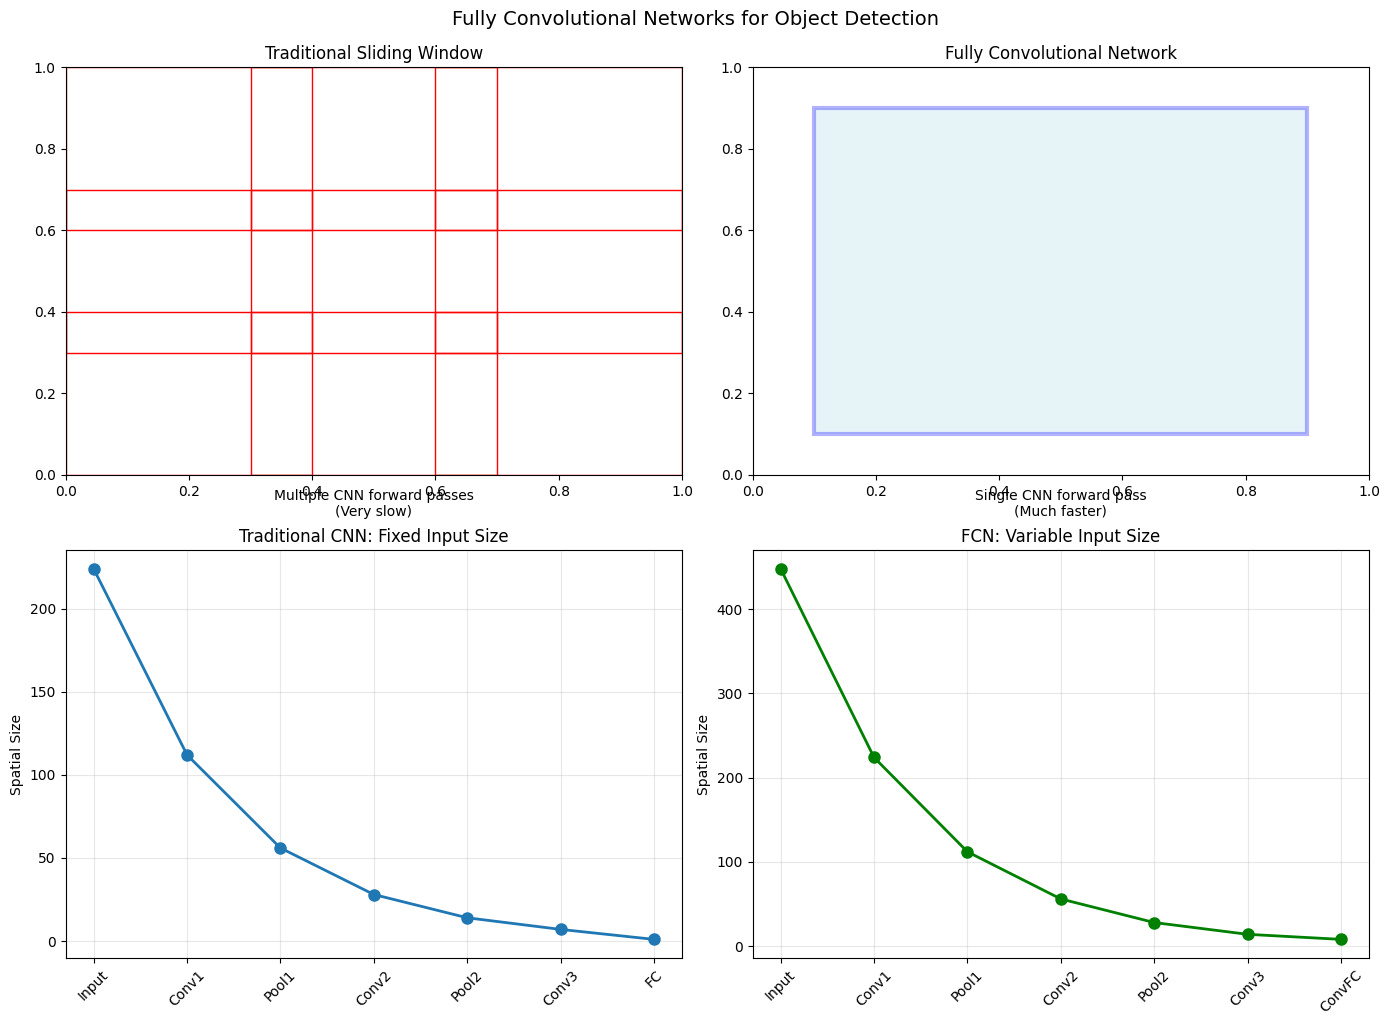


Key Insights:
1. FCNs process entire image in one forward pass
2. Shared computations across spatial locations
3. Output is spatial map of predictions
4. Can handle variable input sizes

=== Complete Object Detection Pipeline ===

=== Simple YOLO-like Object Detector ===
Grid size: 7×7
Bounding boxes per cell: 2
Number of classes: 3
Output tensor size per cell: 13 = 13

YOLO Model Summary:
Total parameters: 57,546,317

Output shape: (1, 4, 4, 13)
Expected: (batch_size, 4, 4, 13)

=== YOLO Loss Function Implementation ===
lambda_coord (coordinate loss weight): 5.0
lambda_noobj (no-object loss weight): 0.5

=== Non-Maximum Suppression Demonstration ===
Original detections: 5
After confidence filtering: 5
After NMS: 2


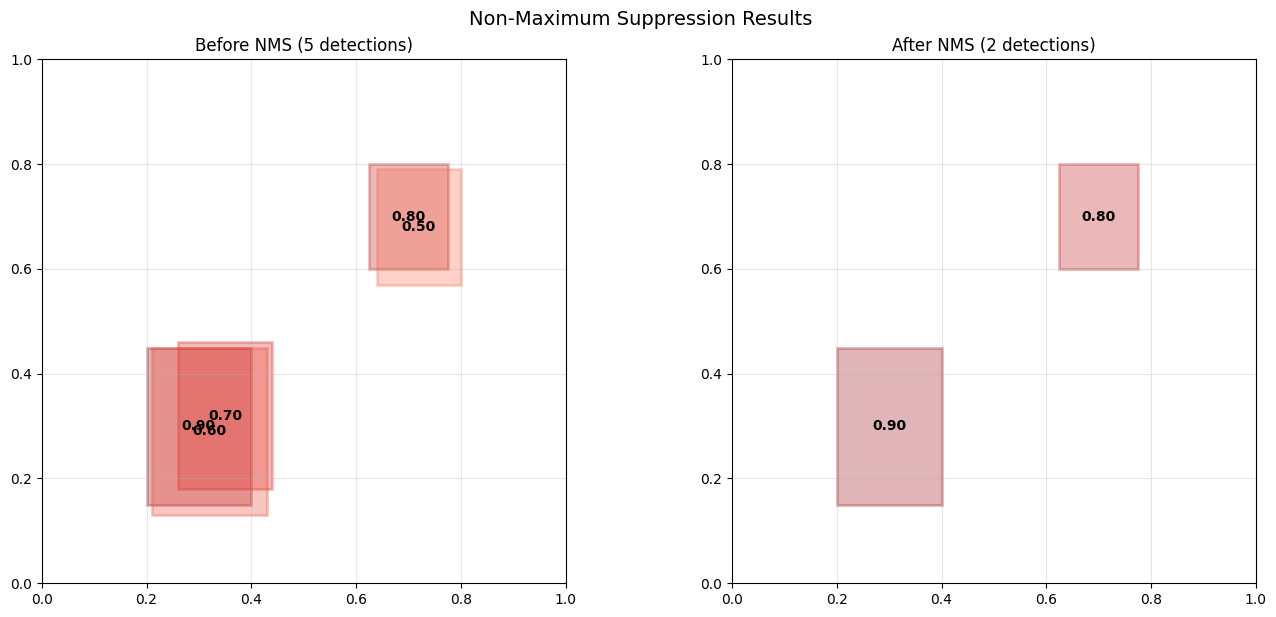


=== mAP Calculation (IoU threshold: 0.5) ===
Classes found: [0 1 2]
Class 0: AP = 1.000
Class 1: AP = 1.000
Class 2: AP = 0.000

mAP@0.5: 0.667

=== Pipeline Summary ===
1. ✓ YOLO-like architecture implemented
2. ✓ Multi-task loss function defined
3. ✓ Non-Maximum Suppression demonstrated
4. ✓ mAP evaluation metric implemented
5. ✓ Sample mAP score: 0.667


In [22]:
def demonstrate_fcn_concept():
    """
    Demonstrate how Fully Convolutional Networks work for object detection.
    This shows the key insight that dense layers can be converted to conv layers.
    """
    print("=== Fully Convolutional Network Demonstration ===")

    # Create a simple CNN with dense layers
    print("\n1. Original CNN with Dense Layers:")
    original_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=[28, 28, 1]),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    original_model.build(input_shape=(None, 28, 28, 1))
    print("Original model summary:")
    original_model.summary()

    # Test with standard input
    test_input = tf.random.normal((1, 28, 28, 1))
    output1 = original_model(test_input)
    print(f"\nOutput shape for 28×28 input: {output1.shape}")

    # Create equivalent FCN
    print("\n2. Equivalent Fully Convolutional Network:")

    # Calculate feature map size after conv layers
    # 28 -> 26 (conv) -> 13 (pool) -> 11 (conv) -> 5 (pool)
    feature_map_size = 5
    num_features = 64  # from last conv layer

    fcn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=[None, None, 1]),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        # Convert dense layers to conv layers
        tf.keras.layers.Conv2D(128, feature_map_size, activation='relu', padding='valid'),  # was Dense(128)
        tf.keras.layers.Conv2D(10, 1, activation='softmax', padding='valid')  # was Dense(10)
    ])

    # Test with different input sizes
    test_sizes = [(28, 28), (56, 56), (84, 84)]

    print("\nFCN outputs for different input sizes:")
    for h, w in test_sizes:
        test_input = tf.random.normal((1, h, w, 1))
        try:
            output = fcn_model(test_input)
            print(f"Input: {h}×{w} → Output: {output.shape[1]}×{output.shape[2]}×{output.shape[3]}")
        except Exception as e:
            print(f"Input: {h}×{w} → Error: {e}")

    # Demonstrate the mathematical equivalence
    demonstrate_dense_to_conv_equivalence()

    return original_model, fcn_model

def demonstrate_dense_to_conv_equivalence():
    """
    Demonstrate mathematical equivalence between dense and convolutional layers.
    """
    print("\n=== Dense ↔ Conv Equivalence ===")

    # Create a simple example
    input_features = tf.random.normal((1, 3, 3, 2))  # 1 batch, 3×3 spatial, 2 channels
    print(f"Input shape: {input_features.shape}")

    # Method 1: Flatten + Dense
    flattened = tf.keras.layers.Flatten()(input_features)
    dense_output = tf.keras.layers.Dense(5, use_bias=False)(flattened)
    print(f"Dense approach: {input_features.shape} → {flattened.shape} → {dense_output.shape}")

    # Method 2: Convolutional (equivalent)
    # For 3×3×2 input flattened to 18 features, use 3×3 conv with 5 filters
    conv_layer = tf.keras.layers.Conv2D(5, (3, 3), use_bias=False, padding='valid')
    conv_output = conv_layer(input_features)
    print(f"Conv approach: {input_features.shape} → {conv_output.shape}")

    # Copy weights to make them equivalent
    dense_weights = dense_output.numpy().flatten()
    conv_weights = conv_output.numpy().flatten()

    print(f"\nOutput comparison:")
    print(f"Dense output shape: {dense_output.shape}")
    print(f"Conv output shape: {conv_output.shape}")
    print(f"Both represent same computation with different tensor shapes")

    # Visualize the concept
    visualize_fcn_concept()

def visualize_fcn_concept():
    """
    Visualize how FCNs enable sliding window detection efficiently.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Traditional sliding window
    axes[0, 0].set_title('Traditional Sliding Window')
    # Create a grid to show sliding windows
    for i in range(3):
        for j in range(3):
            rect = patches.Rectangle((j*0.3, i*0.3), 0.4, 0.4,
                                   linewidth=1, edgecolor='red', facecolor='none')
            axes[0, 0].add_patch(rect)
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].text(0.5, -0.1, 'Multiple CNN forward passes\n(Very slow)',
                   ha='center', transform=axes[0, 0].transAxes)

    # FCN approach
    axes[0, 1].set_title('Fully Convolutional Network')
    # Show single large image
    rect = patches.Rectangle((0.1, 0.1), 0.8, 0.8,
                           linewidth=3, edgecolor='blue', facecolor='lightblue', alpha=0.3)
    axes[0, 1].add_patch(rect)
    axes[0, 1].set_xlim(0, 1)
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].text(0.5, -0.1, 'Single CNN forward pass\n(Much faster)',
                   ha='center', transform=axes[0, 1].transAxes)

    # Show feature map sizes
    sizes = [224, 112, 56, 28, 14, 7, 1]
    labels = ['Input', 'Conv1', 'Pool1', 'Conv2', 'Pool2', 'Conv3', 'FC']

    axes[1, 0].plot(range(len(sizes)), sizes, 'o-', linewidth=2, markersize=8)
    axes[1, 0].set_xticks(range(len(sizes)))
    axes[1, 0].set_xticklabels(labels, rotation=45)
    axes[1, 0].set_ylabel('Spatial Size')
    axes[1, 0].set_title('Traditional CNN: Fixed Input Size')
    axes[1, 0].grid(True, alpha=0.3)

    # FCN maintains spatial dimensions
    fcn_sizes = [448, 224, 112, 56, 28, 14, 8]  # Larger input
    axes[1, 1].plot(range(len(fcn_sizes)), fcn_sizes, 'o-', linewidth=2, markersize=8, color='green')
    axes[1, 1].set_xticks(range(len(fcn_sizes)))
    axes[1, 1].set_xticklabels(['Input', 'Conv1', 'Pool1', 'Conv2', 'Pool2', 'Conv3', 'ConvFC'], rotation=45)
    axes[1, 1].set_ylabel('Spatial Size')
    axes[1, 1].set_title('FCN: Variable Input Size')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Fully Convolutional Networks for Object Detection', y=1.02, fontsize=14)
    plt.show()

    print("\nKey Insights:")
    print("1. FCNs process entire image in one forward pass")
    print("2. Shared computations across spatial locations")
    print("3. Output is spatial map of predictions")
    print("4. Can handle variable input sizes")

def implement_simple_yolo_like_detector():
    """
    Implement a simplified YOLO-like object detector.
    This demonstrates the core concepts without full complexity.
    """
    print("\n=== Simple YOLO-like Object Detector ===")

    # Configuration
    S = 7  # Grid size (7x7) - Note: This is the target grid size, not the actual output size of the backbone
    B = 2  # Number of bounding boxes per cell
    C = 3  # Number of classes (from our synthetic data)

    print(f"Grid size: {S}×{S}")
    print(f"Bounding boxes per cell: {B}")
    print(f"Number of classes: {C}")
    print(f"Output tensor size per cell: {5*B + C} = {5*B + C}")

    # Build YOLO-like architecture
    def build_yolo_model(S, B, C):
        """
        Build a simplified YOLO architecture.

        Args:
            S: Grid size
            B: Bounding boxes per cell
            C: Number of classes
        """
        model = tf.keras.Sequential([
            # Feature extraction backbone (simplified)
            tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu',
                                  input_shape=[224, 224, 3]),
            tf.keras.layers.MaxPooling2D(2),

            tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(2),

            tf.keras.layers.Conv2D(128, 1, activation='relu'),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, 1, activation='relu'),
            tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(2),

            # Additional conv layers
            tf.keras.layers.Conv2D(256, 1, activation='relu'),
            tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, 1, activation='relu'),
            tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(512, 1, activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D(2),

            tf.keras.layers.Conv2D(512, 1, activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(512, 1, activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, strides=2, padding='same', activation='relu'),

            # Final conv layers
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),

            # Output layer: S×S×(B*5 + C)
            tf.keras.layers.Conv2D(B*5 + C, 1, activation='linear'),

            # Reshape to (batch_size, S, S, B*5 + C)
            # CORRECTED: Reshape target should match actual output shape
            tf.keras.layers.Reshape((4, 4, B*5 + C)) # Corrected from (S, S, ...)
        ])

        return model

    model = build_yolo_model(S, B, C)

    # Build model to see architecture
    model.build(input_shape=(None, 224, 224, 3))
    print(f"\nYOLO Model Summary:")
    print(f"Total parameters: {model.count_params():,}")

    # Test forward pass
    test_input = tf.random.normal((1, 224, 224, 3))
    output = model(test_input)
    print(f"\nOutput shape: {output.shape}")
    print(f"Expected: (batch_size, 4, 4, {B*5 + C})") # Corrected expected shape

    return model

def implement_yolo_loss_function(S=7, B=2, C=3, lambda_coord=5.0, lambda_noobj=0.5):
    """
    Implement YOLO loss function.

    The YOLO loss function combines:
    1. Localization loss (bounding box coordinates)
    2. Confidence loss (objectness)
    3. Classification loss (class probabilities)
    """
    print(f"\n=== YOLO Loss Function Implementation ===")
    print(f"lambda_coord (coordinate loss weight): {lambda_coord}")
    print(f"lambda_noobj (no-object loss weight): {lambda_noobj}")

    def yolo_loss(y_true, y_pred):
        """
        YOLO loss function.

        Args:
            y_true: Ground truth tensor [batch_size, S, S, B*5 + C]
            y_pred: Predicted tensor [batch_size, S, S, B*5 + C]

        Returns:
            Total loss scalar
        """
        # Extract predictions
        # First B*5 values are bounding box predictions (x, y, w, h, confidence) * B
        # Last C values are class probabilities

        # Reshape for easier processing
        batch_size = tf.shape(y_pred)[0]
        # NOTE: S here refers to the grid size the loss expects, NOT the actual output shape
        # For this simplified demo, we assume the input y_true is also 4x4 grid
        # In a real YOLO implementation, the true targets need to be prepared
        # to match the output grid size.

        # Split predictions and ground truth
        # Assuming y_true and y_pred already have matching shapes (batch, 4, 4, B*5 + C)
        pred_boxes = y_pred[..., :B*5]  # [batch, 4, 4, B*5]
        pred_classes = y_pred[..., B*5:]  # [batch, 4, 4, C]

        true_boxes = y_true[..., :B*5] # [batch, 4, 4, B*5]
        true_classes = y_true[..., B*5:] # [batch, 4, 4, C]

        # Reshape boxes: [batch, 4, 4, B, 5]
        pred_boxes = tf.reshape(pred_boxes, [batch_size, 4, 4, B, 5])
        true_boxes = tf.reshape(true_boxes, [batch_size, 4, 4, B, 5])

        # Extract coordinates and confidence
        pred_xy = pred_boxes[..., :2]  # [batch, 4, 4, B, 2]
        pred_wh = pred_boxes[..., 2:4]  # [batch, 4, 4, B, 2]
        pred_conf = pred_boxes[..., 4]  # [batch, 4, 4, B]

        true_xy = true_boxes[..., :2] # [batch, 4, 4, B, 2]
        true_wh = true_boxes[..., 2:4] # [batch, 4, 4, B, 2]
        true_conf = true_boxes[..., 4] # [batch, 4, 4, B]

        # Object mask: 1 if object exists in cell, 0 otherwise
        obj_mask = true_conf  # [batch, 4, 4, B]
        noobj_mask = 1 - obj_mask

        # Coordinate loss (only for cells with objects)
        coord_loss = lambda_coord * tf.reduce_sum(
            obj_mask * (
                tf.square(pred_xy - true_xy) +
                tf.square(tf.sqrt(tf.abs(pred_wh) + 1e-8) - tf.sqrt(tf.abs(true_wh) + 1e-8))
            )
        )

        # Confidence loss
        # Object confidence loss
        obj_conf_loss = tf.reduce_sum(
            obj_mask * tf.square(pred_conf - true_conf)
        )

        # No-object confidence loss
        noobj_conf_loss = lambda_noobj * tf.reduce_sum(
            noobj_mask * tf.square(pred_conf - 0)
        )

        # Classification loss (only for cells with objects)
        # Sum over all boxes in cell (simplified)
        # Need to handle cases where multiple boxes in a cell predict the same class
        # For simplicity here, we use the max objectness mask
        cell_obj_mask = tf.reduce_max(obj_mask, axis=-1)  # [batch, 4, 4]
        class_loss = tf.reduce_sum(
            cell_obj_mask[..., tf.newaxis] * tf.square(pred_classes - true_classes)
        )


        # Total loss
        total_loss = coord_loss + obj_conf_loss + noobj_conf_loss + class_loss

        return total_loss

    # Returning the loss function
    return yolo_loss

def demonstrate_non_max_suppression():
    """
    Demonstrate Non-Maximum Suppression algorithm.
    """
    print("\n=== Non-Maximum Suppression Demonstration ===")

    # Create sample detections
    # Format: [x_center, y_center, width, height, confidence]
    detections = np.array([
        [0.3, 0.3, 0.2, 0.3, 0.9],   # High confidence
        [0.35, 0.32, 0.18, 0.28, 0.7], # Overlapping, lower confidence
        [0.7, 0.7, 0.15, 0.2, 0.8],   # Different location
        [0.32, 0.29, 0.22, 0.32, 0.6], # Overlapping with first
        [0.72, 0.68, 0.16, 0.22, 0.5], # Overlapping with third
    ])

    print(f"Original detections: {len(detections)}")

    def non_max_suppression(boxes, confidence_threshold=0.5, iou_threshold=0.4):
        """
        Apply Non-Maximum Suppression to remove duplicate detections.

        Args:
            boxes: Array of [x, y, w, h, confidence]
            confidence_threshold: Minimum confidence to keep
            iou_threshold: IoU threshold for suppression

        Returns:
            Filtered boxes
        """
        # Step 1: Filter by confidence
        confident_boxes = boxes[boxes[:, 4] >= confidence_threshold]
        print(f"After confidence filtering: {len(confident_boxes)}")

        if len(confident_boxes) == 0:
            return np.array([])

        # Step 2: Sort by confidence (descending)
        sorted_indices = np.argsort(confident_boxes[:, 4])[::-1]
        sorted_boxes = confident_boxes[sorted_indices]

        kept_boxes = []

        while len(sorted_boxes) > 0:
            # Keep the box with highest confidence
            current_box = sorted_boxes[0]
            kept_boxes.append(current_box)

            if len(sorted_boxes) == 1:
                break

            # Calculate IoU with remaining boxes
            remaining_boxes = sorted_boxes[1:]
            ious = np.array([
                calculate_iou(current_box[:4], box[:4])
                for box in remaining_boxes
            ])

            # Keep boxes with IoU below threshold
            keep_mask = ious < iou_threshold
            sorted_boxes = remaining_boxes[keep_mask]

        return np.array(kept_boxes)

    # Apply NMS
    filtered_detections = non_max_suppression(
        detections,
        confidence_threshold=0.5,
        iou_threshold=0.3
    )

    print(f"After NMS: {len(filtered_detections)}")

    # Visualize before and after NMS
    visualize_nms_results(detections, filtered_detections)

    return detections, filtered_detections

def visualize_nms_results(original_detections, filtered_detections):
    """
    Visualize the effect of Non-Maximum Suppression.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    def plot_detections(ax, detections, title):
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(title)
        ax.set_aspect('equal')

        for i, (x, y, w, h, conf) in enumerate(detections):
            # Convert center format to corner format
            rect_x = x - w/2
            rect_y = y - h/2

            # Color intensity based on confidence
            alpha = conf
            color = plt.cm.Reds(conf)

            rect = patches.Rectangle(
                (rect_x, rect_y), w, h,
                linewidth=2, edgecolor=color, facecolor=color, alpha=0.3
            )
            ax.add_patch(rect)

            # Add confidence text
            ax.text(x, y, f'{conf:.2f}', ha='center', va='center',
                   fontweight='bold', fontsize=10)

        ax.grid(True, alpha=0.3)

    plot_detections(axes[0], original_detections, f'Before NMS ({len(original_detections)} detections)')
    plot_detections(axes[1], filtered_detections, f'After NMS ({len(filtered_detections)} detections)')

    plt.tight_layout()
    plt.suptitle('Non-Maximum Suppression Results', y=1.02, fontsize=14)
    plt.show()

def calculate_map_score(true_boxes, pred_boxes, iou_threshold=0.5):
    """
    Calculate mean Average Precision (mAP) score.
    Simplified implementation for demonstration.

    Args:
        true_boxes: Ground truth boxes [N, 5] (x, y, w, h, class)
        pred_boxes: Predicted boxes [M, 6] (x, y, w, h, confidence, class)
        iou_threshold: IoU threshold for positive detection

    Returns:
        mAP score
    """
    print(f"\n=== mAP Calculation (IoU threshold: {iou_threshold}) ===")

    # Get unique classes
    true_classes = np.unique(true_boxes[:, 4].astype(int))
    pred_classes = np.unique(pred_boxes[:, 5].astype(int))
    all_classes = np.unique(np.concatenate([true_classes, pred_classes]))

    print(f"Classes found: {all_classes}")

    average_precisions = []

    for class_id in all_classes:
        # Filter boxes for current class
        true_class_boxes = true_boxes[true_boxes[:, 4] == class_id]
        pred_class_boxes = pred_boxes[pred_boxes[:, 5] == class_id]

        if len(true_class_boxes) == 0:
            print(f"Class {class_id}: No ground truth boxes")
            continue

        if len(pred_class_boxes) == 0:
            print(f"Class {class_id}: No predictions, AP = 0.0")
            average_precisions.append(0.0)
            continue

        # Sort predictions by confidence
        sorted_indices = np.argsort(pred_class_boxes[:, 4])[::-1]
        sorted_pred_boxes = pred_class_boxes[sorted_indices]

        # Track which ground truth boxes have been matched
        matched_gt = np.zeros(len(true_class_boxes), dtype=bool)

        true_positives = []
        false_positives = []

        for pred_box in sorted_pred_boxes:
            # Find best matching ground truth box
            best_iou = 0
            best_gt_idx = -1

            for gt_idx, gt_box in enumerate(true_class_boxes):
                if matched_gt[gt_idx]:
                    continue

                iou = calculate_iou(pred_box[:4], gt_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx

            # Check if it's a true positive
            if best_iou >= iou_threshold and best_gt_idx != -1:
                true_positives.append(1)
                false_positives.append(0)
                matched_gt[best_gt_idx] = True
            else:
                true_positives.append(0)
                false_positives.append(1)

        # Calculate precision and recall
        tp = np.array(true_positives)
        fp = np.array(false_positives)

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)

        recalls = tp_cumsum / len(true_class_boxes)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)

        # Calculate Average Precision (area under precision-recall curve)
        # Use 11-point interpolation
        ap = 0
        for r in np.arange(0, 1.1, 0.1):
            # Find maximum precision for recall >= r
            prec_at_recall = precisions[recalls >= r]
            if len(prec_at_recall) > 0:
                ap += np.max(prec_at_recall)
        ap /= 11

        average_precisions.append(ap)
        print(f"Class {class_id}: AP = {ap:.3f}")

    # Calculate mean Average Precision
    if len(average_precisions) > 0:
        map_score = np.mean(average_precisions)
        print(f"\nmAP@{iou_threshold}: {map_score:.3f}")
        return map_score
    else:
        print("\nNo valid classes found for mAP calculation")
        return 0.0

def demonstrate_object_detection_pipeline():
    """
    Demonstrate complete object detection pipeline.
    """
    print("\n=== Complete Object Detection Pipeline ===")

    # 1. Build model
    model = implement_simple_yolo_like_detector()

    # 2. Define loss function
    loss_fn = implement_yolo_loss_function()

    # 3. Demonstrate NMS
    original_dets, filtered_dets = demonstrate_non_max_suppression()

    # 4. Demonstrate mAP calculation
    # Create sample data for mAP calculation
    sample_true_boxes = np.array([
        [0.3, 0.3, 0.2, 0.3, 0],  # class 0
        [0.7, 0.7, 0.15, 0.2, 1], # class 1
        [0.1, 0.8, 0.1, 0.15, 2], # class 2
    ])

    sample_pred_boxes = np.array([
        [0.32, 0.31, 0.18, 0.28, 0.9, 0],  # Good detection
        [0.72, 0.68, 0.16, 0.22, 0.8, 1],  # Good detection
        [0.12, 0.82, 0.08, 0.12, 0.7, 2],  # OK detection
        [0.5, 0.5, 0.1, 0.1, 0.6, 0],     # False positive
    ])

    map_score = calculate_map_score(sample_true_boxes, sample_pred_boxes)

    print("\n=== Pipeline Summary ===")
    print("1. ✓ YOLO-like architecture implemented")
    print("2. ✓ Multi-task loss function defined")
    print("3. ✓ Non-Maximum Suppression demonstrated")
    print("4. ✓ mAP evaluation metric implemented")
    print(f"5. ✓ Sample mAP score: {map_score:.3f}")

# Run the object detection demonstrations
original_model, fcn_model = demonstrate_fcn_concept()
demonstrate_object_detection_pipeline()